# Optimising cluster shape properties with new algorithm

This algorithm uses triangles of different sizes:

1. P0113
2. P016
3. P03
4. P045

Together with the generator level information, we will use these four different sizes for four different studies and try to understand the impact of granularity on cluster properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import shap
from pathlib import Path
from itertools import cycle
from matplotlib.lines import Line2D
import matplotlib as mpl
import mplhep as mh
mh.style.use("CMS")


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

#### We don't want to flood all CPUs!

In [2]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

## Path to the skimmed files that have implemented the new clustering algorithm
#### For now, we use $p_T^{gen} > 20$ GeV, $ 20 < p_T^{reco} < 100$ GeV, $ 1.6 < |\eta^{gen/reco}| < 2.8 $ for all samples.
#### $\Delta R = 0.05/0.1/0.5$ is used for photons/pions/QCD photons.
#### `genpart_reachedEE == 2` is used in photon/pion/QCD sample to ensure all photons are unconverted before they reach the endcaps.
#### For QCD sample, we gen-match to final state photons.

In [3]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_gen.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_Ref.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p0113.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p016.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p03.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgo_cl3d_p045.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_gen.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_Ref.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p0113.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p016.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p03.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/qcdPU200_newalgo_cl3d_p045.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_gen.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_Ref.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p0113.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p016.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p03.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgo_cl3d_p045.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_Ref.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p0113.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p016.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p03.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgo_cl3d_p045.h5"

Using helpers from analysis.py to load mapped gen and reco clusters

In [4]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [5]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [6]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [7]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

### Until this point, it is evident that with coarser granularity, the number of clusters increase!
This is an expected behaviour as lower triangle sizes removes clusters from pileup!

Again, using helpers from analysis.py, we implement gen-matching of the photons across different samples.

In [8]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.2)
qcd_df_p0113_filtered = ana.filter_by_delta_r(qcd_df_p0113, "cl3d_p0113Tri", 0.2)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.2)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.2)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.2)

In [9]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.5)
pion_df_p0113_filtered = ana.filter_by_delta_r(pion_df_p0113, "cl3d_p0113Tri", 0.5)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.5)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.5)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.5)

The new samples also have a hardware implementation version of all the features. This is because in the end, in the FPGAs, all the features will be represented in integer notations.

In [10]:
def filter_by_delta_r(df, prefix):
    required_columns = [f"{prefix}_eta", f"{prefix}_phi", "genpart_exeta", "genpart_exphi", f"{prefix}_energy", "event", "gen_pt",]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    df = df.copy()
    m_sign = (df[f"{prefix}_eta"] * df["genpart_exeta"]) > 0.0
    df = df[m_sign]
    df["delta_r"] = ana.delta_r(
        df[f"{prefix}_eta"], df[f"{prefix}_phi"],
        df["genpart_exeta"], df["genpart_exphi"]
    )
    # build per-row ΔR threshold
    if prefix in ["cl3d_Ref", "cl3d_p0113Tri", "cl3d_p016Tri"]:
        dr_thr = 0.10
        m_dr = df["delta_r"] < dr_thr
    elif prefix in ["cl3d_p03Tri", "cl3d_p045Tri"]:
        # gen-pt dependent
        dr_thr_arr = np.where(df["gen_pt"].to_numpy() < 70.0, 0.15, 0.60)
        m_dr = df["delta_r"].to_numpy() < dr_thr_arr
    else:
        raise ValueError(f"Unknown prefix '{prefix}' for ΔR threshold rules")
    df_filtered = df[m_dr]
    # best match per event: highest energy, then smallest ΔR
    df_sorted = df_filtered.sort_values(
        by=["event", f"{prefix}_energy", "delta_r"],
        ascending=[True, False, True]
    )
    df_best_match = df_sorted.groupby("event").first().reset_index()
    return df_best_match
photon_df_Ref_filtered = filter_by_delta_r(photon_df_Ref, "cl3d_Ref")
photon_df_p0113_filtered = filter_by_delta_r(photon_df_p0113, "cl3d_p0113Tri")
photon_df_p016_filtered = filter_by_delta_r(photon_df_p016, "cl3d_p016Tri")
photon_df_p03_filtered = filter_by_delta_r(photon_df_p03, "cl3d_p03Tri")
photon_df_p045_filtered = filter_by_delta_r(photon_df_p045, "cl3d_p045Tri")

## Let's begin the multi-class BDT

In [11]:
# Ref
'''photon_df_Ref_filtered['label'] = 0
pion_df_Ref_filtered['label'] = 3
qcd_df_Ref_filtered['label'] = 2
PU_df_Ref['label'] = 1'''

# p0113
photon_df_p0113_filtered['label'] = 0
pion_df_p0113_filtered['label'] = 3
qcd_df_p0113_filtered['label'] = 2
PU_df_p0113['label'] = 1

# p016
'''photon_df_p016_filtered['label'] = 0
pion_df_p016_filtered['label'] = 3
qcd_df_p016_filtered['label'] = 2
PU_df_p016['label'] = 1

# p03
photon_df_p03_filtered['label'] = 0
pion_df_p03_filtered['label'] = 3
qcd_df_p03_filtered['label'] = 2
PU_df_p03['label'] = 1

# p045
photon_df_p045_filtered['label'] = 0
pion_df_p045_filtered['label'] = 3
qcd_df_p045_filtered['label'] = 2
PU_df_p045['label'] = 1'''

"photon_df_p016_filtered['label'] = 0\npion_df_p016_filtered['label'] = 3\nqcd_df_p016_filtered['label'] = 2\nPU_df_p016['label'] = 1\n\n# p03\nphoton_df_p03_filtered['label'] = 0\npion_df_p03_filtered['label'] = 3\nqcd_df_p03_filtered['label'] = 2\nPU_df_p03['label'] = 1\n\n# p045\nphoton_df_p045_filtered['label'] = 0\npion_df_p045_filtered['label'] = 3\nqcd_df_p045_filtered['label'] = 2\nPU_df_p045['label'] = 1"

In [12]:
all_dfs = [qcd_df_p0113_filtered, photon_df_p0113_filtered, PU_df_p0113, pion_df_p0113_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][ana.columns_for_training('p0113Tri') + ['label']]

In [13]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [16]:
X = df_combined[ana.columns_for_training('p0113Tri')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [ ]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weights, test_size=0.2, stratify=y, random_state=42)

In [18]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=5,
    n_estimators=50,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
model.fit(X_train, y_train, sample_weight=w_train,
          eval_set=[(X_test, y_test)],
          sample_weight_eval_set=[w_test],
          early_stopping_rounds=20)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [20]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2, 3]), y_pred_proba, multi_class='ovo')
print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")


✅ Accuracy: 0.901
🔢 Confusion Matrix:
 [[  7627     23    138     76]
 [  2004 307003  18024  13840]
 [   112    242   1831    136]
 [    15     34    119    450]]
📈 ROC AUC (OvR): 0.963


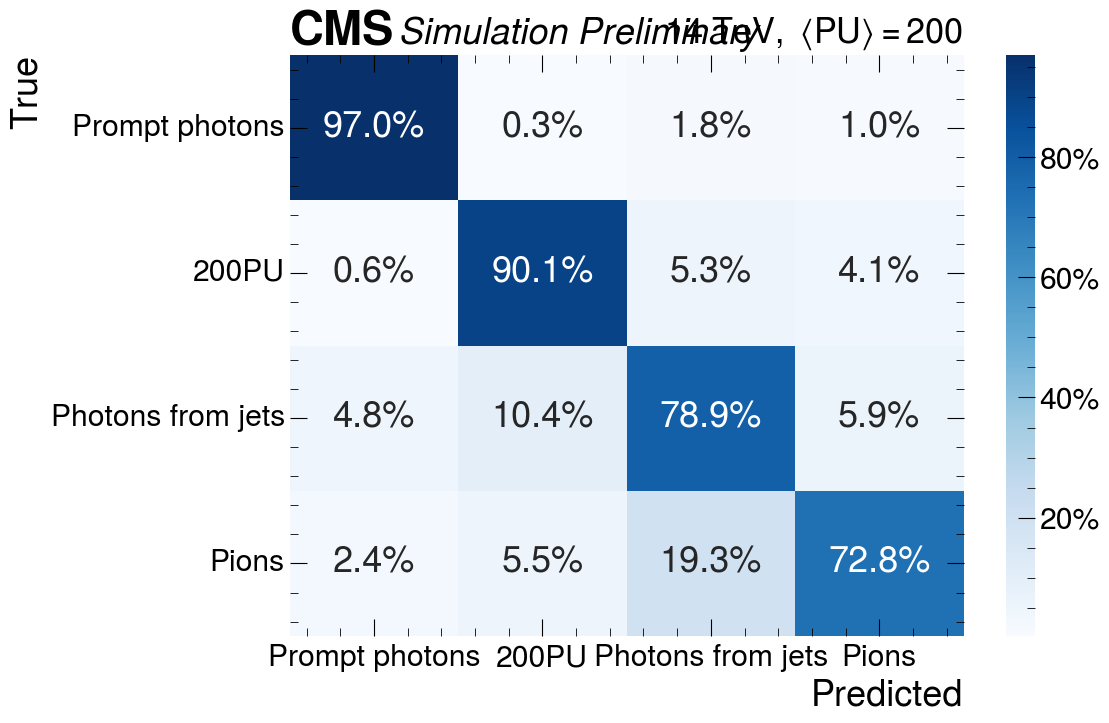

In [31]:
# Row-normalize to percentages
class_names = ['Prompt photons', '200PU', 'Photons from jets', 'Pions']
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True)
conf_mat_pct = np.divide(conf_mat, row_sums, out=np.zeros_like(conf_mat), where=row_sums!=0) * 100.0

# Make pretty percent labels
annot_labels = np.array([[f"{v:.1f}%" for v in row] for row in conf_mat_pct])

plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat_pct, annot=annot_labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"format": '%.0f%%'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout(rect=[0, 0, 1, 0.92])
#plt.title("Confusion Matrix")
fig = plt.gcf()
#plt.subplots_adjust(top=0.98, right=0.95)
mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle = 200$",
   ) # ax can be implicit
#mh.cms.text(r"$\langle PU\rangle = 200$" ) # ax can be implicit
'''plt.text(
    0.98, 1.02,
    r"$14~\mathrm{TeV},\ \langle PU\rangle = 200$",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=14
)'''

plt.savefig("newsamples_p0113_plots/confusion_matrix.pdf")
plt.show()

In [32]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Normalise by true class totals (row-wise)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

roc_auc = roc_auc_score(
    label_binarize(y_test, classes=[0, 1, 2, 3]),
    y_pred_proba,
    multi_class='ovr'
)

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("🔢 Normalised Confusion Matrix (%):\n", np.round(conf_mat_norm, 2))
print(f"📈 ROC AUC (OvR): {roc_auc*100:.2f}%")


✅ Accuracy: 90.11%
🔢 Normalised Confusion Matrix (%):
 [[96.99  0.29  1.75  0.97]
 [ 0.59 90.06  5.29  4.06]
 [ 4.83 10.43 78.89  5.86]
 [ 2.43  5.5  19.26 72.82]]
📈 ROC AUC (OvR): 96.28%


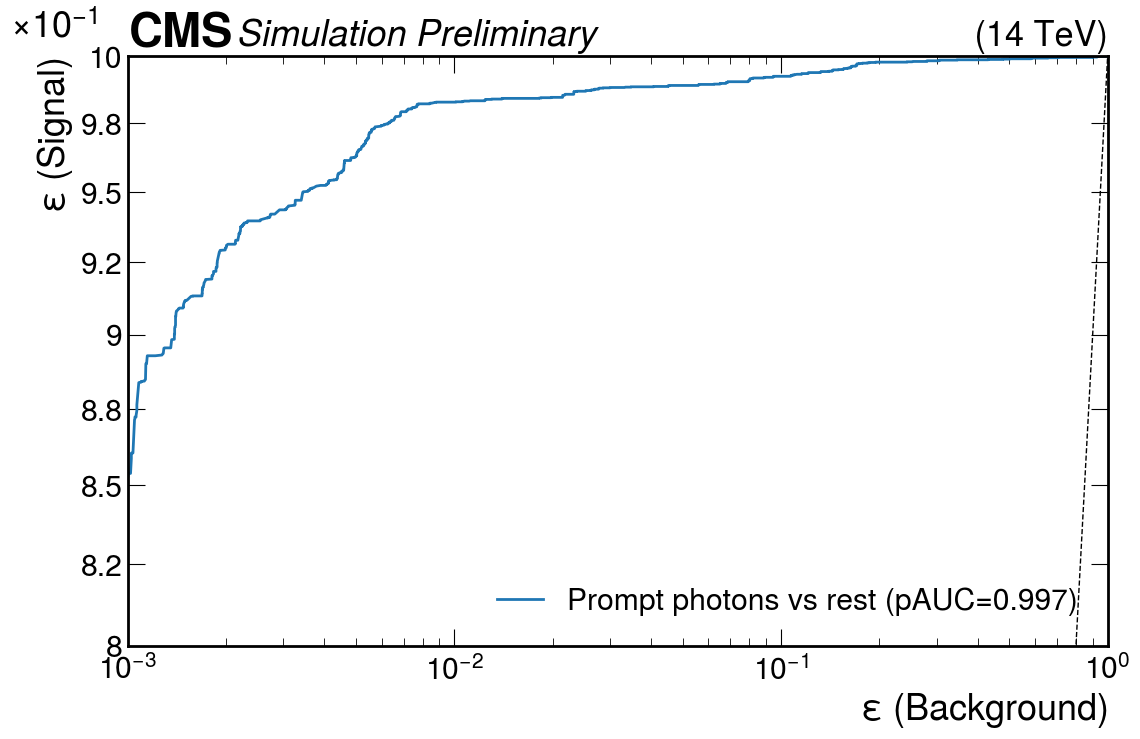

In [34]:
from matplotlib.ticker import FixedLocator, FixedFormatter
thr = 0.8  # signal efficiency threshold
n_classes = 1
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = {}
tpr = {}
roc_auc = {}
partial_auc = {}

plt.figure(figsize=(12, 8))

for i in range(n_classes):
    # ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr_full, tpr_full)

    # Keep only points with TPR >= 0.8
    mask = tpr_full >= 0
    if np.sum(mask) > 1:
        fpr[i], tpr[i] = fpr_full[mask], tpr_full[mask]
        partial_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{class_names[i]} vs rest (pAUC={partial_auc[i]:.3f})")
    else:
        fpr[i], tpr[i] = None, None
        partial_auc[i] = np.nan

# Diagonal line (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.001, 1.0])
plt.ylim([thr, 1.0])  # zoom into TPR >= 0.8
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()

# Choose the y-ticks you want to show (edit step if you want denser/sparser)
yticks = np.array([0.80, 0.825, 0.85, 0.875,0.90, 0.925, 0.95, 0.975, 1.00])

# Put ticks at the true values (0.8..1.0) but label them without "×10^-1"
ax.yaxis.set_major_locator(FixedLocator(yticks))
ax.yaxis.set_major_formatter(FixedFormatter([f"{y*10:.2g}" for y in yticks]))

# Add the global factor once (position can be tweaked)
ax.text(-0.12, 1.02, r'$\times 10^{-1}$',
        transform=ax.transAxes, ha='left', va='bottom')

plt.ylim([thr, 1.0])  # keep your zoom
plt.xlabel(r"$\epsilon$ (Background)")
plt.ylabel(r"$\epsilon$ (Signal)")
plt.legend(loc='lower right')
fig = plt.gcf()
plt.subplots_adjust(top=0.98, right=0.95)
mh.cms.label("Preliminary", data=False, com=14)
#mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle = 200$",)
plt.tight_layout()

plt.savefig("newsamples_p0113_plots/multiclass_roc_ovr_photon.pdf")
plt.show()

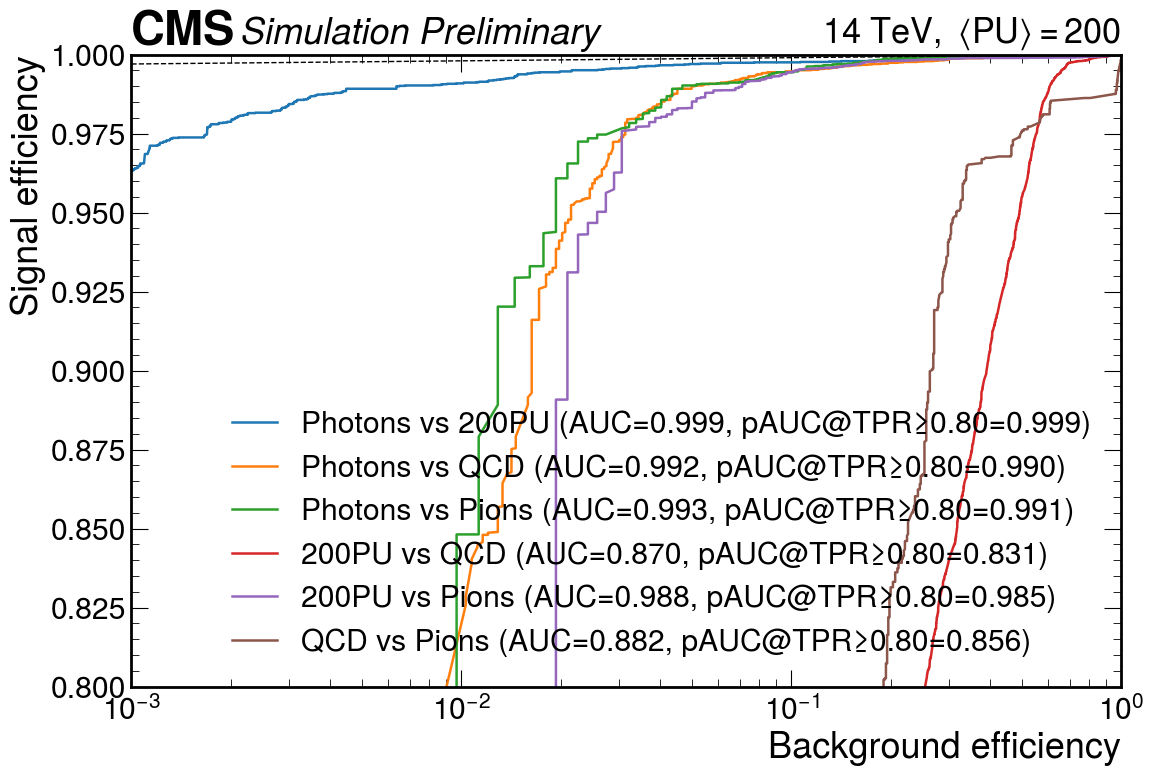

pos_class neg_class      AUC  pAUC_TPR>=0.8  n_samples   n_pos   n_neg
  Photons     200PU 0.998756       0.998749    2603559    7658 2595901
  Photons     Pions 0.992763       0.991373       8278    7658     620
  Photons       QCD 0.991575       0.989799       9983    7658    2325
    200PU     Pions 0.988050       0.984884    2596521 2595901     620
      QCD     Pions 0.882474       0.856078       2945    2325     620
    200PU       QCD 0.869608       0.831371    2598226 2595901    2325
  Photons   Photons      NaN            NaN       7658    7658    7658
    200PU     200PU      NaN            NaN    2595901 2595901 2595901
      QCD       QCD      NaN            NaN       2325    2325    2325
    Pions     Pions      NaN            NaN        620     620     620


In [29]:
classes = np.arange(y_pred_proba.shape[1])  # or: np.unique(y_test)
n_classes = len(classes)

results = []
plt.figure(figsize=(12, 8))
thr =0.8
for i in range(n_classes):
    for j in range(i, n_classes):
        # Keep only samples from classes i and j
        mask = (y_test == i) | (y_test == j)
        if not np.any(mask):
            continue

        y_true = (y_test[mask] == i).astype(int)       # i is positive class
        y_score = y_pred_proba[mask, i]               # score for class i

        # Need both classes present to compute ROC
        if len(np.unique(y_true)) < 2:
            full_auc = np.nan
            fpr_full, tpr_full = np.array([0, 1]), np.array([0, 1])
        else:
            fpr_full, tpr_full, _ = roc_curve(y_true, y_score)
            full_auc = auc(fpr_full, tpr_full)

        # Partial AUC for TPR >= thr
        keep = tpr_full >= 0.6
        if np.count_nonzero(keep) >= 2:
            fpr_p, tpr_p = fpr_full[keep], tpr_full[keep]
            p_auc = auc(fpr_p, tpr_p)

            # Plot only the partial segment to focus on high efficiency
            plt.plot(fpr_p, tpr_p, lw=1.8,
                     label=f"{class_names[i]} vs {class_names[j]} "
                           f"(AUC={full_auc:.3f}, pAUC@TPR≥{thr:.2f}={p_auc:.3f})")
        else:
            p_auc = np.nan

        results.append({
            "pos_class": class_names[i],
            "neg_class": class_names[j],
            "AUC": full_auc,
            f"pAUC_TPR>={thr}": p_auc,
            "n_samples": int(mask.sum()),
            "n_pos": int((y_test[mask] == i).sum()),
            "n_neg": int((y_test[mask] == j).sum()),
        })

# Chance diagonal (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([1e-3, 1.0])
plt.ylim([0.8, 1.0])          # zoom into high-efficiency region
plt.xscale('log')
plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')
plt.legend(loc='lower right')
fig = plt.gcf()
plt.subplots_adjust(top=0.90, right=0.95)
mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle = 200$",)
plt.savefig("newsamples_Ref_plots/multiclass_roc_ovo.pdf")
plt.show()

# Summary table
df_pairwise = pd.DataFrame(results)
print(df_pairwise.sort_values("AUC", ascending=False).to_string(index=False))


In [41]:
from matplotlib.ticker import FixedLocator, FixedFormatter
OUTDIR = "triangle_comparison_plots"
os.makedirs(OUTDIR, exist_ok=True)

class_names = ['Prompt', '200PU', 'Jets', 'Pions']
classes = np.array([0, 1, 2, 3])
PHOTON_CLASS = 0

RANDOM_STATE = 42
TEST_SIZE = 0.2
THR_TPR = 0.80  # for partial AUC in high-eff region

def prepare_combined_df(photon_df, pu_df, qcd_df, pion_df, columns, labels=(0,1,2,3)):
    p_lab, pu_lab, qcd_lab, pi_lab = labels
    photon = photon_df.copy()
    pu     = pu_df.copy()
    qcd    = qcd_df.copy()
    pion   = pion_df.copy()
    photon["label"] = p_lab
    pu["label"]     = pu_lab
    qcd["label"]    = qcd_lab
    pion["label"]   = pi_lab
    dfs = [qcd, photon, pu, pion]
    dfs = [d[columns + ["label"]] for d in dfs]
    return pd.concat(dfs, ignore_index=True)


def train_and_eval_triangle(tri_key, df_combined, feature_cols, max_depth=5, n_estimators=200, learning_rate=0.001, n_jobs=8):
    X = df_combined[feature_cols]
    y = df_combined["label"].astype(int)
    w = compute_sample_weight(class_weight="balanced", y=y)
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

    model = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=len(classes),
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        eval_metric="mlogloss",
        n_jobs=n_jobs,
        verbosity=0)
    model.fit(X_train, y_train, sample_weight=w_train, eval_set=[(X_test, y_test)], sample_weight_eval_set=[w_test], early_stopping_rounds=50)
    y_proba = model.predict_proba(X_test)
    y_pred  = np.argmax(y_proba, axis=1)
    acc = accuracy_score(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred, labels=classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_ovr = roc_auc_score(y_test_bin, y_proba, multi_class="ovr", average="macro")
    auc_ovo = roc_auc_score(y_test_bin, y_proba, multi_class="ovo", average="macro")
    fpr, tpr, _ = roc_curve(y_test_bin[:, PHOTON_CLASS], y_proba[:, PHOTON_CLASS])
    full_auc = auc(fpr, tpr)
    keep = tpr >= THR_TPR
    if np.count_nonzero(keep) >= 2:
        fpr_p, tpr_p = fpr[keep], tpr[keep]
        p_auc = auc(fpr_p, tpr_p)
    else:
        fpr_p, tpr_p, p_auc = None, None, np.nan
    out = {
        "tri": tri_key,
        "model": model,
        "X_test": X_test,
        "y_test": y_test.to_numpy(),
        "y_proba": y_proba,
        "y_pred": y_pred,
        "cm": cm,
        "acc": acc,
        "auc_ovr_macro": auc_ovr,
        "auc_ovo_macro": auc_ovo,
        "photon_fpr": fpr,
        "photon_tpr": tpr,
        "photon_auc": full_auc,
        "photon_fpr_p": fpr_p,
        "photon_tpr_p": tpr_p,
        "photon_pauc": p_auc,
    }
    return out

def cm_to_percent(cm):
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    return np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0) * 100.0

def plot_photon_roc_overlay(results, outpath, thr=THR_TPR, logx=True, logy=False):
    plt.figure(figsize=(14, 9))
    for r in results:
        fpr = r["photon_fpr"]
        tpr = r["photon_tpr"]
        tri = r["tri"]          # e.g. "p0113"
        aval = float("0." + tri[1:])
        plt.plot(fpr, tpr, lw=2, label=f's={aval} (pAUC={r["photon_pauc"]:.3f})')
    #plt.plot([0, 1], [0, 1], "k--", lw=1)

    plt.xlim([1e-4, 1.0])
    plt.ylim([thr, 1.0])
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.xlabel(r"Background efficiency")
    plt.ylabel(r"Signal efficiency")
    plt.legend(loc="lower right", fontsize=20)
    mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$")
    plt.tight_layout()
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()

def make_summary_table(results):
    rows = []
    for r in results:
        rows.append({
            "triangle": r["tri"],
            "accuracy": r["acc"],
            "AUC_macro_OvR": r["auc_ovr_macro"],
            "AUC_macro_OvO": r["auc_ovo_macro"],
            "Photon_AUC": r["photon_auc"],
            f"Photon_pAUC_TPR>={THR_TPR:.2f}": r["photon_pauc"],
        })
    return pd.DataFrame(rows).sort_values("Photon_AUC", ascending=False)

tri_cfg = {
    # "Ref": {
    #     "feature_key": "Ref",
    #     "photon": photon_df_Ref_filtered,
    #     "pu":     PU_df_Ref,
    #     "qcd":    qcd_df_Ref_filtered,
    #     "pion":   pion_df_Ref_filtered,
    # },

    "p0113": {
        "label": "s = 0.0113",
        "feature_key": "p0113Tri",
        "photon": photon_df_p0113_filtered,
        "pu":     PU_df_p0113,
        "qcd":    qcd_df_p0113_filtered,
        "pion":   pion_df_p0113_filtered,
    },

    "p016": {
        "label": "s = 0.016",
        "feature_key": "p016Tri",
        "photon": photon_df_p016_filtered,
        "pu":     PU_df_p016,
        "qcd":    qcd_df_p016_filtered,
        "pion":   pion_df_p016_filtered,
    },

    "p03": {
        "label": "s = 0.03",
        "feature_key": "p03Tri",
        "photon": photon_df_p03_filtered,
        "pu":     PU_df_p03,
        "qcd":    qcd_df_p03_filtered,
        "pion":   pion_df_p03_filtered,
    },

    "p045": {
        "label": "s = 0.045",
        "feature_key": "p045Tri",
        "photon": photon_df_p045_filtered,
        "pu":     PU_df_p045,
        "qcd":    qcd_df_p045_filtered,
        "pion":   pion_df_p045_filtered,
    },
}

In [14]:
results = []
for tri_name, cfg in tri_cfg.items():
    feat_cols = ana.columns_for_training(cfg["feature_key"])
    dfc = prepare_combined_df(cfg["photon"], cfg["pu"], cfg["qcd"], cfg["pion"], columns=feat_cols)
    r = train_and_eval_triangle(tri_name, dfc, feat_cols, max_depth=4, n_estimators=50, learning_rate=0.001)
    results.append(r)
summary = make_summary_table(results)
display(summary)


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38502
[1]	validation_0-mlogloss:1.38374
[2]	validation_0-mlogloss:1.38247
[3]	validation_0-mlogloss:1.38119
[4]	validation_0-mlogloss:1.37993
[5]	validation_0-mlogloss:1.37866
[6]	validation_0-mlogloss:1.37740
[7]	validation_0-mlogloss:1.37614
[8]	validation_0-mlogloss:1.37488
[9]	validation_0-mlogloss:1.37362
[10]	validation_0-mlogloss:1.37237
[11]	validation_0-mlogloss:1.37112
[12]	validation_0-mlogloss:1.36987
[13]	validation_0-mlogloss:1.36862
[14]	validation_0-mlogloss:1.36738
[15]	validation_0-mlogloss:1.36614
[16]	validation_0-mlogloss:1.36490
[17]	validation_0-mlogloss:1.36366
[18]	validation_0-mlogloss:1.36243
[19]	validation_0-mlogloss:1.36120
[20]	validation_0-mlogloss:1.35997
[21]	validation_0-mlogloss:1.35874
[22]	validation_0-mlogloss:1.35752
[23]	validation_0-mlogloss:1.35630
[24]	validation_0-mlogloss:1.35508
[25]	validation_0-mlogloss:1.35386
[26]	validation_0-mlogloss:1.35265
[27]	validation_0-mlogloss:1.35144
[28]	validation_0-mlogloss:1.3

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38507
[1]	validation_0-mlogloss:1.38385
[2]	validation_0-mlogloss:1.38264
[3]	validation_0-mlogloss:1.38142
[4]	validation_0-mlogloss:1.38022
[5]	validation_0-mlogloss:1.37901
[6]	validation_0-mlogloss:1.37781
[7]	validation_0-mlogloss:1.37660
[8]	validation_0-mlogloss:1.37540
[9]	validation_0-mlogloss:1.37420
[10]	validation_0-mlogloss:1.37301
[11]	validation_0-mlogloss:1.37181
[12]	validation_0-mlogloss:1.37062
[13]	validation_0-mlogloss:1.36943
[14]	validation_0-mlogloss:1.36825
[15]	validation_0-mlogloss:1.36706
[16]	validation_0-mlogloss:1.36588
[17]	validation_0-mlogloss:1.36470
[18]	validation_0-mlogloss:1.36352
[19]	validation_0-mlogloss:1.36235
[20]	validation_0-mlogloss:1.36117
[21]	validation_0-mlogloss:1.36000
[22]	validation_0-mlogloss:1.35884
[23]	validation_0-mlogloss:1.35767
[24]	validation_0-mlogloss:1.35650
[25]	validation_0-mlogloss:1.35534
[26]	validation_0-mlogloss:1.35418
[27]	validation_0-mlogloss:1.35303
[28]	validation_0-mlogloss:1.3

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38512
[1]	validation_0-mlogloss:1.38394
[2]	validation_0-mlogloss:1.38276
[3]	validation_0-mlogloss:1.38159
[4]	validation_0-mlogloss:1.38042
[5]	validation_0-mlogloss:1.37925
[6]	validation_0-mlogloss:1.37809
[7]	validation_0-mlogloss:1.37692
[8]	validation_0-mlogloss:1.37576
[9]	validation_0-mlogloss:1.37460
[10]	validation_0-mlogloss:1.37344
[11]	validation_0-mlogloss:1.37228
[12]	validation_0-mlogloss:1.37113
[13]	validation_0-mlogloss:1.36998
[14]	validation_0-mlogloss:1.36883
[15]	validation_0-mlogloss:1.36768
[16]	validation_0-mlogloss:1.36653
[17]	validation_0-mlogloss:1.36539
[18]	validation_0-mlogloss:1.36423
[19]	validation_0-mlogloss:1.36310
[20]	validation_0-mlogloss:1.36196
[21]	validation_0-mlogloss:1.36083
[22]	validation_0-mlogloss:1.35970
[23]	validation_0-mlogloss:1.35857
[24]	validation_0-mlogloss:1.35744
[25]	validation_0-mlogloss:1.35631
[26]	validation_0-mlogloss:1.35518
[27]	validation_0-mlogloss:1.35406
[28]	validation_0-mlogloss:1.3

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38531
[1]	validation_0-mlogloss:1.38432
[2]	validation_0-mlogloss:1.38333
[3]	validation_0-mlogloss:1.38235
[4]	validation_0-mlogloss:1.38137
[5]	validation_0-mlogloss:1.38039
[6]	validation_0-mlogloss:1.37941
[7]	validation_0-mlogloss:1.37843
[8]	validation_0-mlogloss:1.37746
[9]	validation_0-mlogloss:1.37648
[10]	validation_0-mlogloss:1.37551
[11]	validation_0-mlogloss:1.37454
[12]	validation_0-mlogloss:1.37357
[13]	validation_0-mlogloss:1.37260
[14]	validation_0-mlogloss:1.37164
[15]	validation_0-mlogloss:1.37067
[16]	validation_0-mlogloss:1.36971
[17]	validation_0-mlogloss:1.36876
[18]	validation_0-mlogloss:1.36780
[19]	validation_0-mlogloss:1.36684
[20]	validation_0-mlogloss:1.36588
[21]	validation_0-mlogloss:1.36493
[22]	validation_0-mlogloss:1.36398
[23]	validation_0-mlogloss:1.36303
[24]	validation_0-mlogloss:1.36208
[25]	validation_0-mlogloss:1.36113
[26]	validation_0-mlogloss:1.36019
[27]	validation_0-mlogloss:1.35923
[28]	validation_0-mlogloss:1.3

triangle  accuracy  AUC_macro_OvR  AUC_macro_OvO  Photon_AUC   
1     p016  0.870387       0.946527       0.946527    0.997222  \
0    p0113  0.883821       0.958368       0.958368    0.996125   
2      p03  0.769875       0.937212       0.937212    0.980854   
3     p045  0.690311       0.906285       0.906285    0.945913   

   Photon_pAUC_TPR>=0.80  
1               0.997139  
0               0.995455  
2               0.980621  
3               0.942159

In [ ]:
def plot_confusion_row_like_cms(
    results,
    outpath,
    class_names=("Photons", "200PU", "QCD", "Pions"),
    cms_left=r"$\bf{CMS}$ $\it{Simulation\ Preliminary}$",
    cms_right=r"$(14~\mathrm{TeV})$",
    cmap="Blues",
):

    n = len(results)
    if n == 0:
        print("No results to plot.")
        return

    # --- build row of panels + one dedicated colorbar axis
    fig = plt.figure(figsize=(26,8))
    gs = fig.add_gridspec(
        1, n + 1,
        width_ratios=[1]*n + [0.05],
        wspace=0
    )
    axes = [fig.add_subplot(gs[0, i]) for i in range(n)]
    cax  = fig.add_subplot(gs[0, -1])

    # --- compute percent matrices + global vmax (use 100)
    vmax = 100.0

    for i, r in enumerate(results):
        ax = axes[i]
        cm = np.asarray(r["cm"], dtype=float)

        # row-wise normalization to percent
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_pct = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0) * 100.0

        annot = np.array([[f"{v:.1f}%" for v in row] for row in cm_pct])

        # colorbar only on last axis (cax)
        show_cbar = (i == n-1)

        sns.heatmap(
            cm_pct,
            ax=ax,
            vmin=0, vmax=vmax,
            cmap=cmap,
            square=True,
            linewidths=0.0,
            annot=annot,
            fmt="",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=show_cbar,
            cbar_ax=cax if show_cbar else None,
            cbar_kws={"ticks": np.arange(10, 100, 10)} if show_cbar else None,
        )
        ax.tick_params(axis="both", which="both", length=0)
        if i != n - 1:
            ax.plot([1, 1], [0, 1], transform=ax.transAxes, color="k", lw=1.2, clip_on=False)
        # panel title: triangle label (small, top-left of each panel)
        tri = r["tri"]          # e.g. "p0113"
        aval = float("0." + tri[1:])
        ax.text(0.5, 0.98, rf"$\mathcal{{s}} = {aval}$", transform=ax.transAxes,
                ha="left", va="top", color = 'red')

        # axis label & tick cleanup to match screenshot
        #ax.tick_params(direction="in", top=True, right=True, which="both")

        if i != 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        # if i != n-1:
        #     ax.set_xlabel("")
        #     ax.set_xticklabels([])

        # remove seaborn default labels
        ax.set_title("")
        ax.set_xlabel("")
        ax.set_ylabel("")

    cax.set_ylabel("")
    cax.tick_params()
    cax.set_yticklabels([f"{int(t)}%" for t in cax.get_yticks()])

    # Figure-level labels (only once)
    fig.text(
    0.03, 0.87,
    "True label", rotation =90, 
    ha="left", va="top",
)
    fig.text(
    0.97, 0.03,
    "Predicted label", 
    ha="right", va="bottom",
)
    #fig.supylabel("True label")
    mh.cms.label("Preliminary", data=False, ax=axes[0], loc=0, rlabel="")
    fig.text(0.958, 0.875, cms_right, ha="right", va="bottom")
    fig.subplots_adjust(top=0.90, bottom=0.12, left=0.06, right=0.97)
    fig.savefig(outpath, bbox_inches="tight", dpi=300)
    plt.show()

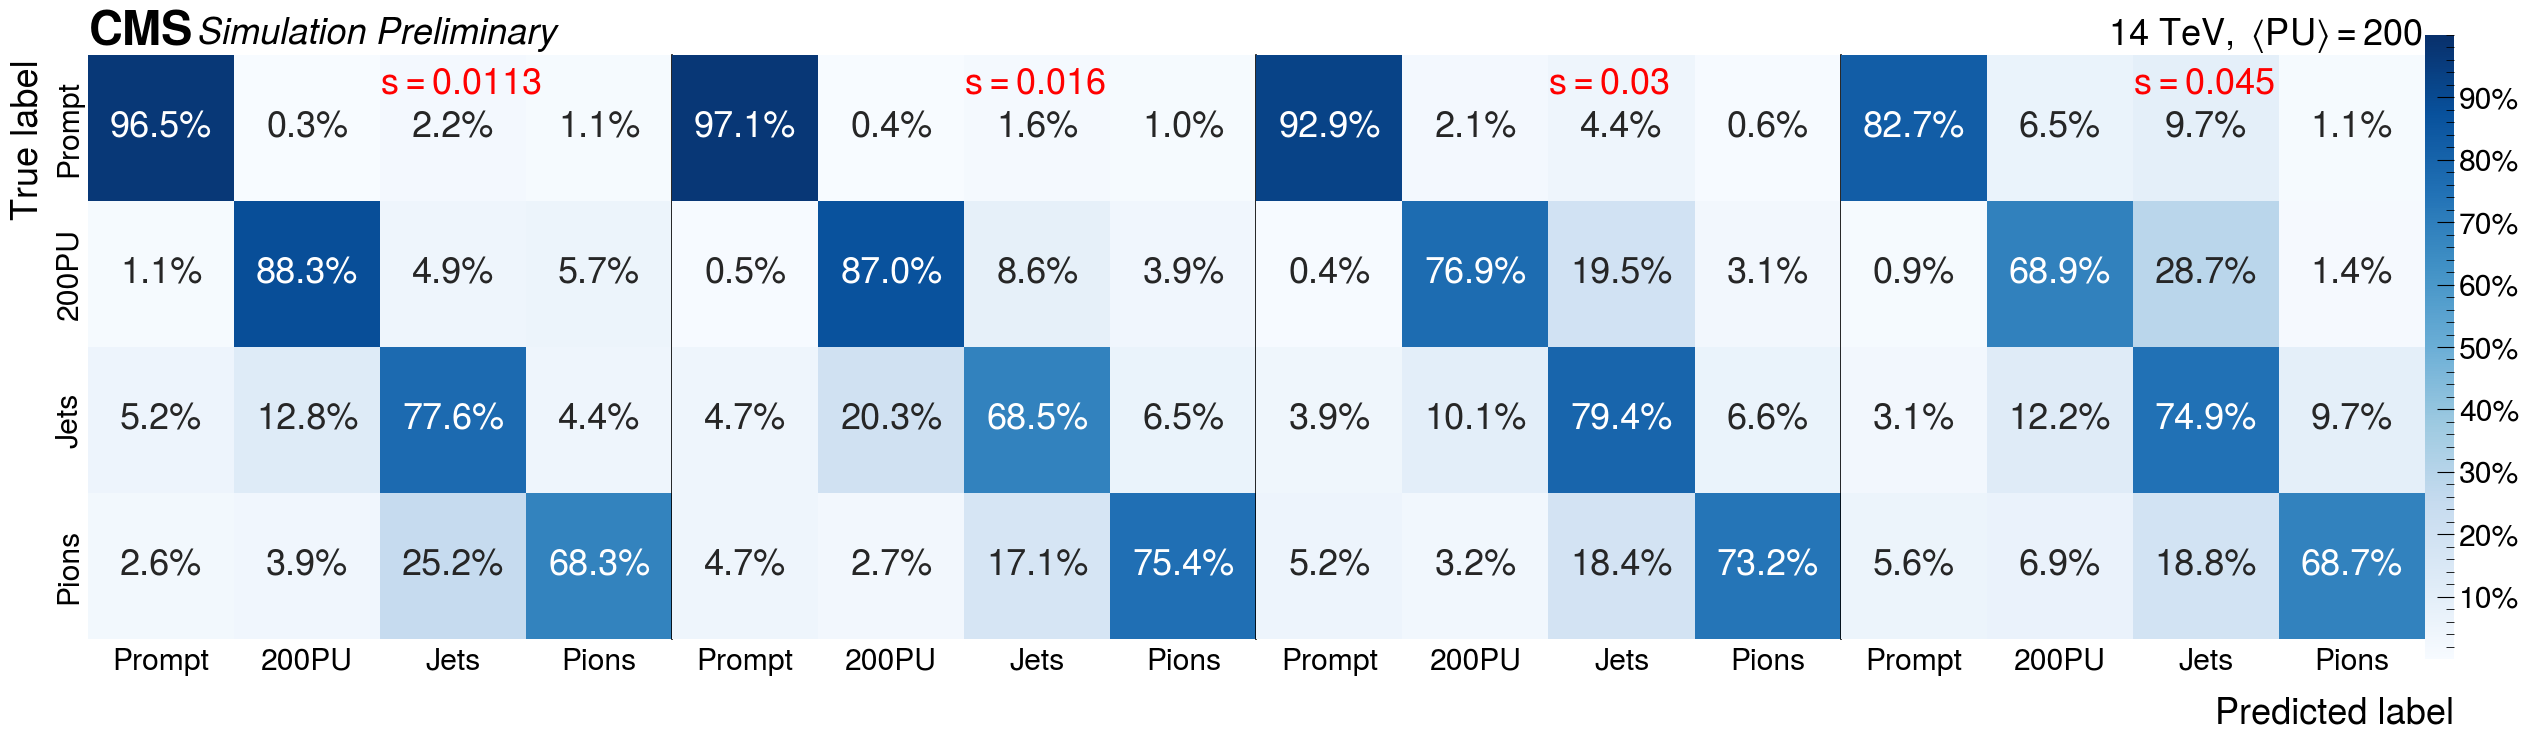

In [24]:
plot_confusion_row_like_cms(
    results,
    outpath="confusion_row.pdf",
    class_names=("Prompt", "200PU", "Jets", "Pions"),
    cms_right=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",
)


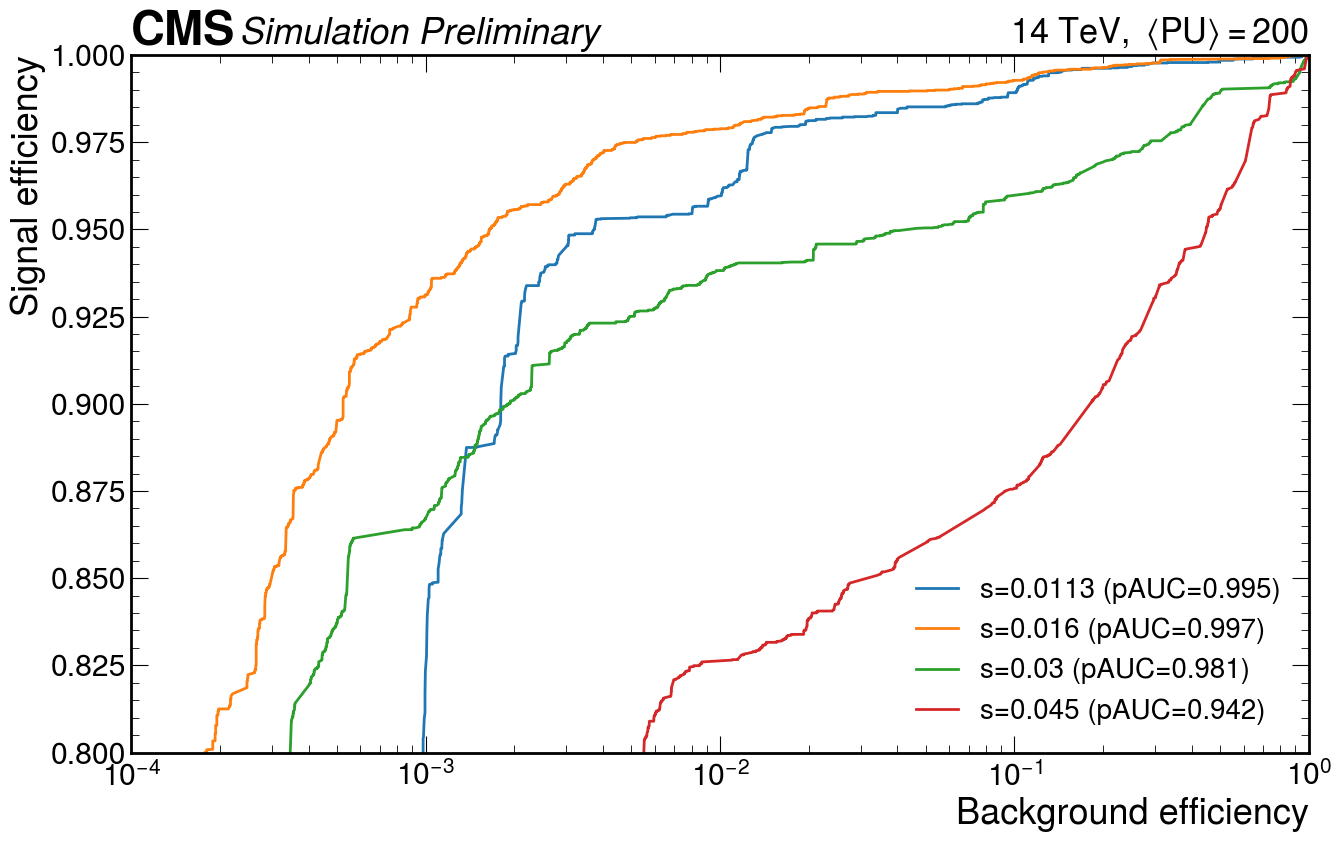

Saved to: triangle_comparison_plots


In [42]:

plot_photon_roc_overlay(
    results,
    outpath=os.path.join(OUTDIR, "roc_photon_vs_rest_overlay.pdf"),
    thr=THR_TPR,
    logx=True,
    logy=False
)

# Save summary table
summary.to_csv(os.path.join(OUTDIR, "triangle_comparison_summary.csv"), index=False)
print("Saved to:", OUTDIR)


In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

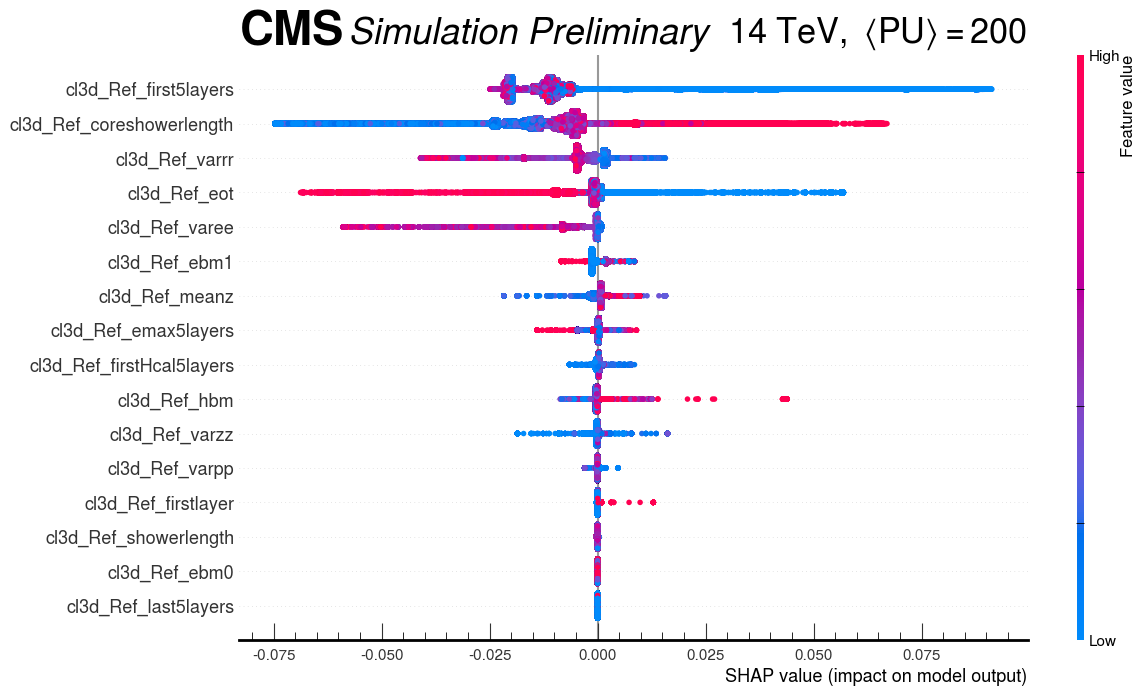

In [32]:
shap_vals_pion = shap_values[:, :, 3]
shap.summary_plot(shap_vals_pion, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(16,7)
mh.cms.label("Preliminary", data=False, rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle = 200$",)
plt.savefig("newsamples_Ref_plots/SHAP_pions.pdf", bbox_inches="tight")
plt.show()

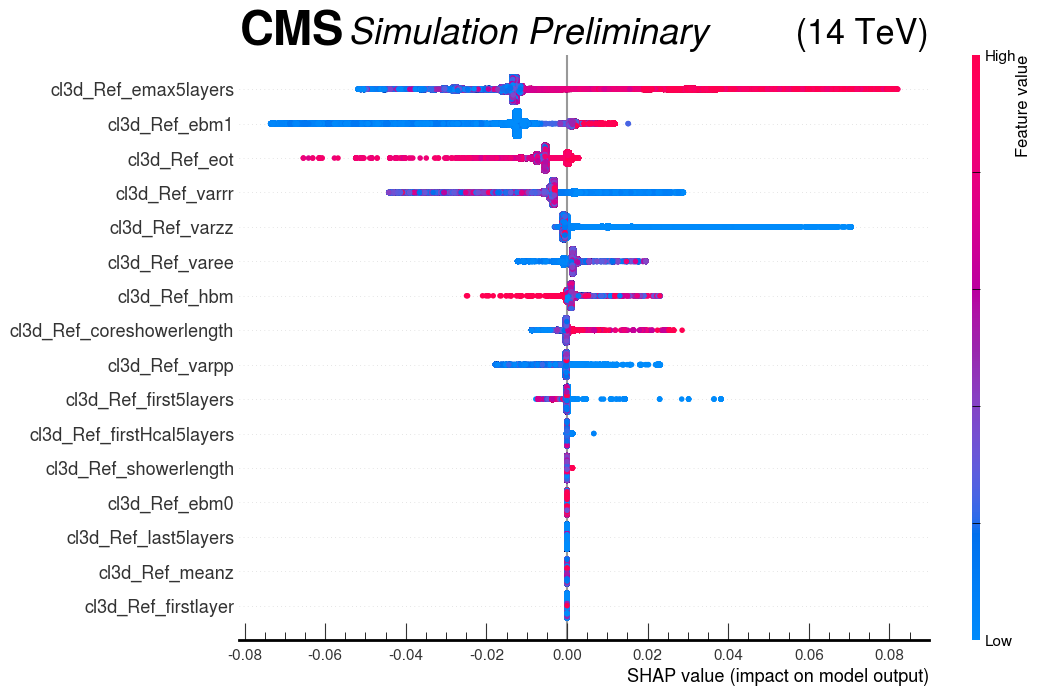

In [153]:
shap_vals_egamma = shap_values[:, :, 0]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(14,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("newsamples_Ref_plots/SHAP_photons.pdf", dpi = 300)
plt.show()

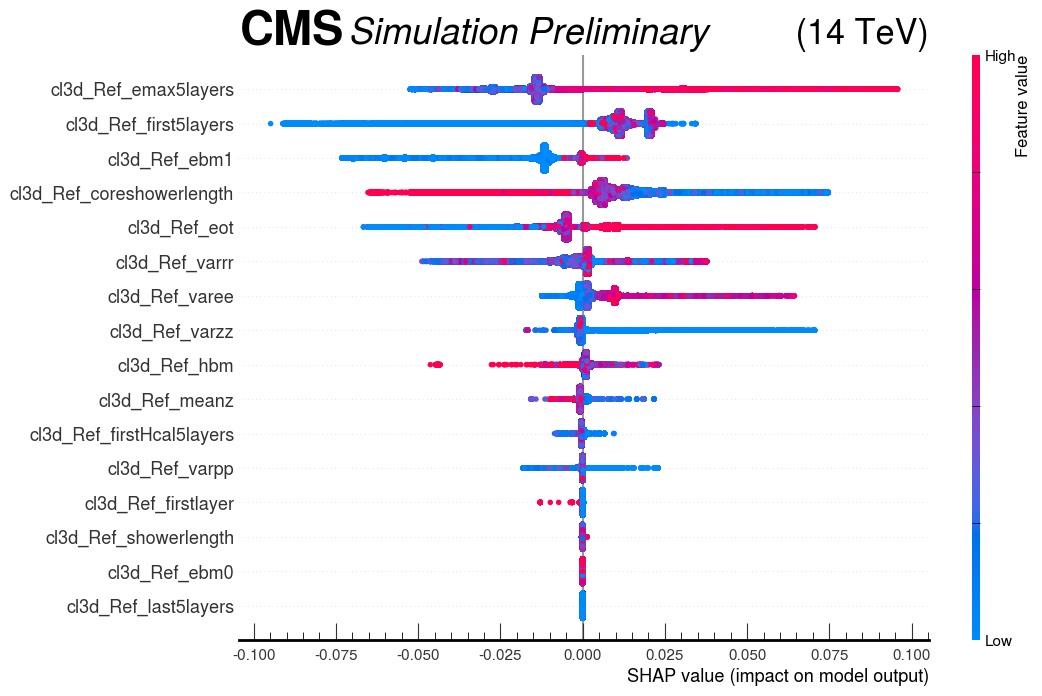

In [154]:
gamma_idx = 0 
pu_idx  = 1
qcd_idx = 2
pion_idx  = 3         
sv_gamma = shap_values[:, :, gamma_idx]
sv_pion  = shap_values[:, :, pion_idx]
sv_delta = sv_gamma - sv_pion
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(14,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("newsamples_Ref_plots/SHAP_gamma_minus_pion.pdf", bbox_inches="tight")
plt.show()


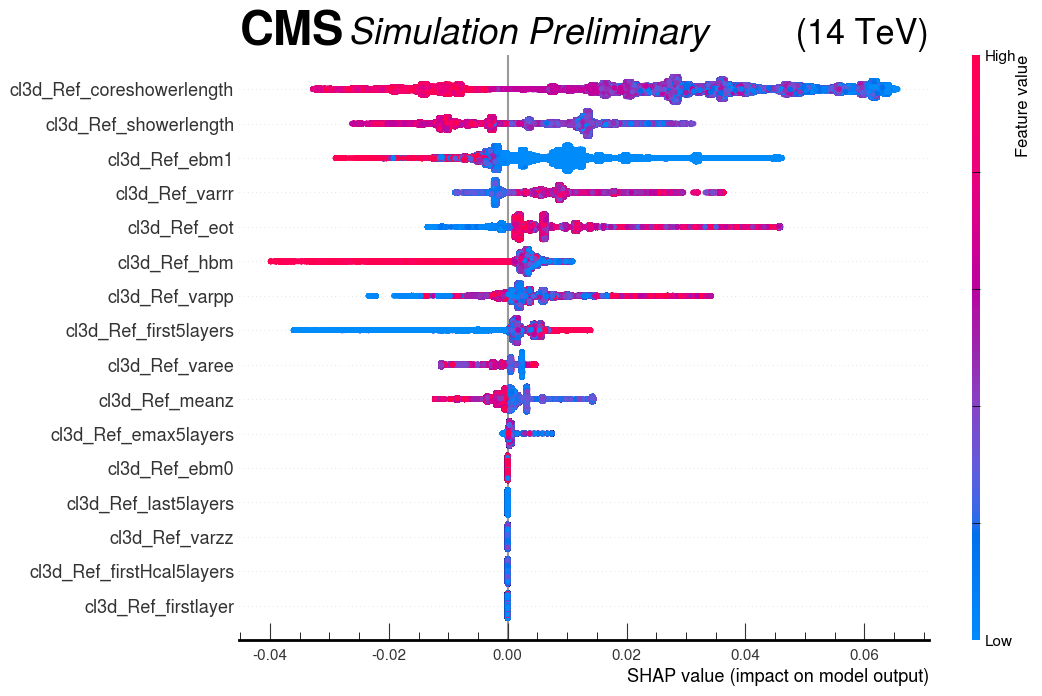

In [155]:
shap_vals_pu = shap_values[:, :, 1]
shap.summary_plot(shap_vals_pu, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(14,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("newsamples_Ref_plots/SHAP_PU200.pdf", dpi = 300)
plt.show()

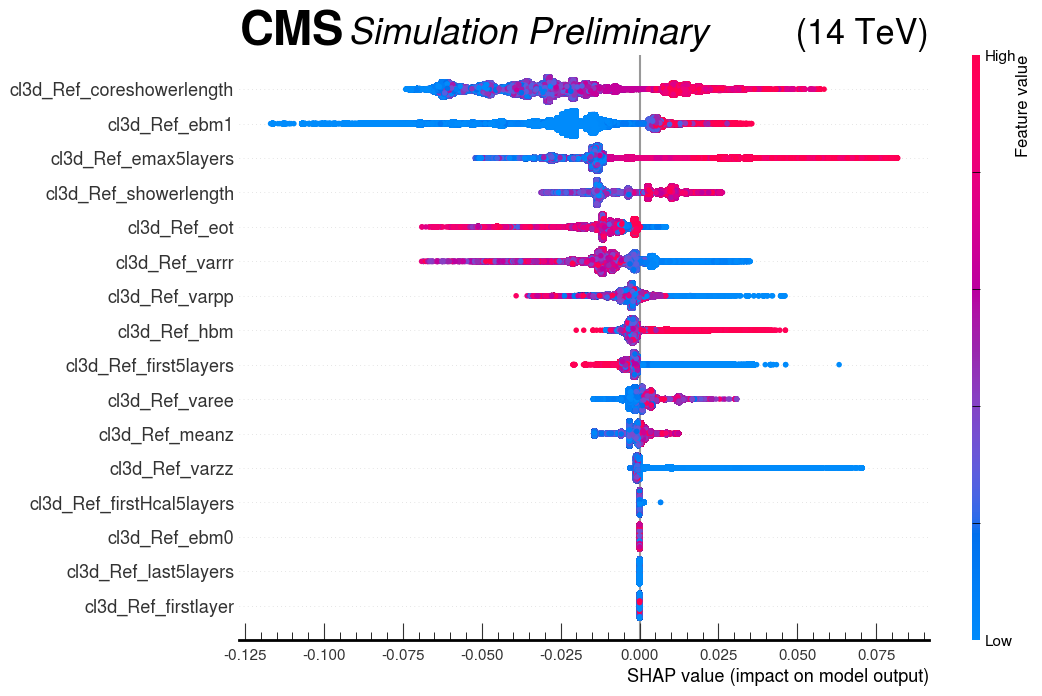

In [156]:
sv_gamma = shap_values[:, :, gamma_idx]
sv_pu  = shap_values[:, :, pu_idx]
sv_delta = sv_gamma - sv_pu
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(14,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("newsamples_Ref_plots/SHAP_gamma_minus_PU200.pdf", bbox_inches="tight")
plt.show()

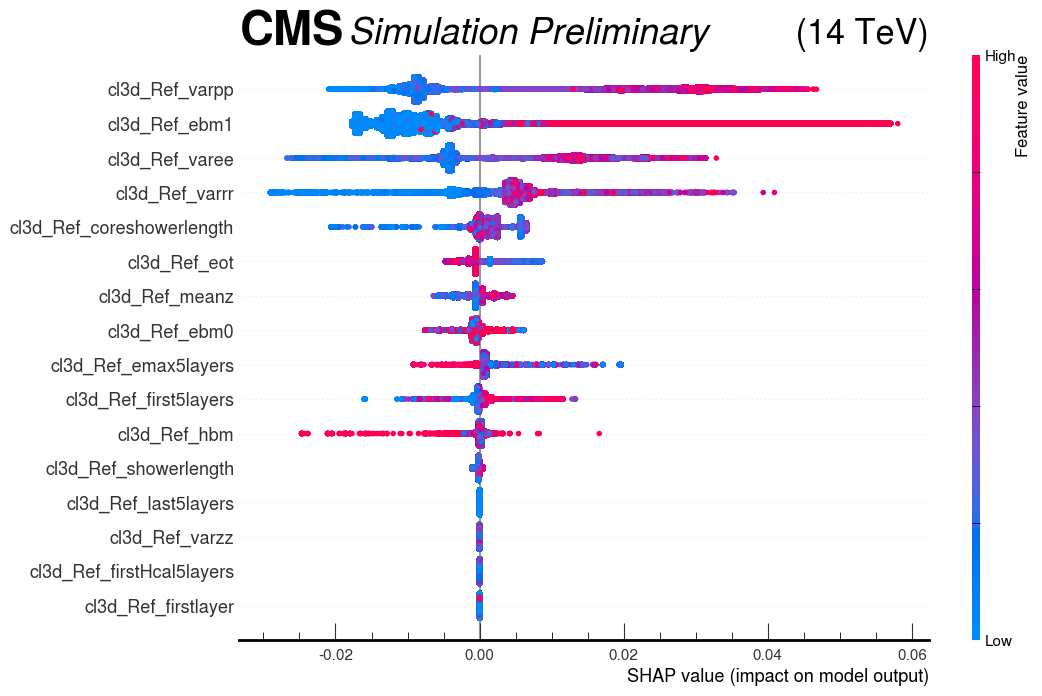

In [157]:
shap_vals_qcd = shap_values[:, :, 2]
shap.summary_plot(shap_vals_qcd, X_test, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(14,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("newsamples_Ref_plots/SHAP_qcd.pdf", dpi = 300)
plt.show()

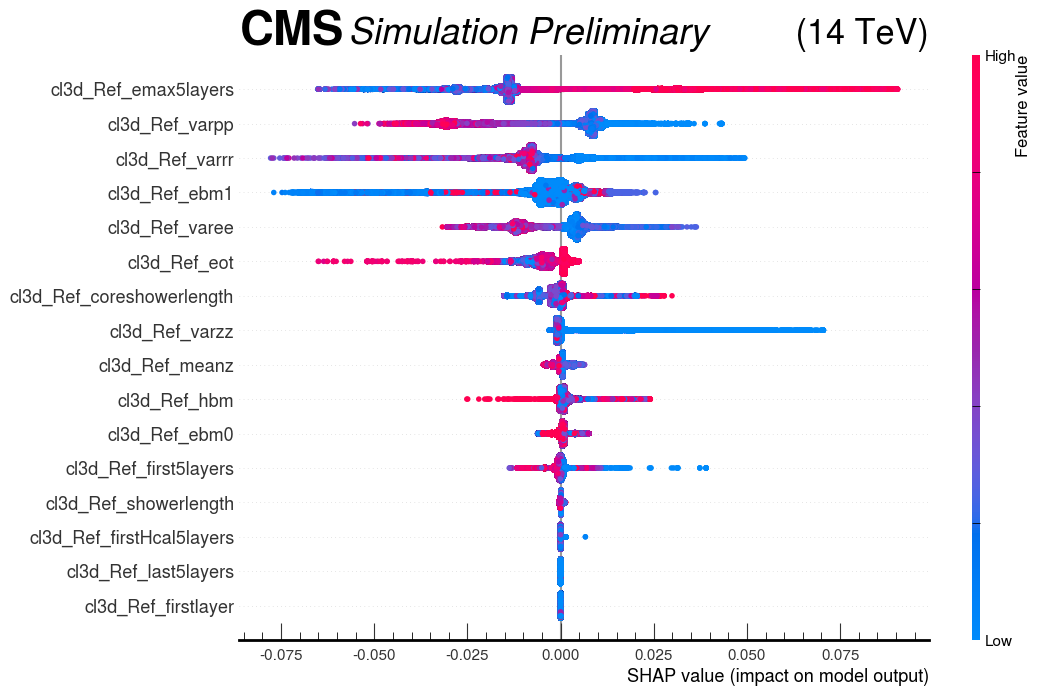

In [158]:
sv_gamma = shap_values[:, :, gamma_idx]
sv_qcd  = shap_values[:, :, qcd_idx]
sv_delta = sv_gamma - sv_qcd
X_plot = X_test
shap.summary_plot(sv_delta, X_plot, feature_names=ana.columns_for_training('Ref'), show=False)
fig = plt.gcf()
fig.set_size_inches(14,7)
mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
plt.savefig("newsamples_Ref_plots/SHAP_gamma_minus_QCD.pdf", bbox_inches="tight")
plt.show()


## Understanding the difference of triangle sizes

## Let's make some plots!

In [82]:
def plot_across_five_lists(
    df_ref, df_p0113, df_p016, df_p03, df_p045,
    vars_ref, vars_p0113, vars_p016, vars_p03, vars_p045,
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plots_triangles", var_latex_map=None, num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None
):
    os.makedirs(plots_dir, exist_ok=True)
    if var_latex_map is None:
        var_latex_map = {}
    suffix_labels = ana.var_map_suffix()
    # Build maps: suffix -> full col name (for each DF)
    def suffix(name): 
        return name.split("_", maxsplit=2)[-1] if name.count("_")>=2 else name

    by_suffix = {"ref":{}, "p0113":{}, "p016":{}, "p03":{}, "p045":{}}
    for c in vars_ref:  by_suffix["ref"][suffix(c)]  = c
    for c in vars_p0113: by_suffix["p0113"][suffix(c)] = c
    for c in vars_p016: by_suffix["p016"][suffix(c)] = c
    for c in vars_p03:  by_suffix["p03"][suffix(c)]  = c
    for c in vars_p045: by_suffix["p045"][suffix(c)] = c

    # Union of all suffixes to try plotting
    all_suffixes = list(dict.fromkeys(
        list(by_suffix["ref"].keys()) +
        list(by_suffix["p0113"].keys()) +
        list(by_suffix["p016"].keys()) +
        list(by_suffix["p03"].keys()) +
        list(by_suffix["p045"].keys())
    ))

    # Helper to get (series, weights) after pT window for a given variant
    def select(df, col, pt_col, wcol):
        if (col not in df.columns) or (pt_col not in df.columns): 
            return pd.Series(dtype=float), None
        m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
        ser = df.loc[m, col].dropna()
        w = (df.loc[m, wcol] if (wcol and wcol in df.columns) else None)
        if w is not None: w = w.loc[ser.index]
        return ser, w

    # Iterate each suffix (i.e., each physics variable)
    for suf in all_suffixes:
        cols = {
            "ref":  by_suffix["ref"].get(suf,  None),
            "p0113": by_suffix["p0113"].get(suf, None),
            "p016": by_suffix["p016"].get(suf, None),
            "p03":  by_suffix["p03"].get(suf,  None),
            "p045": by_suffix["p045"].get(suf, None),
        }

        # Gather data
        s_ref,  w_ref  = select(df_ref,  cols["ref"],  pt_col_ref,  (weight_cols or {}).get("ref"))
        s_p0113, w_p0113 = select(df_p0113, cols["p0113"], pt_col_p0113, (weight_cols or {}).get("p0113"))
        s_p016, w_p016 = select(df_p016, cols["p016"], pt_col_p016, (weight_cols or {}).get("p016"))
        s_p03,  w_p03  = select(df_p03,  cols["p03"],  pt_col_p03,  (weight_cols or {}).get("p03"))
        s_p045, w_p045 = select(df_p045, cols["p045"], pt_col_p045, (weight_cols or {}).get("p045"))

        series_list = [s for s in [s_ref, s_p0113, s_p016, s_p03, s_p045] if not s.empty]
        if not series_list:
            print(f"[skip] No data for '{suf}' after pT filter.")
            continue

        # Binning: integer bins if all are integer-like, else uniform numeric bins
        mins = [s.min() for s in series_list]
        maxs = [s.max() for s in series_list]
        all_int = all(is_integer_dtype(s) for s in series_list)
        gmin, gmax = float(np.min(mins)), float(np.max(maxs))
        if all_int and np.isfinite(gmin) and np.isfinite(gmax):
            bin_edges = np.arange(np.floor(gmin)-0.5, np.ceil(gmax)+1.5, 1.0)
        else:
            if gmin == gmax:
                gmin -= 0.5; gmax += 0.5
            bw = (gmax - gmin) / float(num_bins)
            bin_edges = np.arange(gmin - bw/2, gmax + bw/2 + 1e-12, bw)

        # Plot
        plt.figure(figsize=(10,6))
        if not s_ref.empty:
            plt.hist(s_ref.values,  bins=bin_edges, histtype="step", label=label_ref,  density=density, weights=(w_ref.values if w_ref is not None else None))
        if not s_p0113.empty:
            plt.hist(s_p0113.values, bins=bin_edges, histtype="step", label=label_p0113, density=density, weights=(w_p0113.values if w_p0113 is not None else None))
        if not s_p016.empty:
            plt.hist(s_p016.values, bins=bin_edges, histtype="step", label=label_p016, density=density, weights=(w_p016.values if w_p016 is not None else None))
        if not s_p03.empty:
            plt.hist(s_p03.values,  bins=bin_edges, histtype="step", label=label_p03,  density=density, weights=(w_p03.values if w_p03 is not None else None))
        if not s_p045.empty:
            plt.hist(s_p045.values, bins=bin_edges, histtype="step", label=label_p045, density=density, weights=(w_p045.values if w_p045 is not None else None))

        # Labels
        sample_full = next((c for c in [cols["ref"], cols["p0113"], cols["p016"], cols["p03"], cols["p045"]] if c is not None), None)
        suf_label   = suffix_labels.get(suf)  # e.g. 'pt' -> '$p_T$ [GeV]'
        x_label     = suf_label or (var_latex_map or {}).get(sample_full, suf)
        plt.xlabel(x_label)
        plt.yscale('log')
        plt.ylabel("# Clusters")
        plt.legend(loc='best')
        plt.tight_layout()
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) # ax can be implicit
        out = os.path.join(plots_dir, f"{suf}_across_triangles.pdf")
        plt.savefig(out)
        print(f"Saved: {out}")
        plt.show()
        plt.close()

Saved: plot_triangles_genmatched/pt_across_triangles.pdf


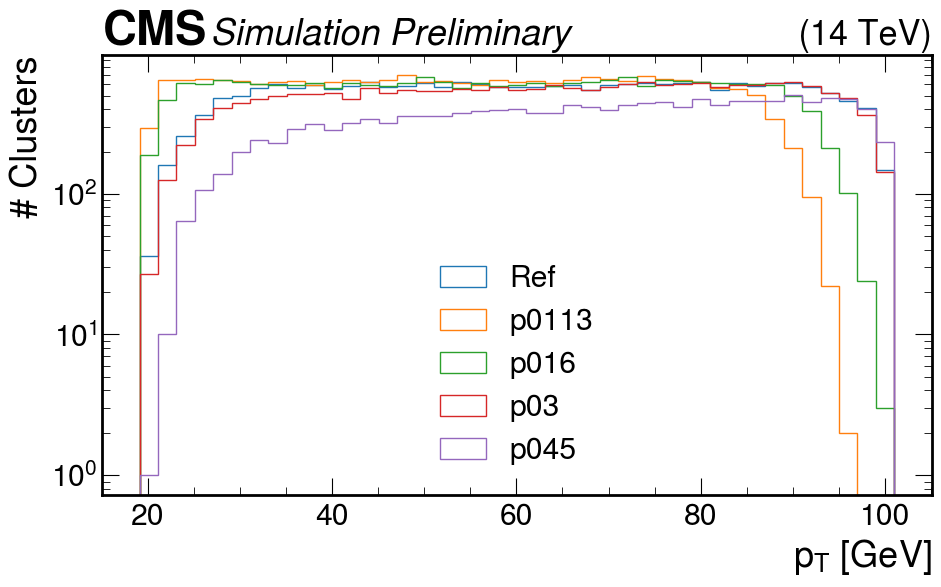

Saved: plot_triangles_genmatched/energy_across_triangles.pdf


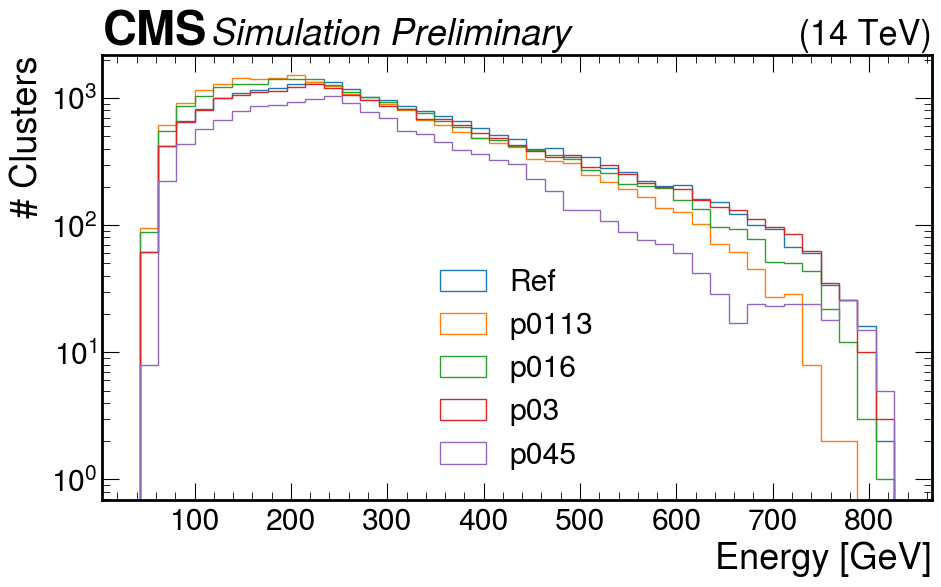

Saved: plot_triangles_genmatched/eta_across_triangles.pdf


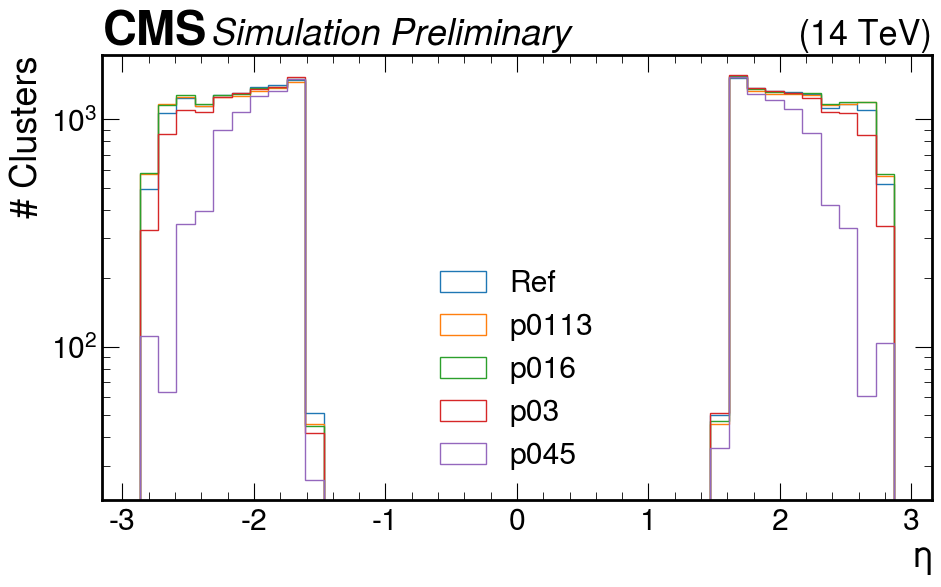

Saved: plot_triangles_genmatched/phi_across_triangles.pdf


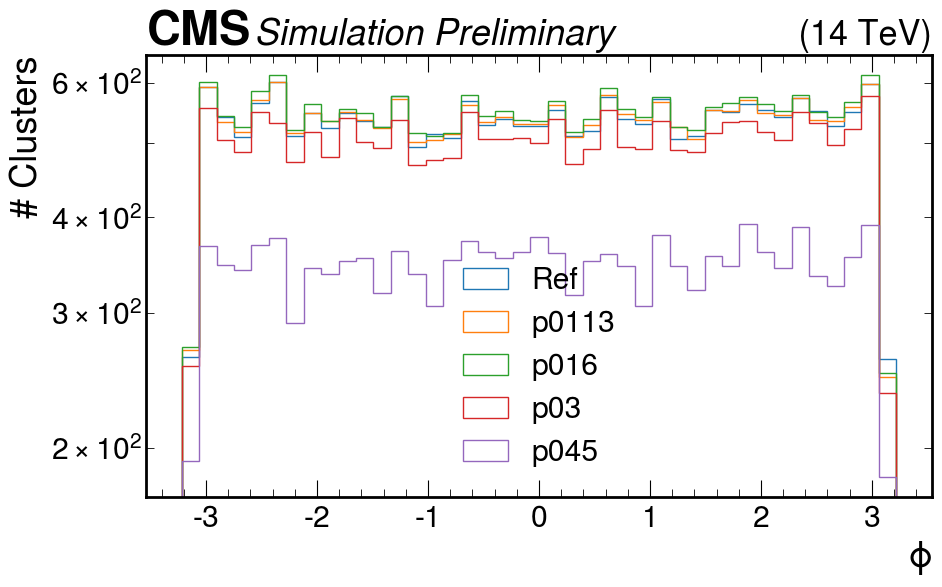

Saved: plot_triangles_genmatched/emax1layers_across_triangles.pdf


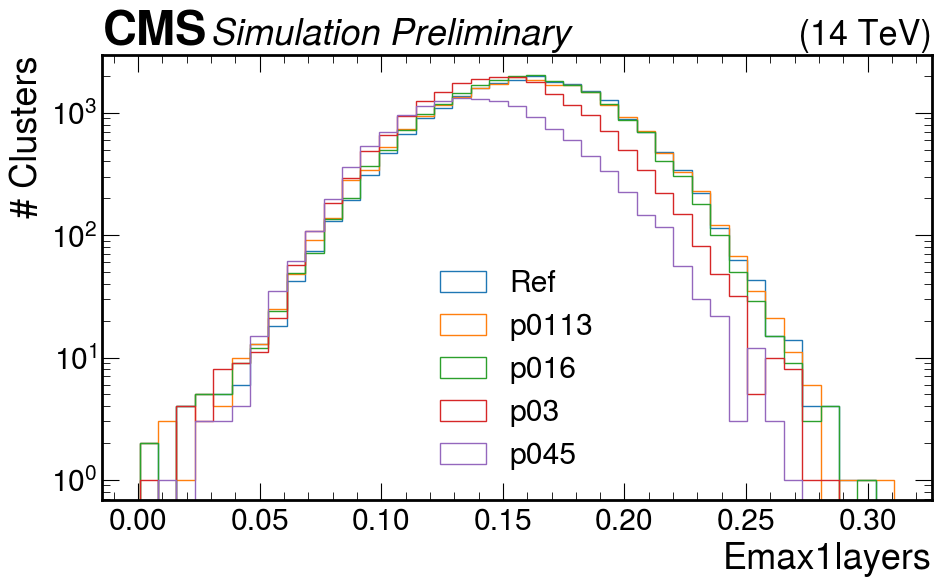

Saved: plot_triangles_genmatched/emax3layers_across_triangles.pdf


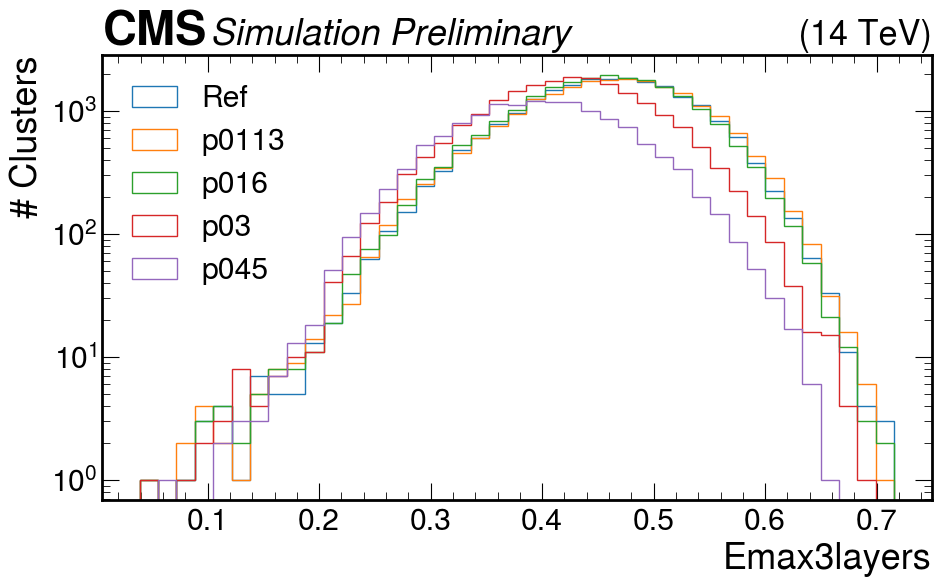

Saved: plot_triangles_genmatched/showerlength_across_triangles.pdf


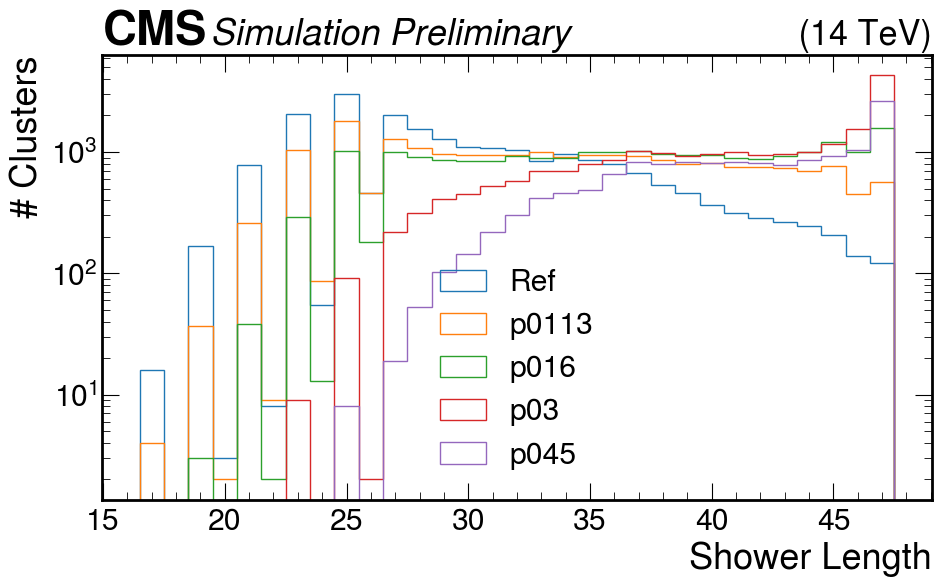

Saved: plot_triangles_genmatched/coreshowerlength_across_triangles.pdf


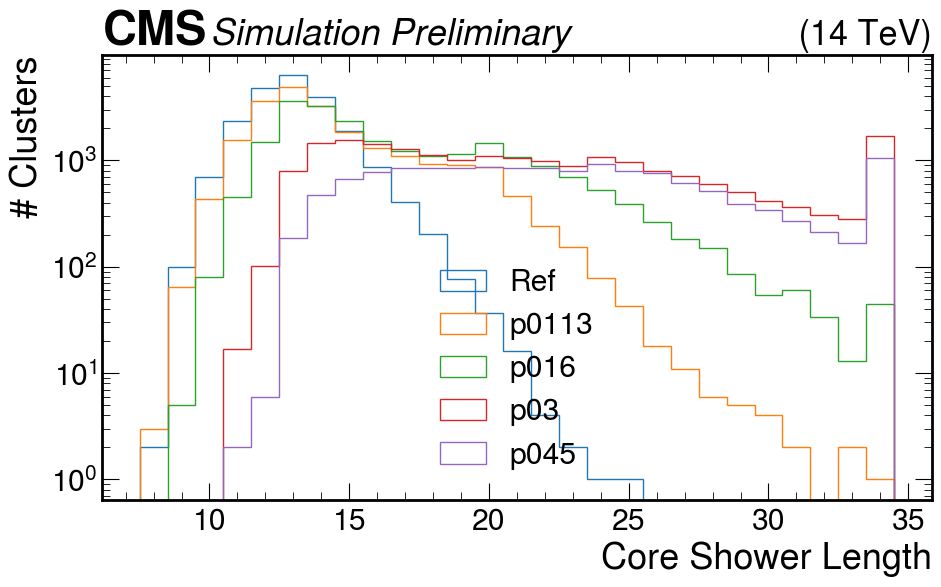

Saved: plot_triangles_genmatched/firstlayer_across_triangles.pdf


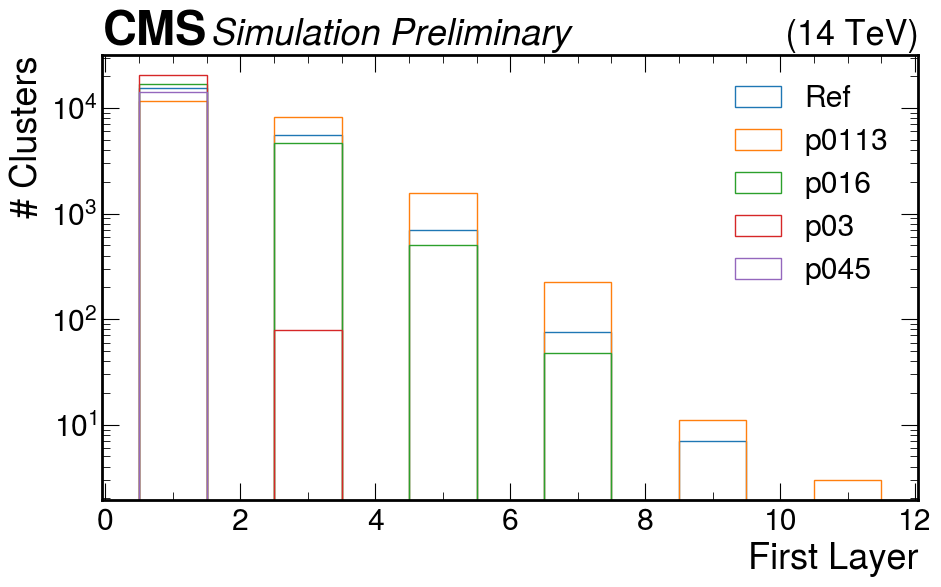

Saved: plot_triangles_genmatched/maxlayer_across_triangles.pdf


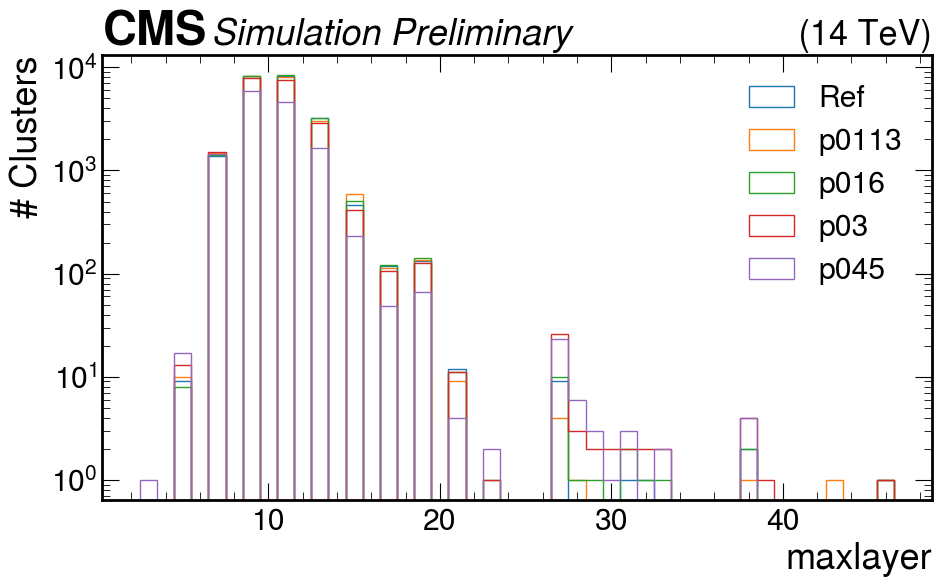

Saved: plot_triangles_genmatched/varrr_across_triangles.pdf


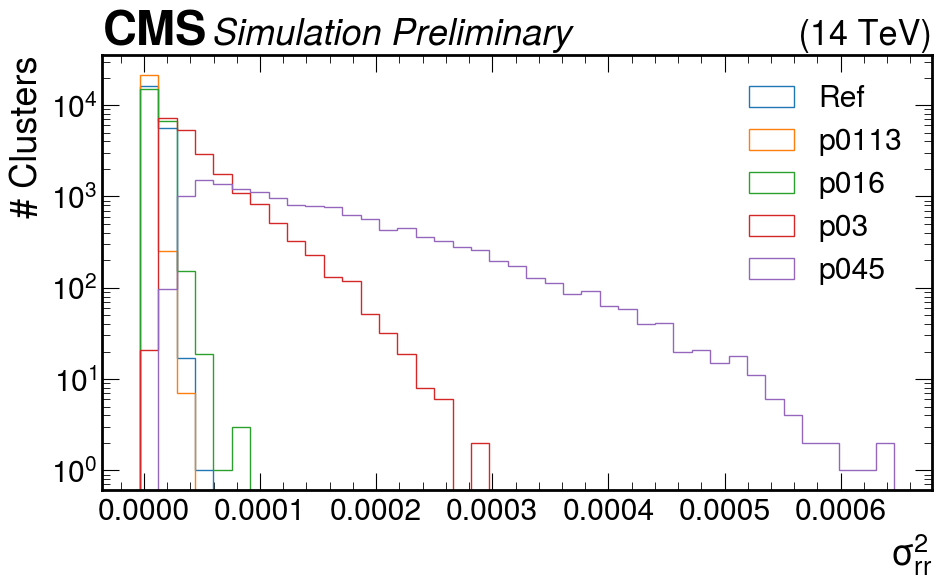

Saved: plot_triangles_genmatched/varzz_across_triangles.pdf


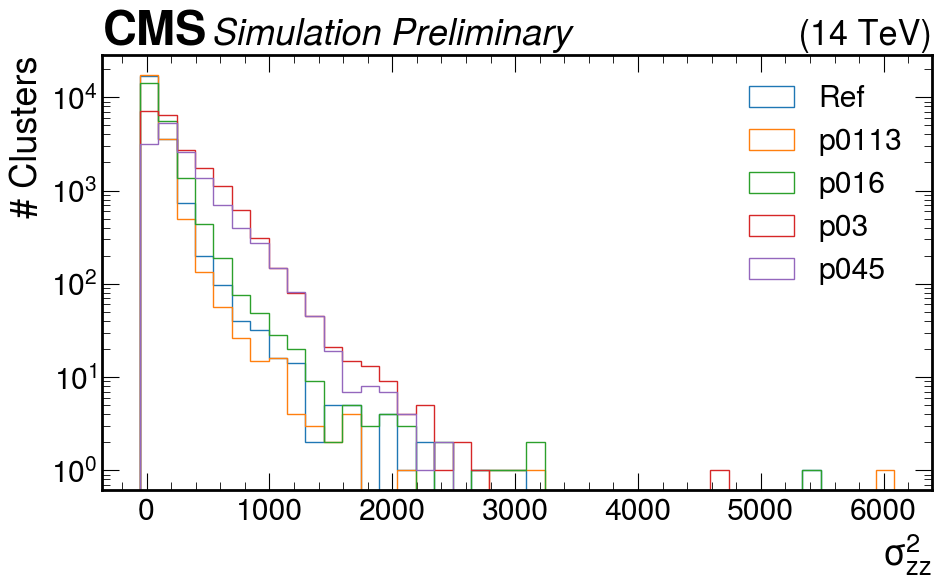

Saved: plot_triangles_genmatched/varee_across_triangles.pdf


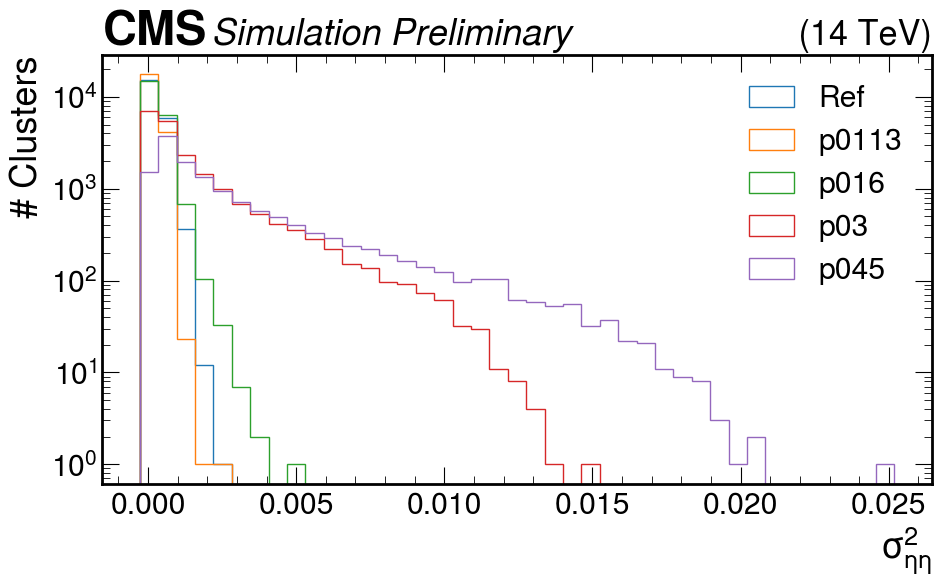

Saved: plot_triangles_genmatched/varpp_across_triangles.pdf


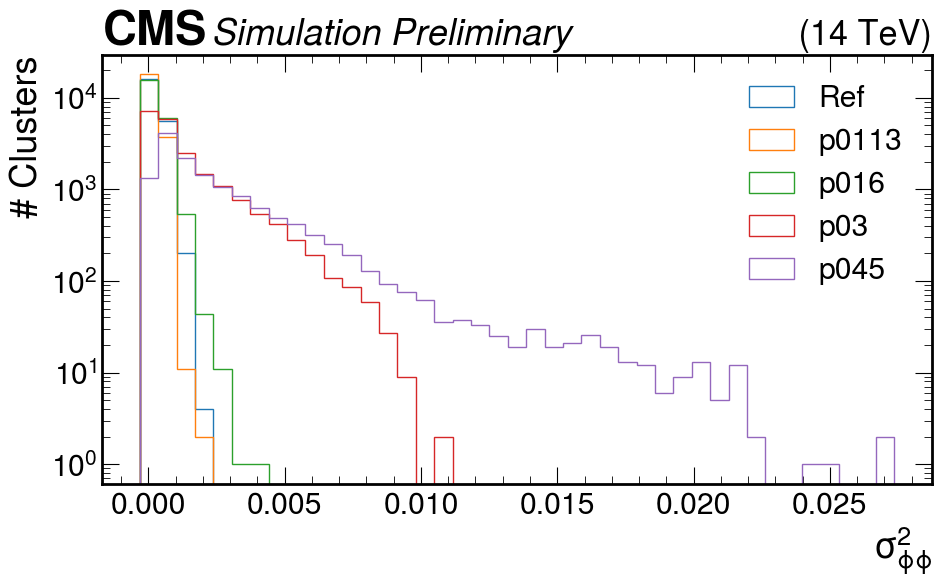

Saved: plot_triangles_genmatched/emaxe_across_triangles.pdf


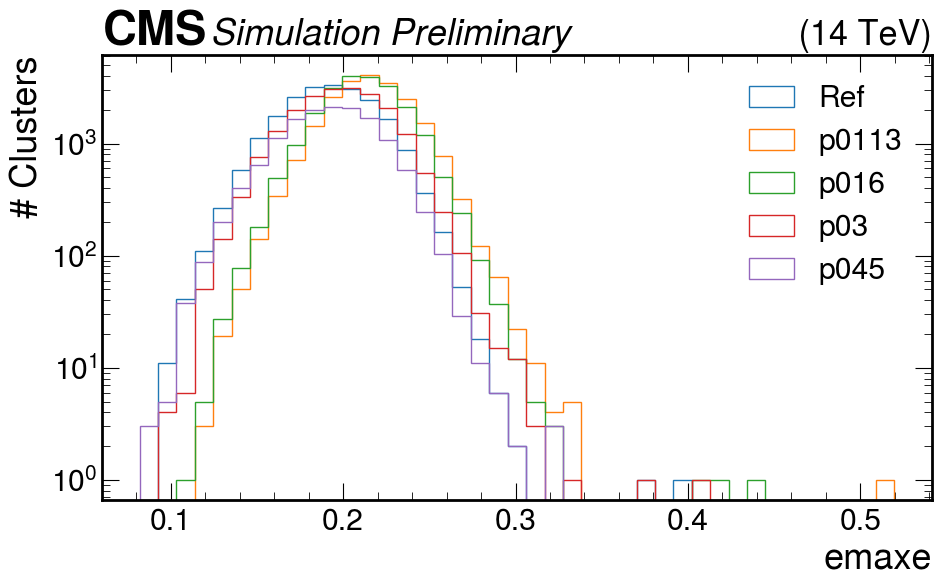

Saved: plot_triangles_genmatched/hoe_across_triangles.pdf


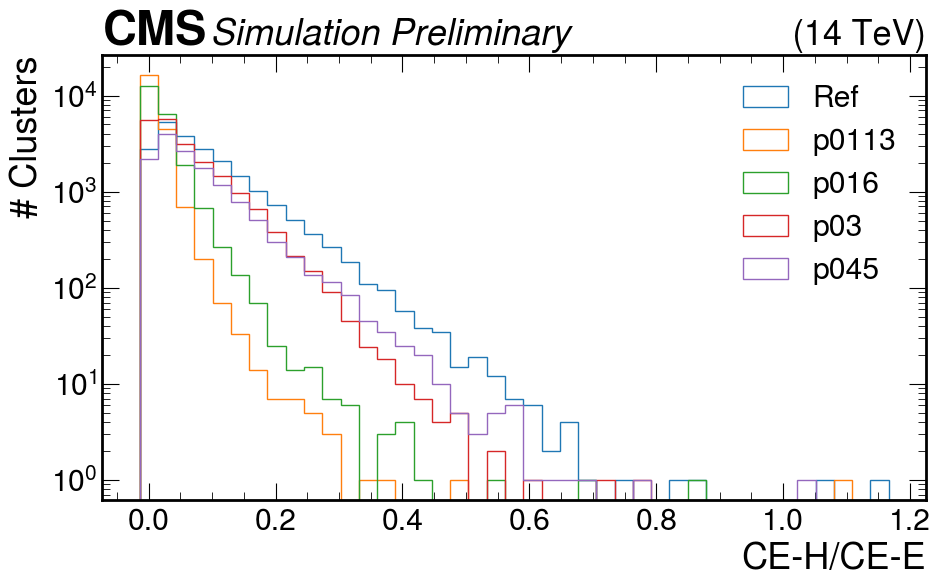

Saved: plot_triangles_genmatched/meanz_across_triangles.pdf


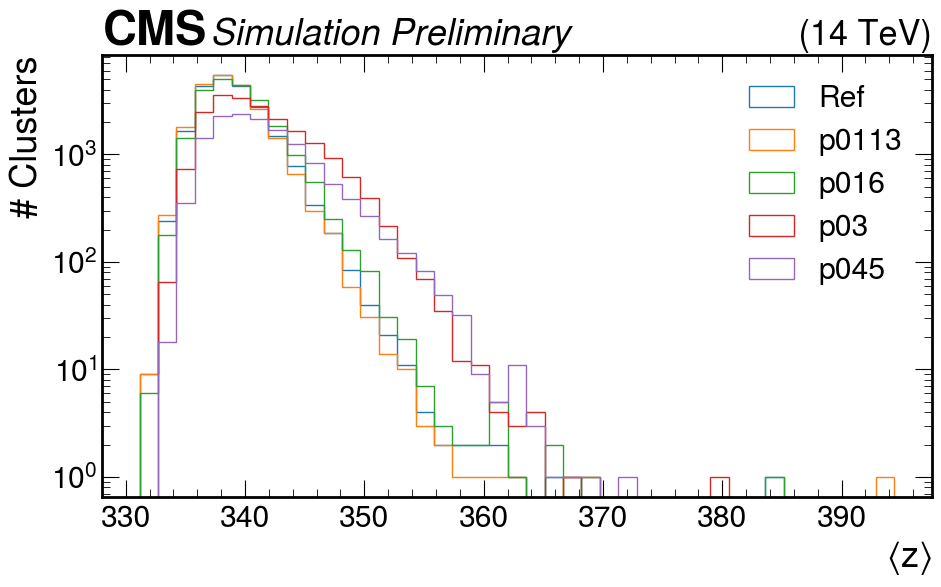

Saved: plot_triangles_genmatched/first1layers_across_triangles.pdf


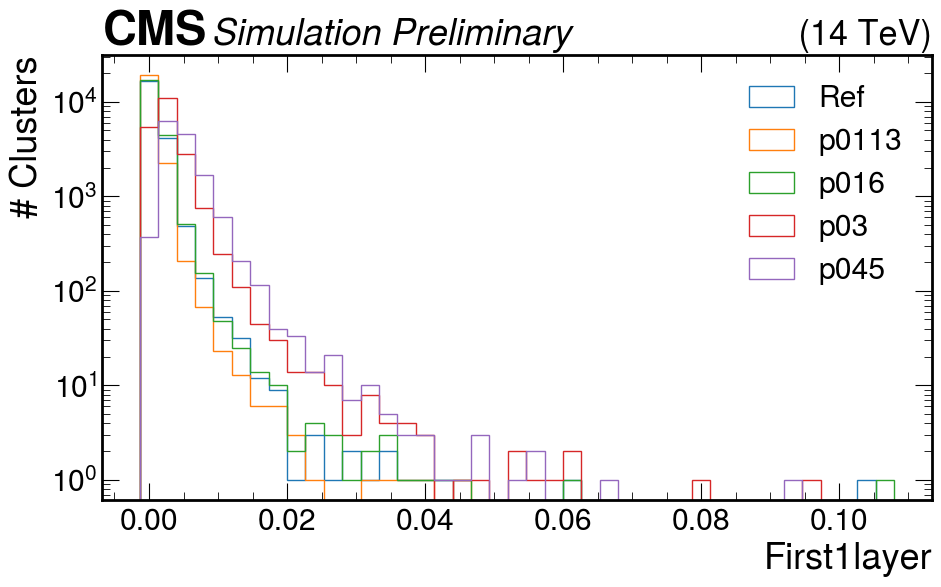

Saved: plot_triangles_genmatched/first3layers_across_triangles.pdf


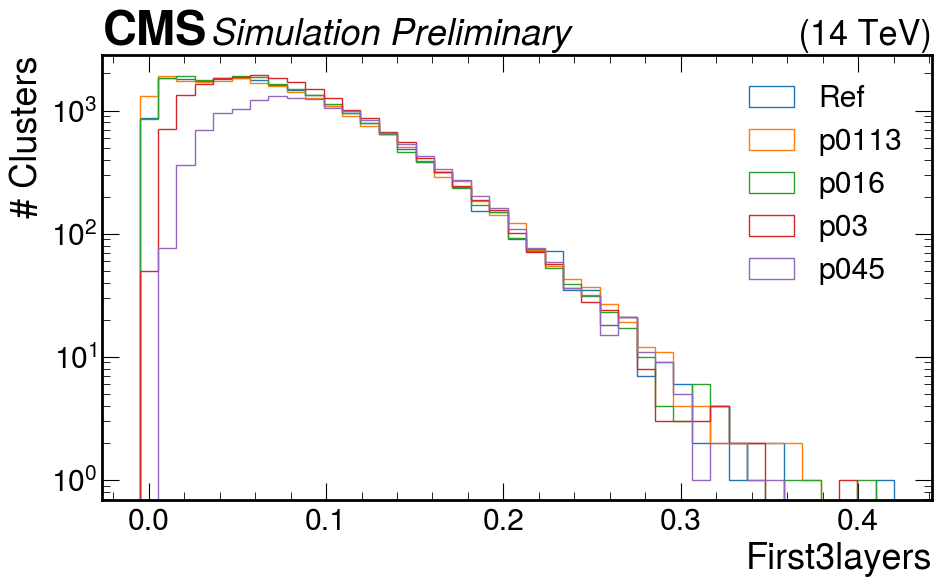

Saved: plot_triangles_genmatched/first5layers_across_triangles.pdf


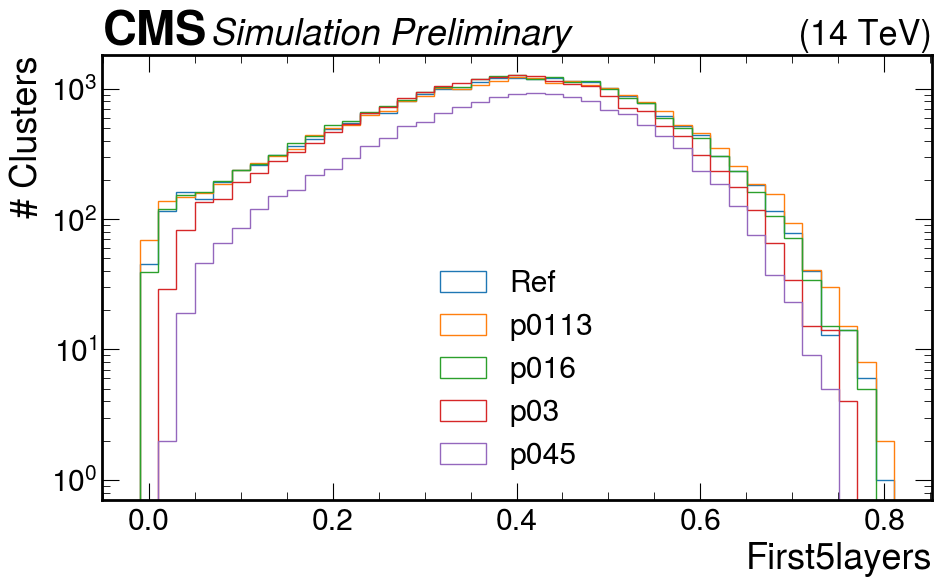

Saved: plot_triangles_genmatched/firstHcal1layers_across_triangles.pdf


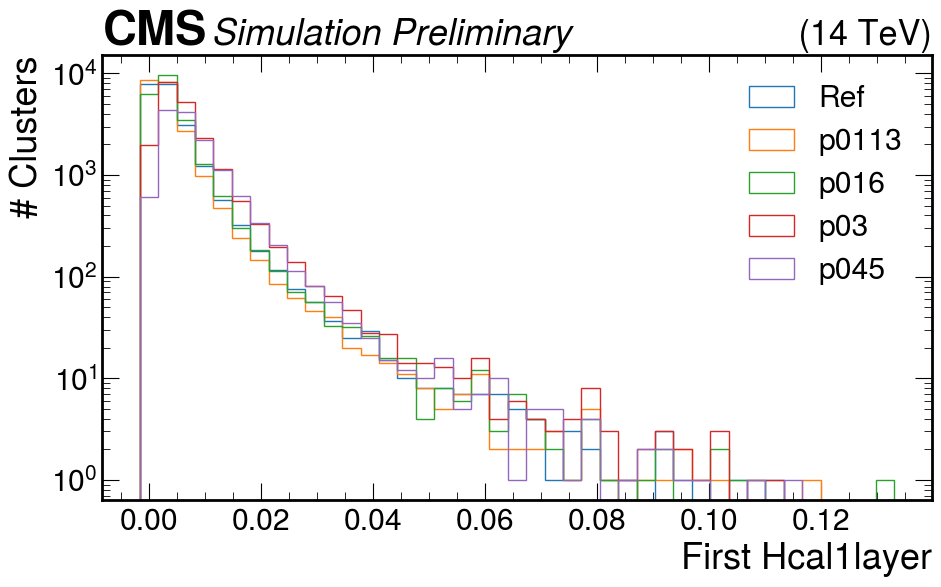

Saved: plot_triangles_genmatched/firstHcal3layers_across_triangles.pdf


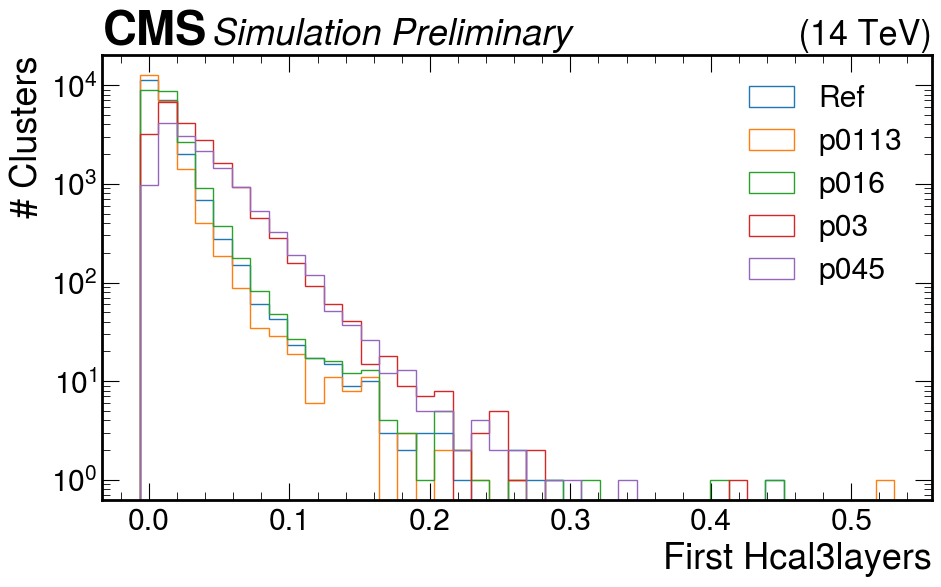

Saved: plot_triangles_genmatched/firstHcal5layers_across_triangles.pdf


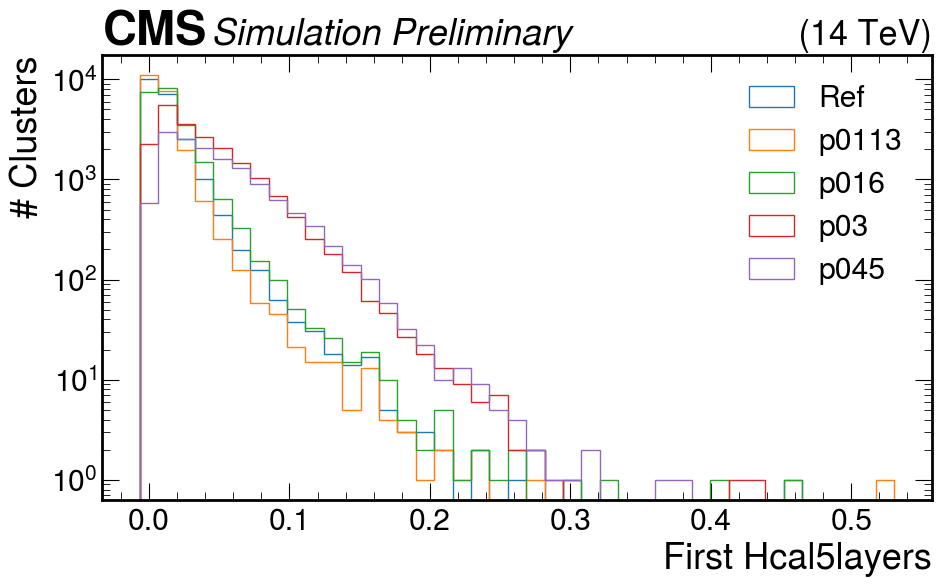

Saved: plot_triangles_genmatched/last1layers_across_triangles.pdf


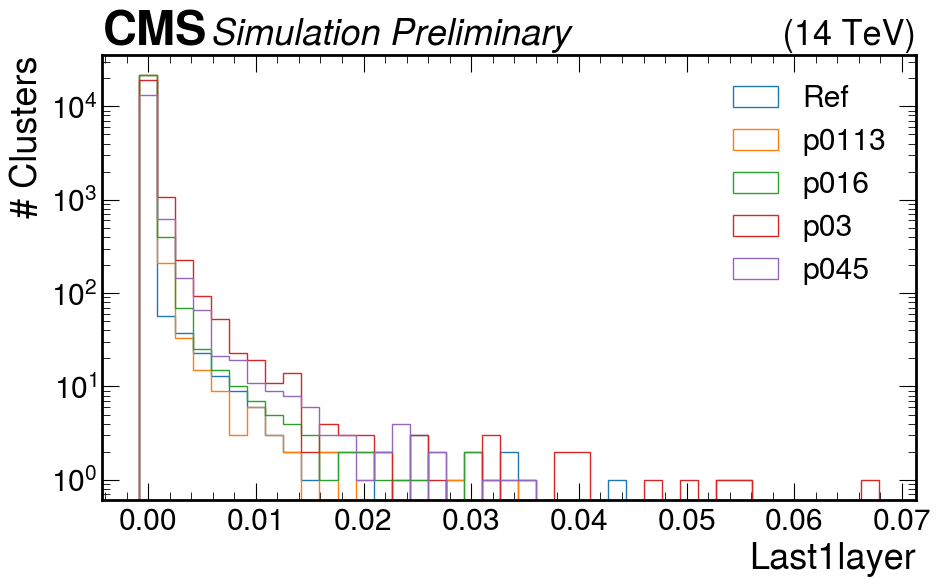

Saved: plot_triangles_genmatched/last3layers_across_triangles.pdf


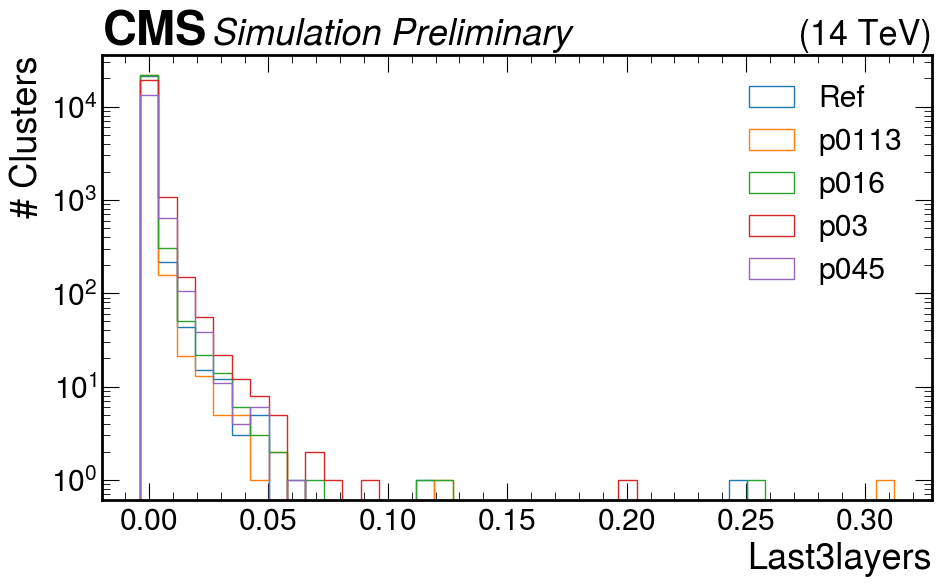

Saved: plot_triangles_genmatched/last5layers_across_triangles.pdf


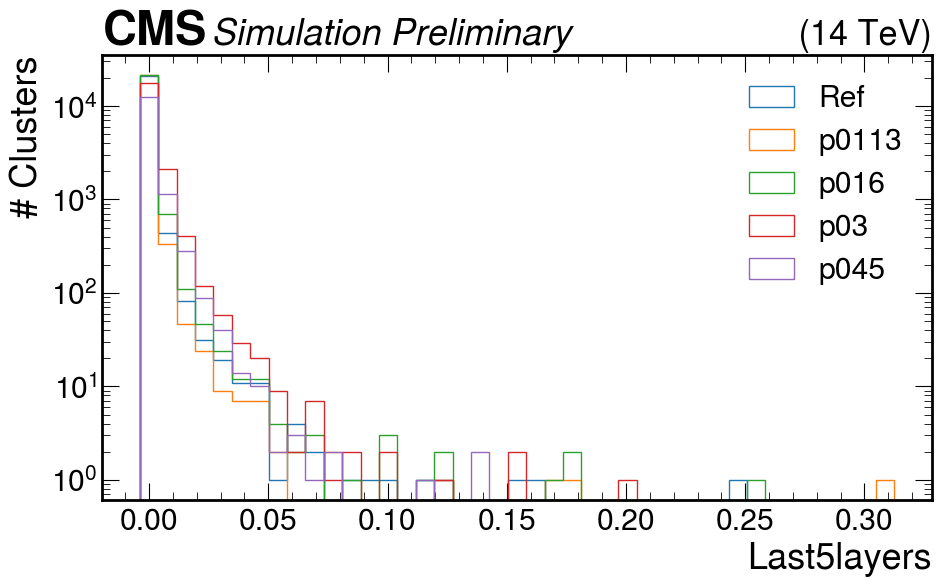

Saved: plot_triangles_genmatched/eot_across_triangles.pdf


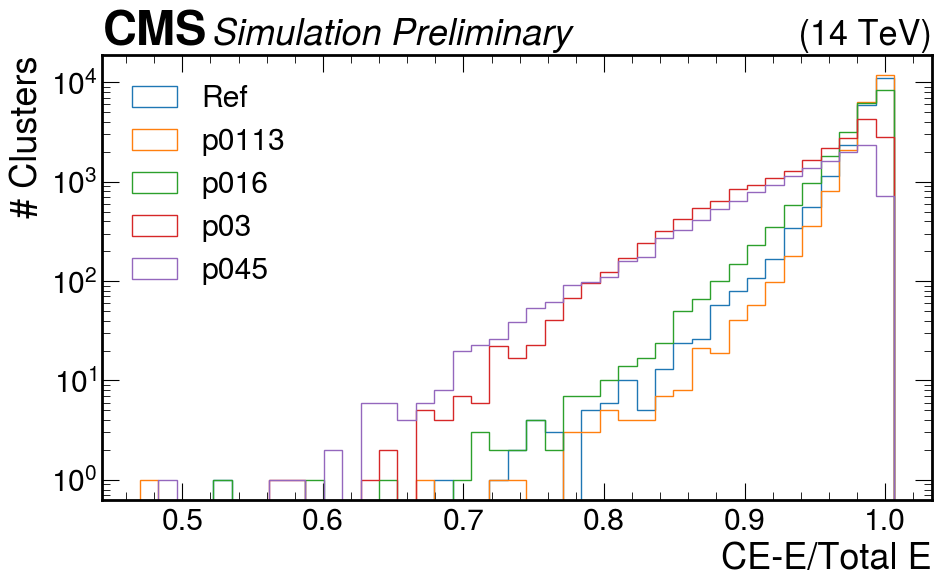

Saved: plot_triangles_genmatched/ebm0_across_triangles.pdf


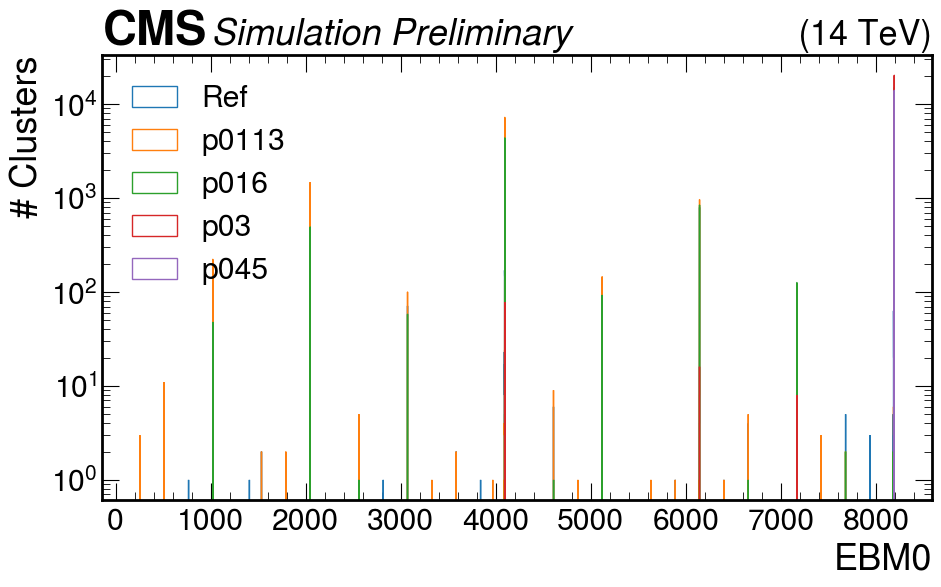

Saved: plot_triangles_genmatched/ebm1_across_triangles.pdf


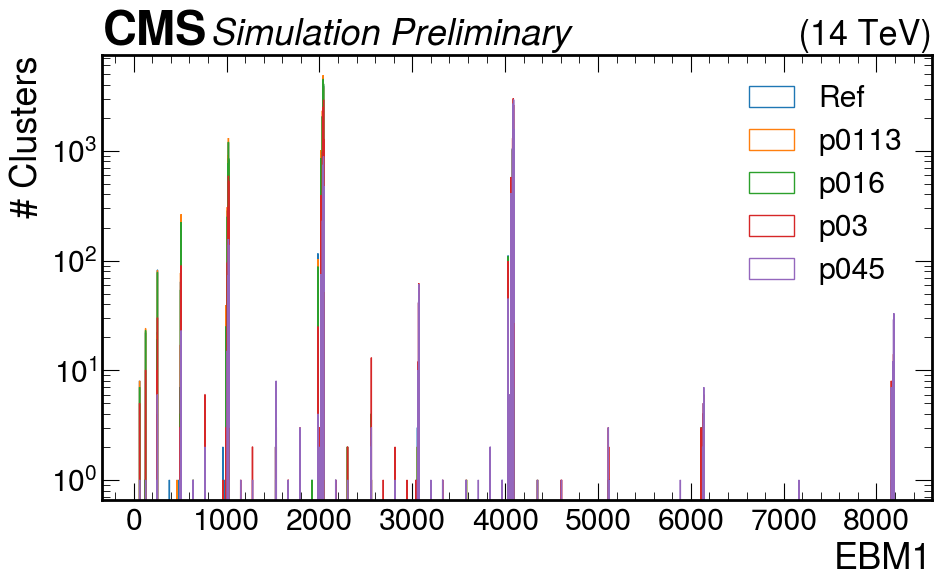

In [93]:
plot_across_five_lists(
    photon_df_Ref_filtered, photon_df_p0113_filtered, photon_df_p016_filtered, photon_df_p03_filtered, photon_df_p045_filtered,
    ana.variables_to_plot('Ref'), ana.variables_to_plot('p0113Tri'), ana.variables_to_plot('p016Tri'), ana.variables_to_plot('p03Tri'), ana.variables_to_plot('p045Tri'),   # full column names per DF
    label_ref="Ref", label_p0113="p0113", label_p016="p016", label_p03="p03", label_p045="p045",
    plots_dir="plot_triangles_genmatched",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 100),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

In [54]:
def plot_histograms(df_signal, df_bg1, df_bg2, df_bg3, variables, label_signal, label_bg1, label_bg2, label_bg3, plots_dir, var_latex_map, prefix, num_bins=40, cl3d_pt_range=(20, 100), figsize=(12, 8)):
    df_signal_filtered = df_signal[(df_signal[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_signal[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    df_bg1_filtered = df_bg1[(df_bg1[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_bg1[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    df_bg2_filtered = df_bg2[(df_bg2[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_bg2[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    df_bg3_filtered = df_bg3[(df_bg3[f'cl3d_{prefix}_pt'] >= cl3d_pt_range[0]) & (df_bg3[f'cl3d_{prefix}_pt'] <= cl3d_pt_range[1])]
    for var in variables:
        plt.figure(figsize=figsize)
        if df_signal_filtered[var].dtype in ['int64', 'int32']:
            min_value = min(df_signal_filtered[var].min(), df_bg1_filtered[var].min(), df_bg2_filtered[var].min(), df_bg3_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg1_filtered[var].max(), df_bg2_filtered[var].max(), df_bg3_filtered[var].max())
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            min_value = min(df_signal_filtered[var].min(), df_bg1_filtered[var].min(), df_bg2_filtered[var].min(), df_bg3_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg1_filtered[var].max(), df_bg2_filtered[var].max(), df_bg3_filtered[var].max())
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)
        plt.hist(df_signal_filtered[var], histtype='step', bins=bin_edges, color='b', linewidth=1.5, label=label_signal, density=True)
        plt.hist(df_bg1_filtered[var], histtype='step', bins=bin_edges, color='g', linewidth=1.5, label=label_bg1, density=True)
        plt.hist(df_bg2_filtered[var], histtype='step', bins=bin_edges, color='r', linewidth=1.5, label=label_bg2, density=True)
        plt.hist(df_bg3_filtered[var], histtype='step', bins=bin_edges, color='black', linewidth=1.5, label=label_bg3, density=True)
        plt.xlabel(var_latex_map.get(var, var))
        plt.ylabel('# events (normalised)')
        plt.legend()
        plt.tight_layout(rect=[0, 0, 1, 0.92])
        fig = plt.gcf()
        mh.cms.label("Preliminary", data=False, com=14) 
        filename = os.path.join(plots_dir, f"{var}_histogram.pdf")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

Saved: newsamples_Ref_plots/cl3d_Ref_pt_histogram.pdf


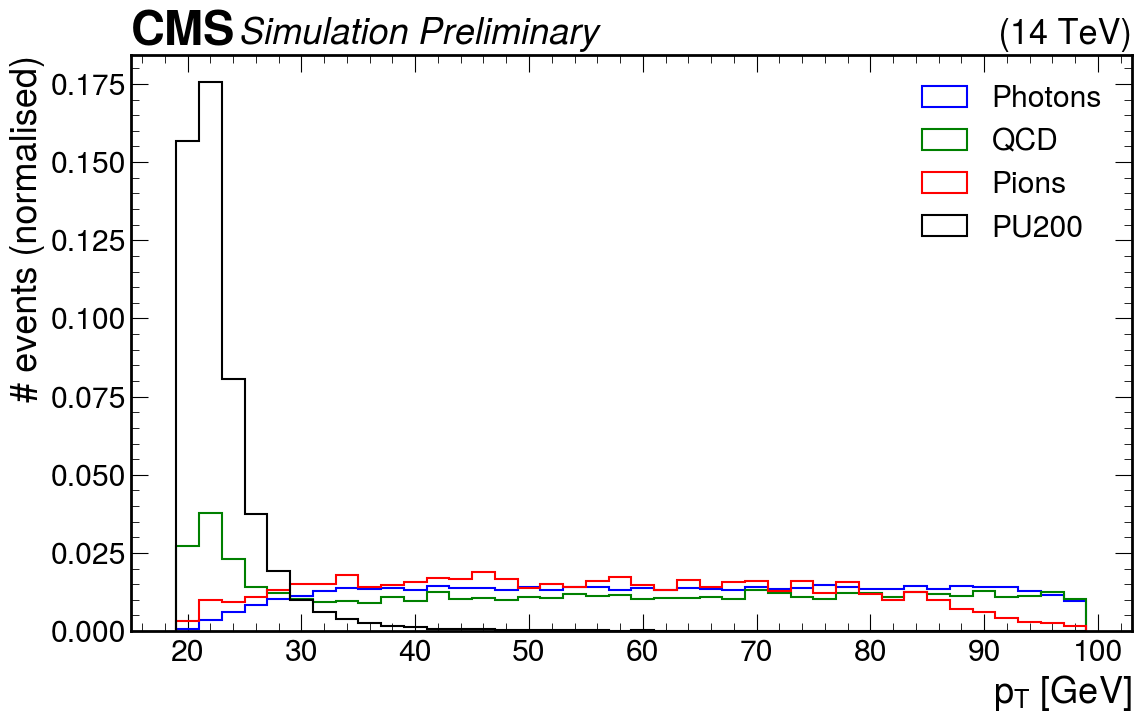

Saved: newsamples_Ref_plots/cl3d_Ref_energy_histogram.pdf


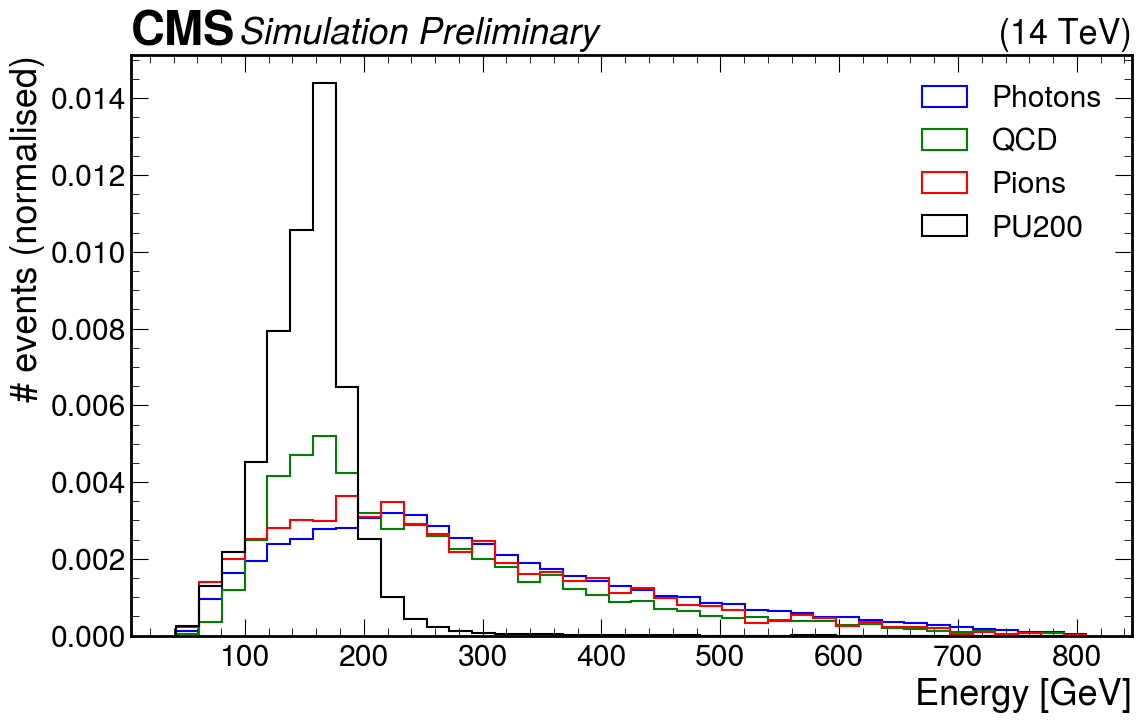

Saved: newsamples_Ref_plots/cl3d_Ref_eta_histogram.pdf


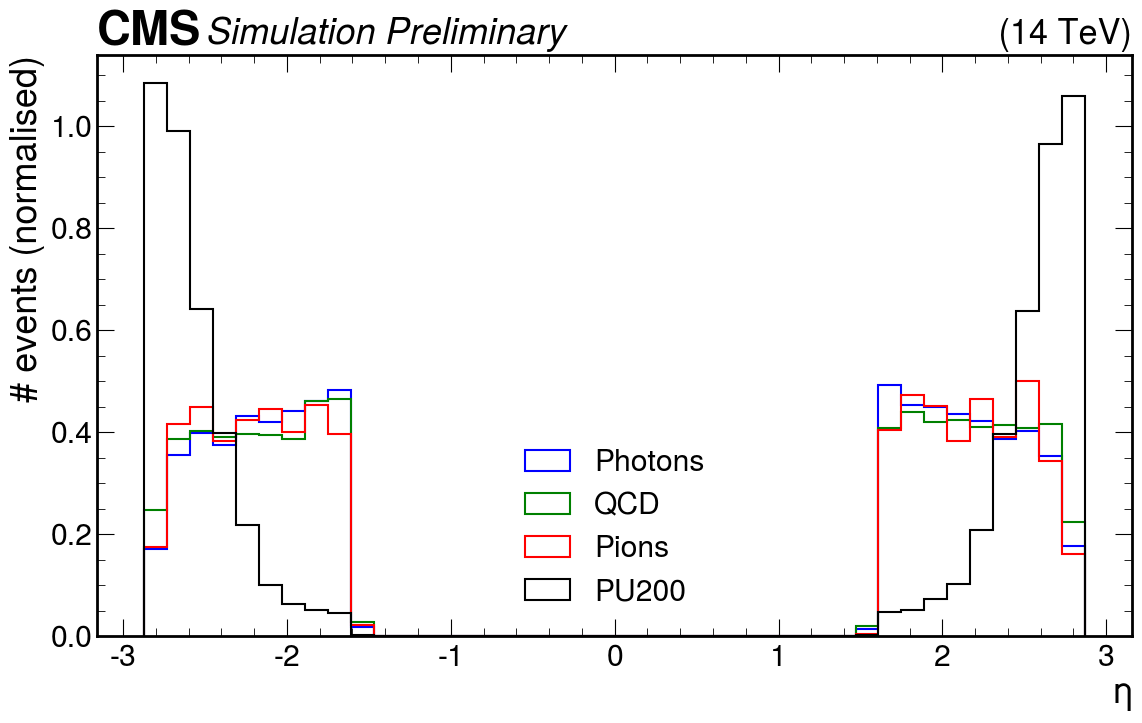

Saved: newsamples_Ref_plots/cl3d_Ref_phi_histogram.pdf


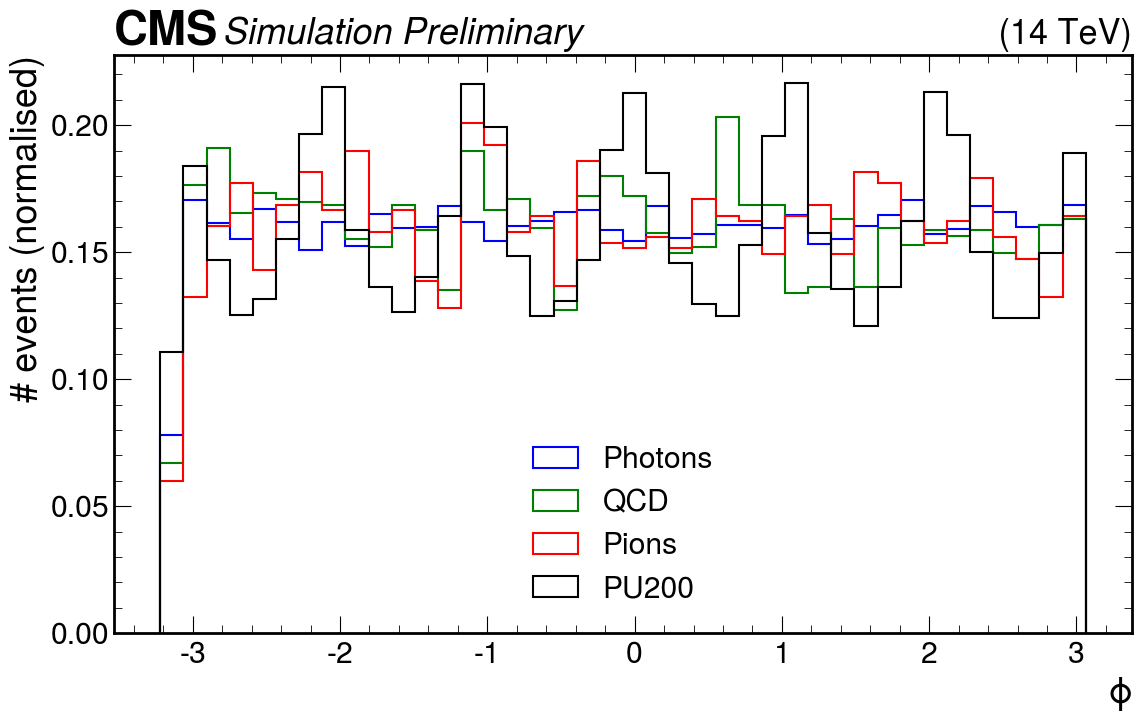

Saved: newsamples_Ref_plots/cl3d_Ref_emax1layers_histogram.pdf


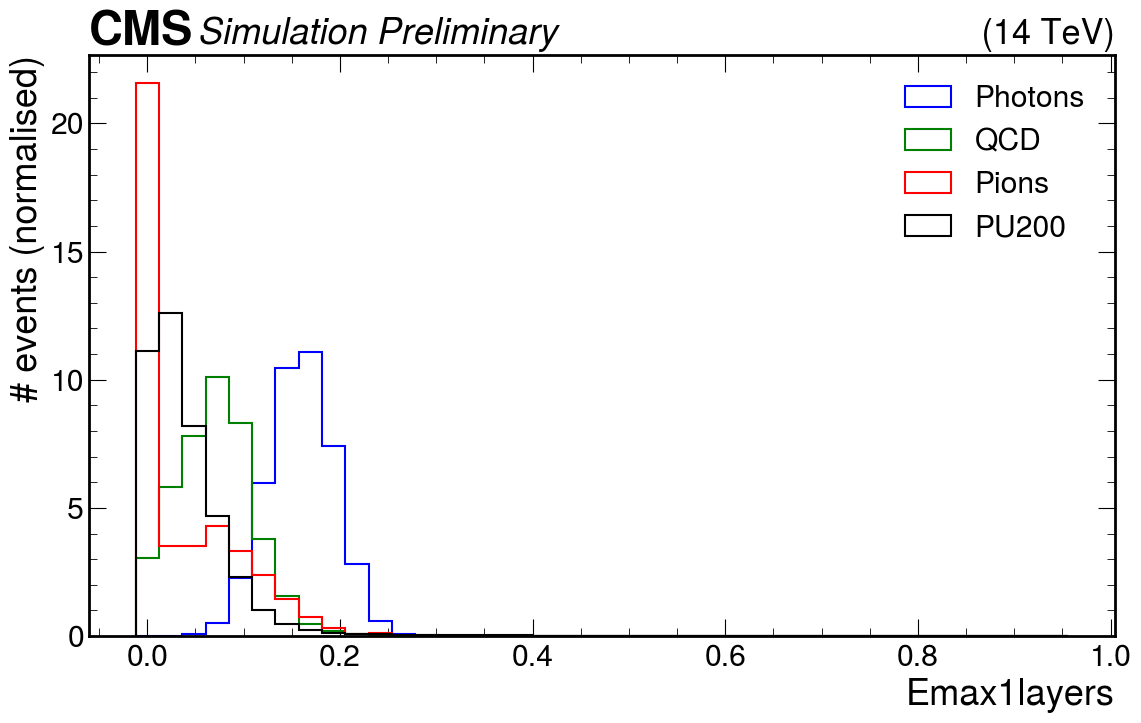

Saved: newsamples_Ref_plots/cl3d_Ref_emax3layers_histogram.pdf


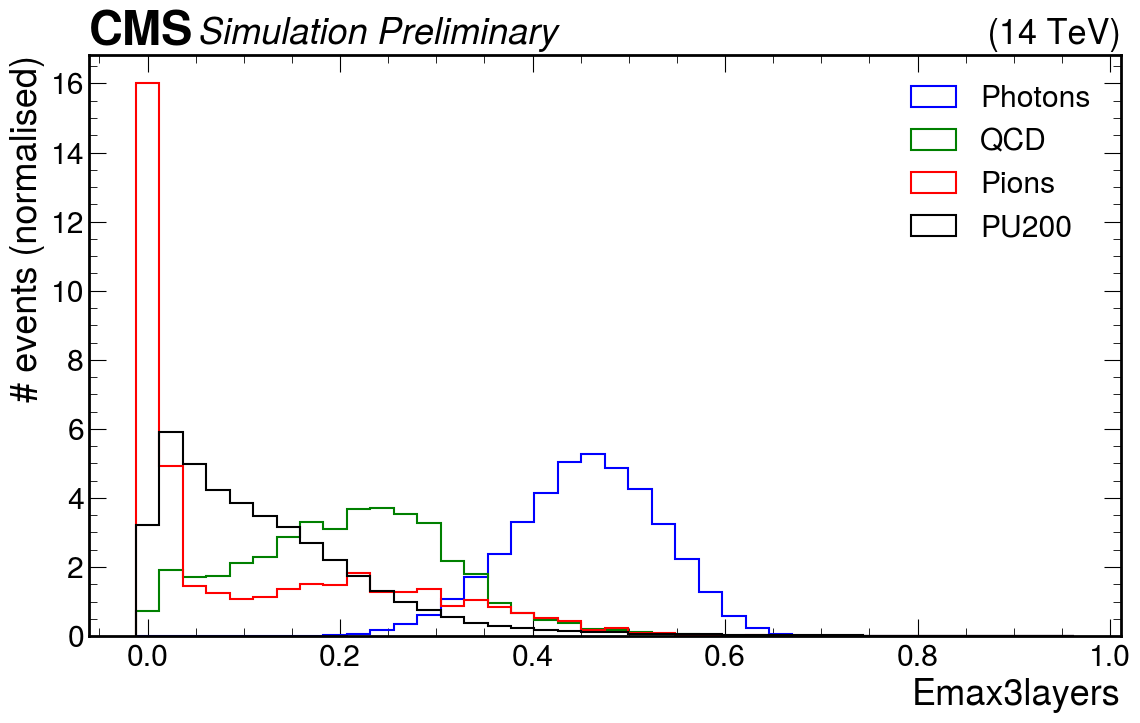

Saved: newsamples_Ref_plots/cl3d_Ref_showerlength_histogram.pdf


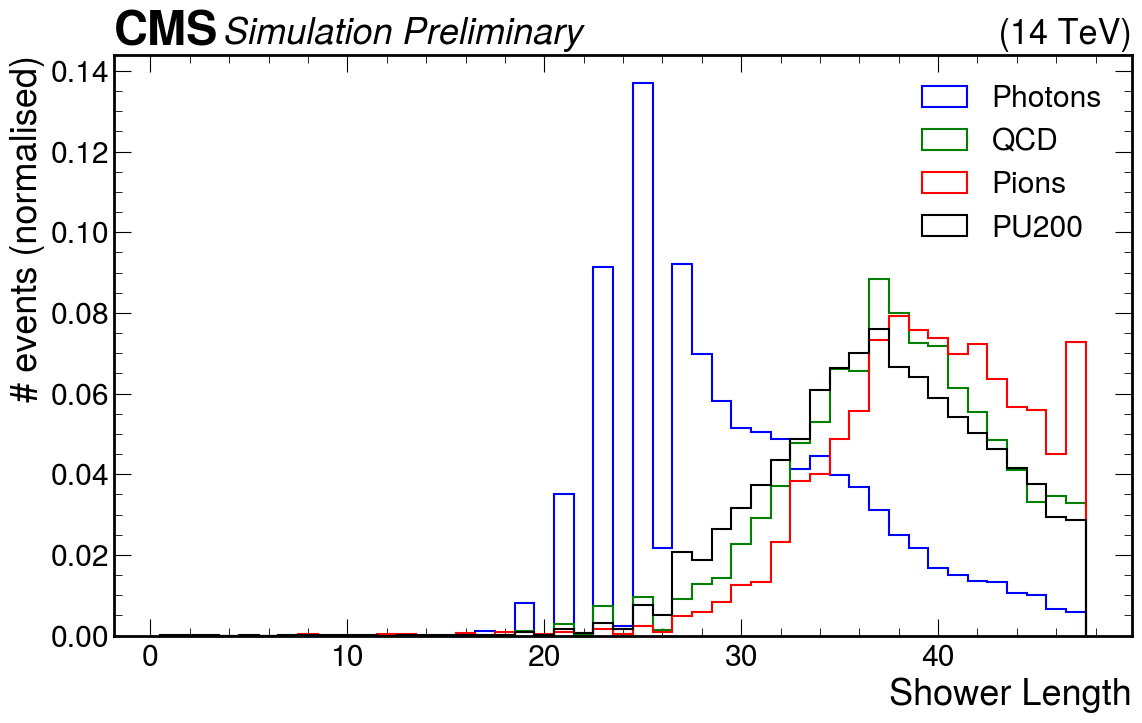

Saved: newsamples_Ref_plots/cl3d_Ref_coreshowerlength_histogram.pdf


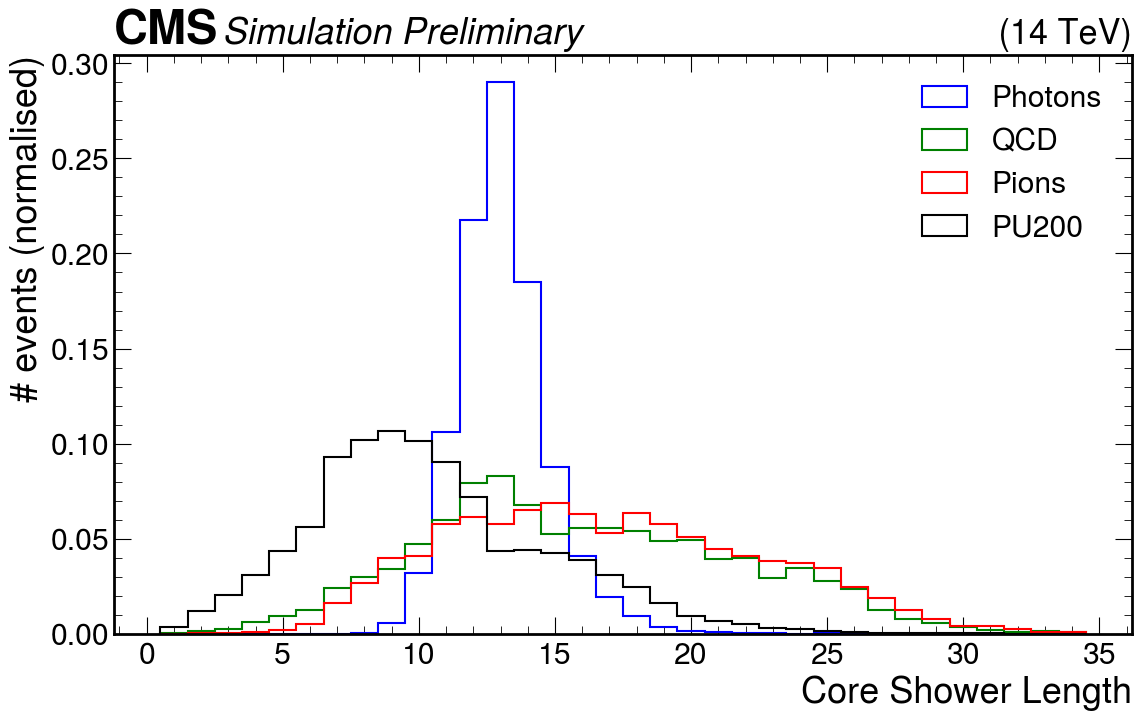

Saved: newsamples_Ref_plots/cl3d_Ref_firstlayer_histogram.pdf


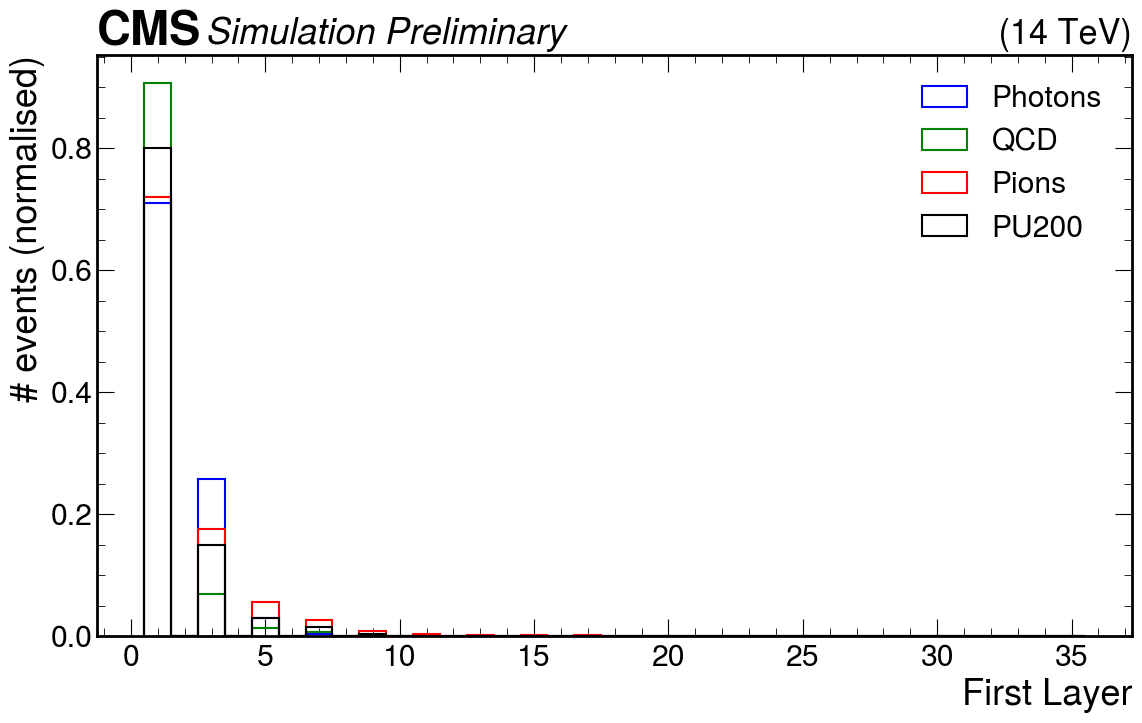

Saved: newsamples_Ref_plots/cl3d_Ref_maxlayer_histogram.pdf


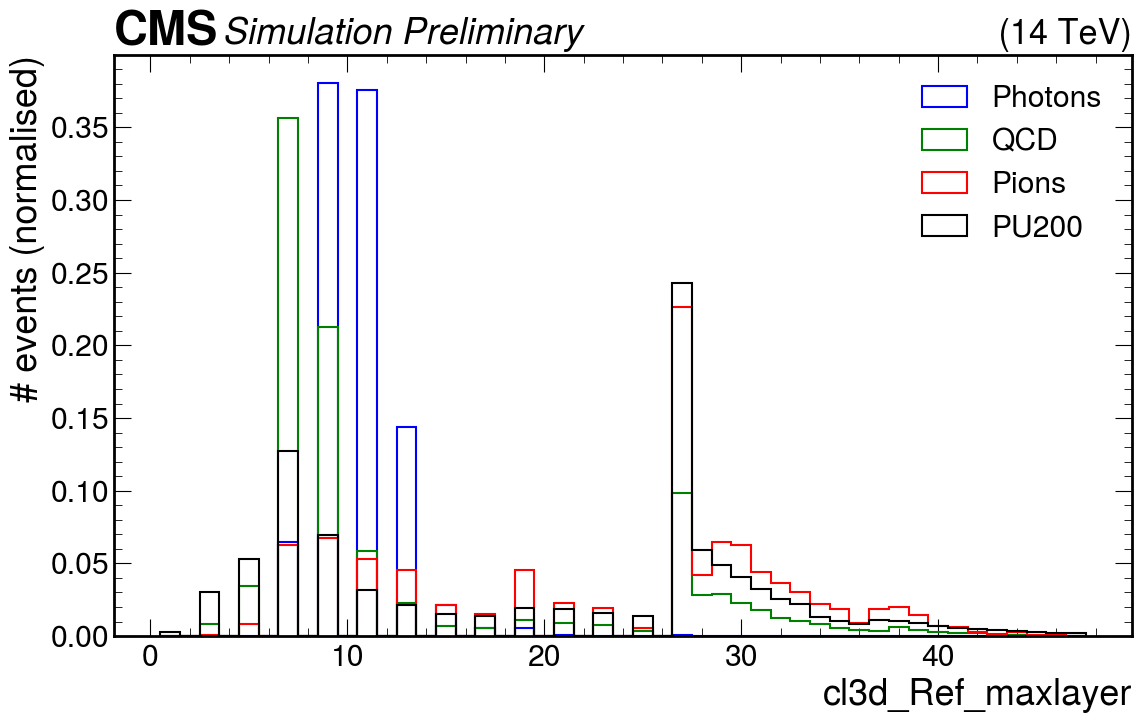

Saved: newsamples_Ref_plots/cl3d_Ref_varrr_histogram.pdf


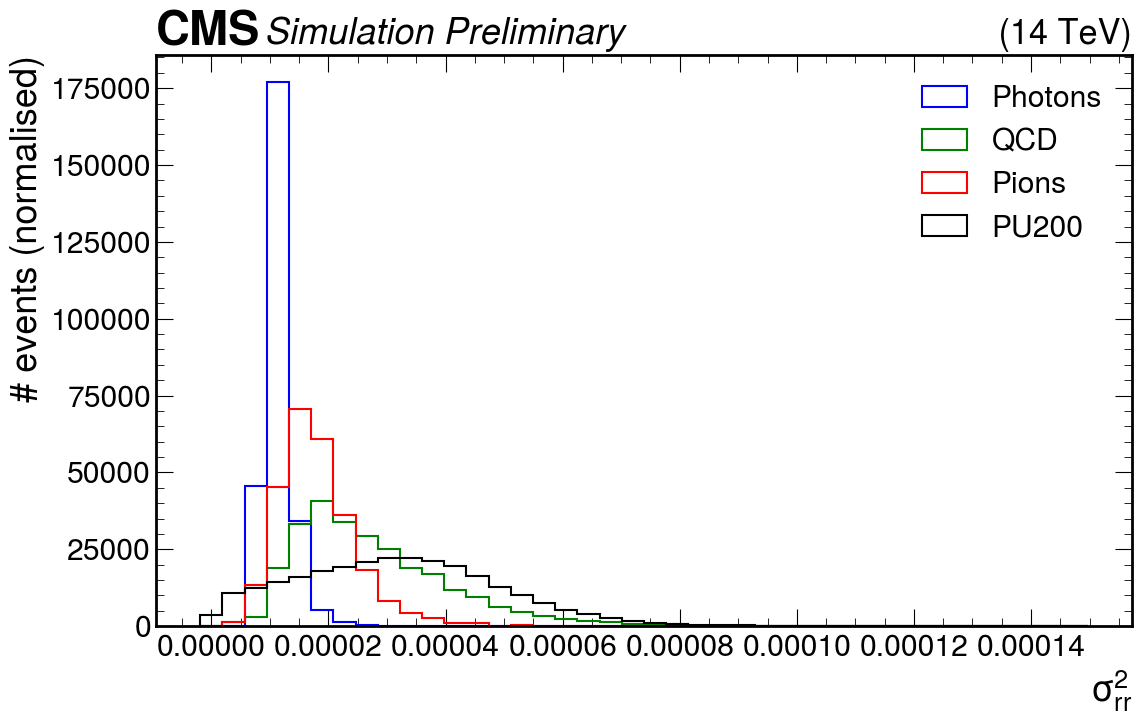

Saved: newsamples_Ref_plots/cl3d_Ref_varzz_histogram.pdf


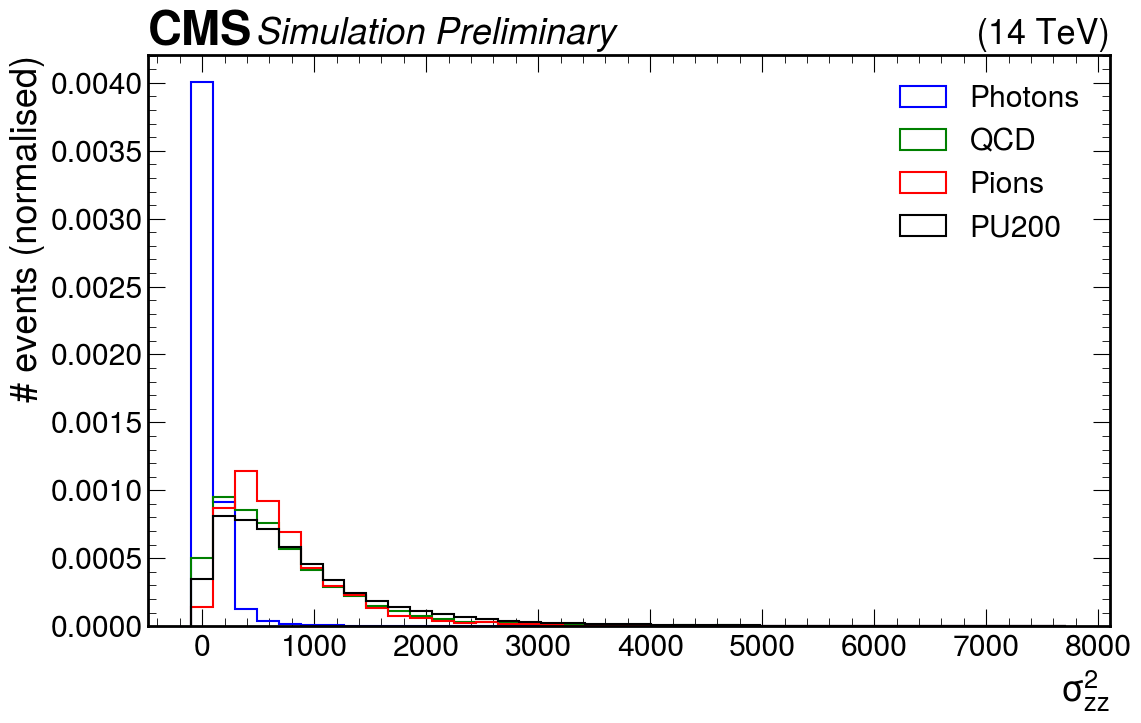

Saved: newsamples_Ref_plots/cl3d_Ref_varee_histogram.pdf


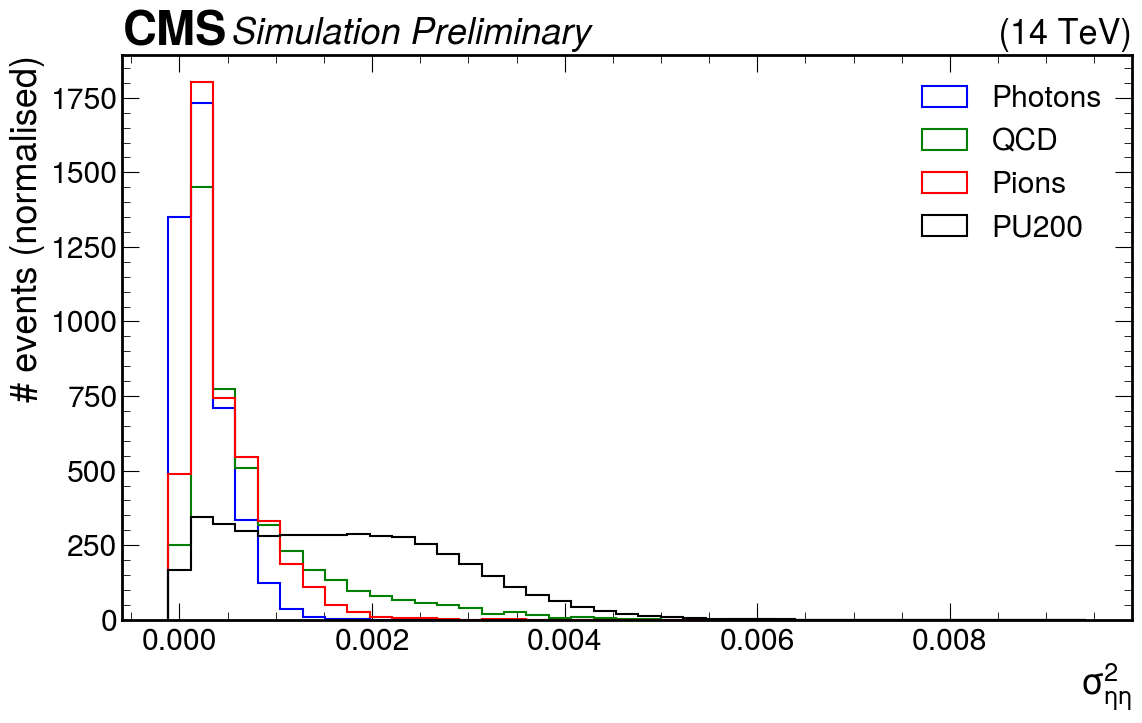

Saved: newsamples_Ref_plots/cl3d_Ref_varpp_histogram.pdf


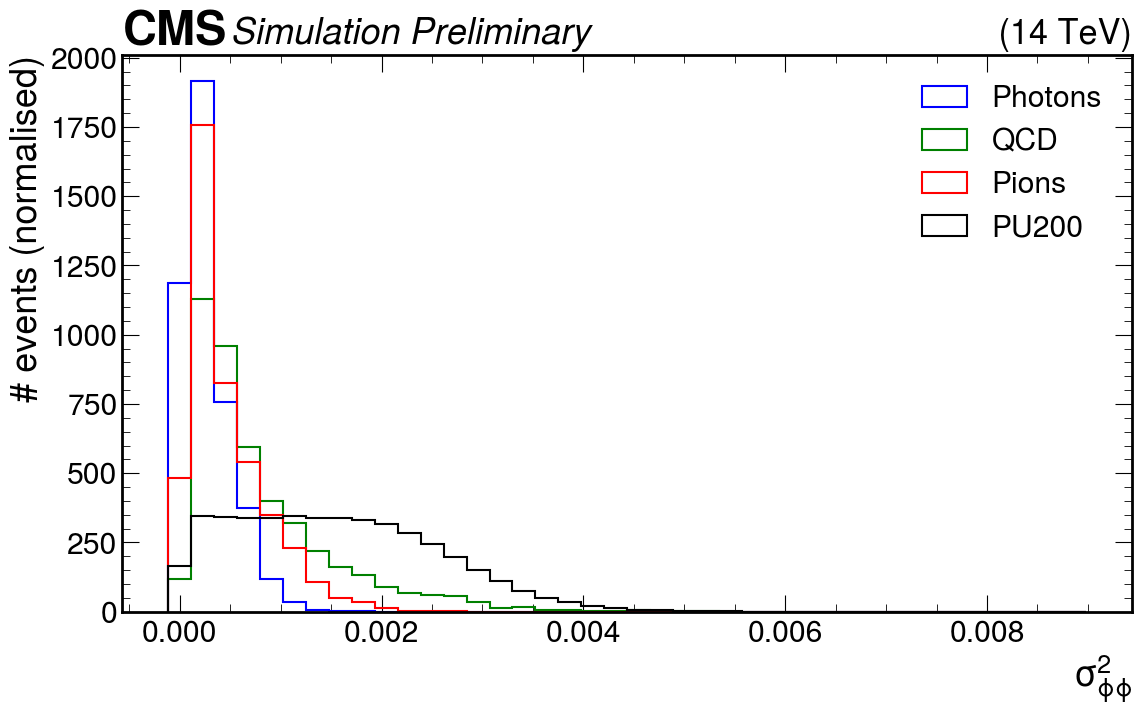

Saved: newsamples_Ref_plots/cl3d_Ref_emaxe_histogram.pdf


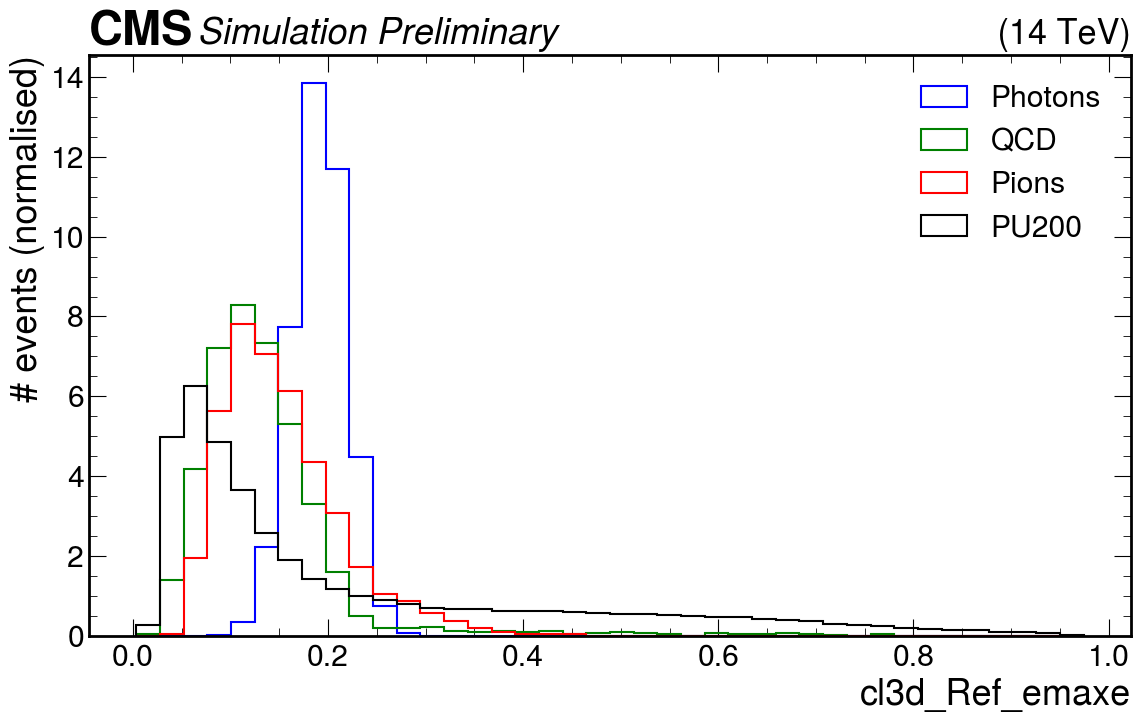

Saved: newsamples_Ref_plots/cl3d_Ref_hoe_histogram.pdf


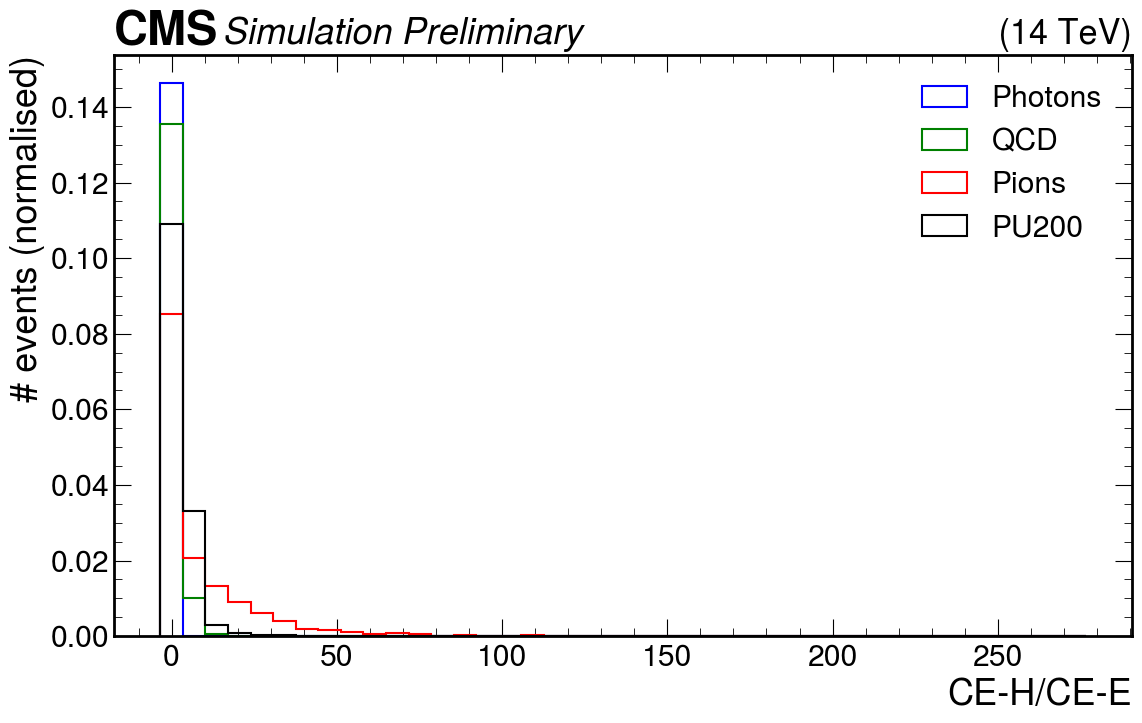

Saved: newsamples_Ref_plots/cl3d_Ref_meanz_histogram.pdf


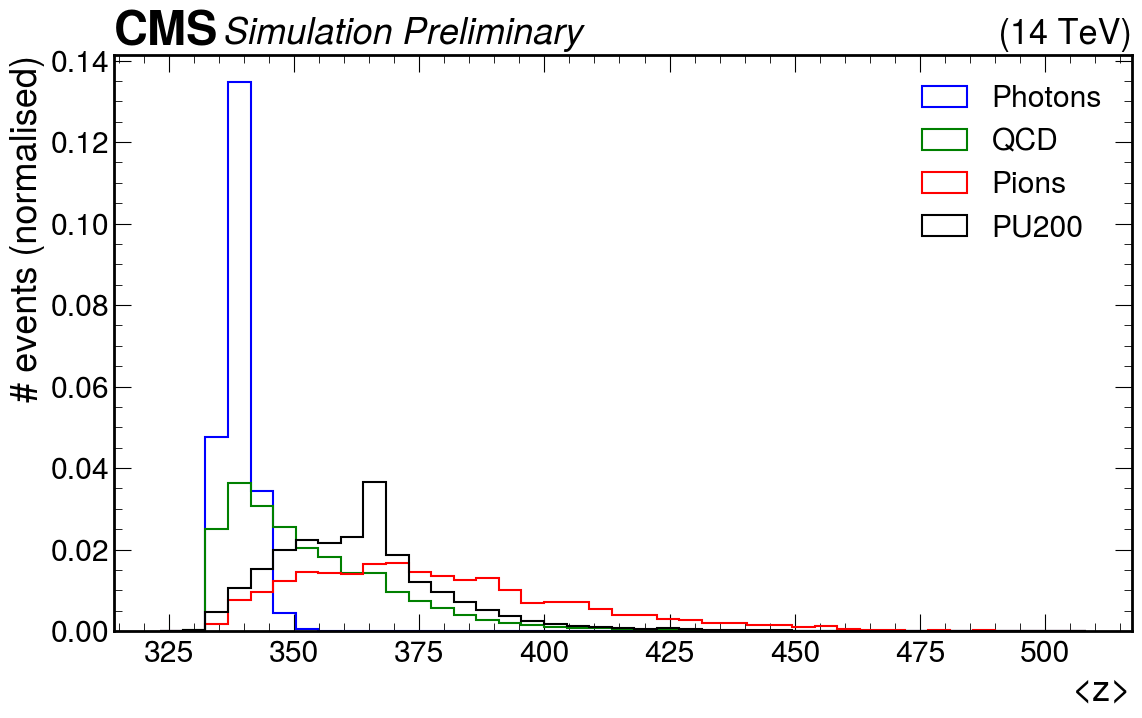

Saved: newsamples_Ref_plots/cl3d_Ref_first1layers_histogram.pdf


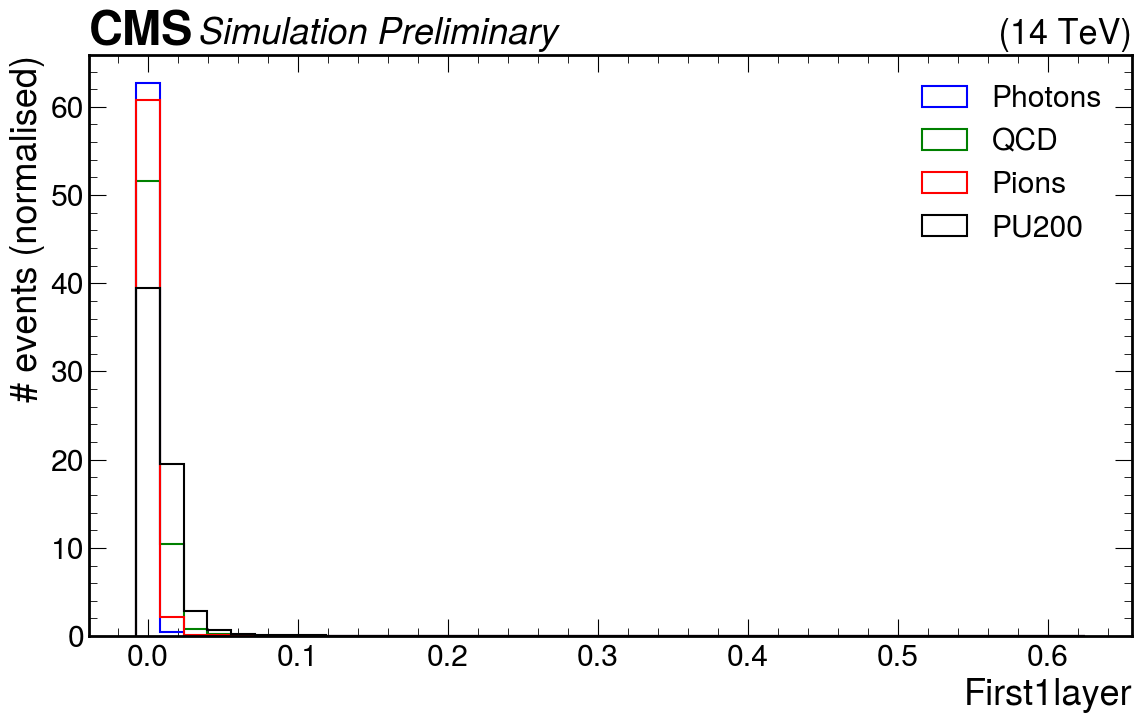

Saved: newsamples_Ref_plots/cl3d_Ref_first3layers_histogram.pdf


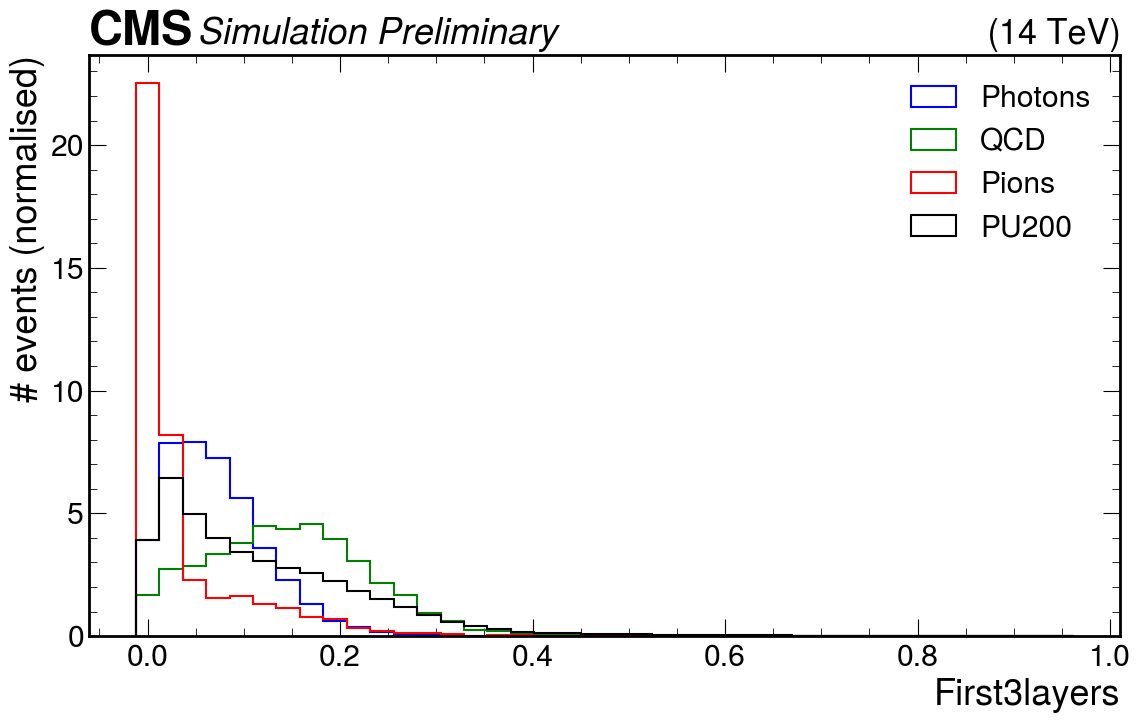

Saved: newsamples_Ref_plots/cl3d_Ref_first5layers_histogram.pdf


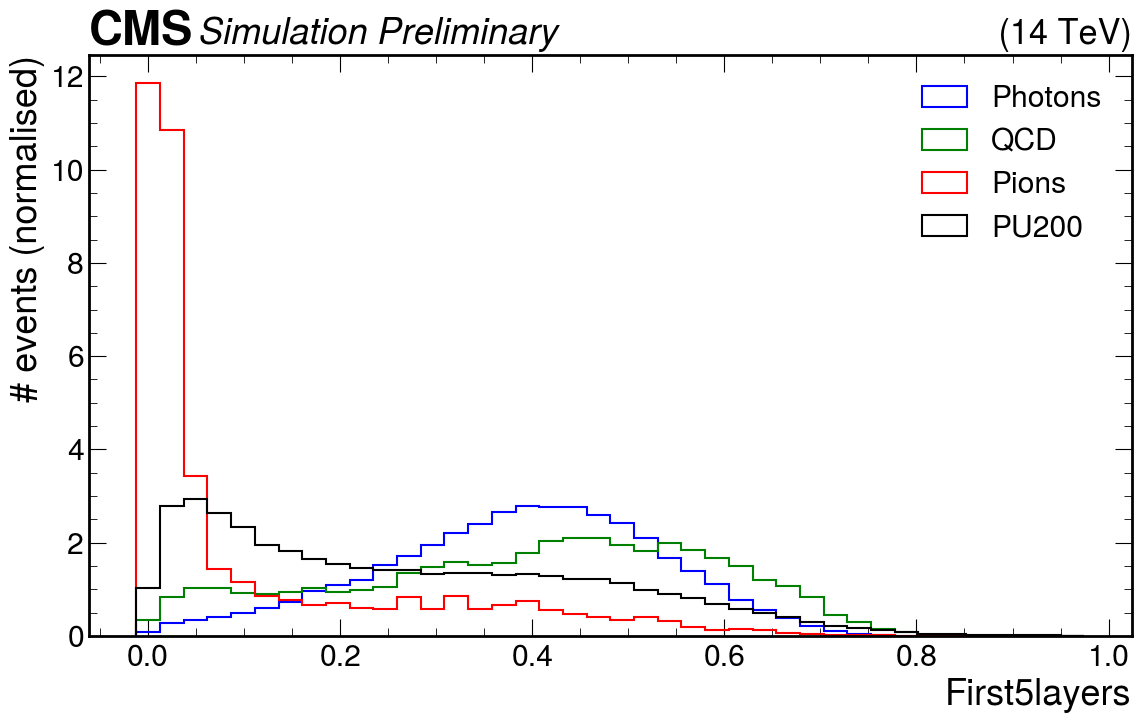

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal1layers_histogram.pdf


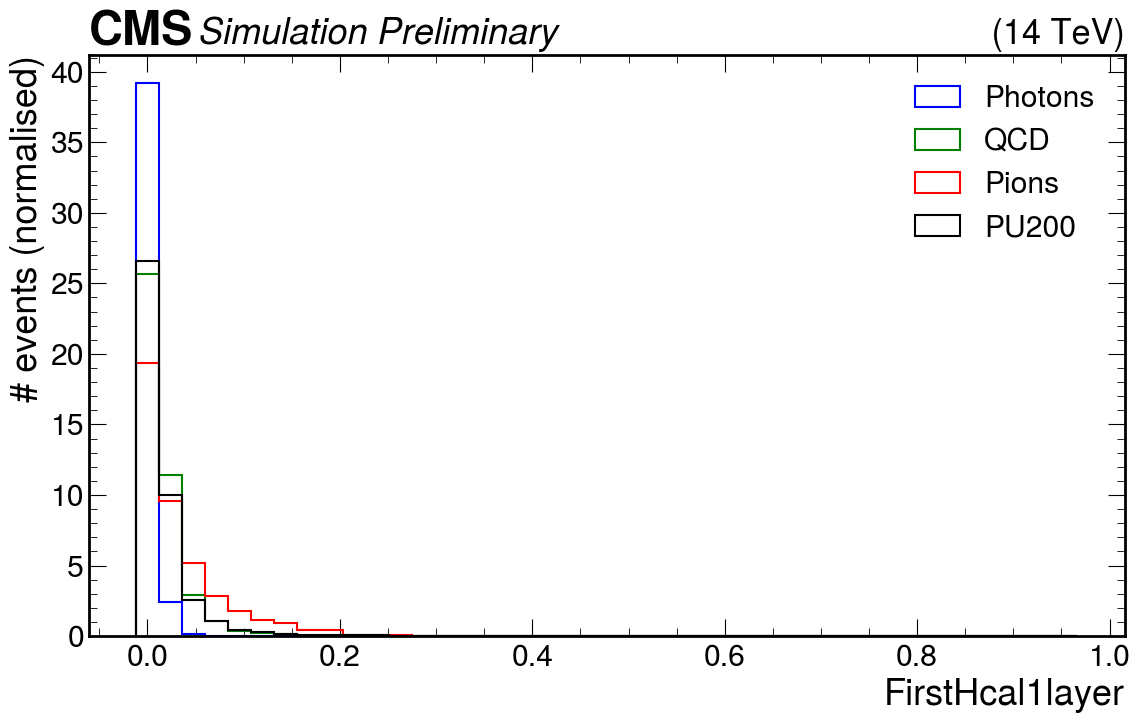

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal3layers_histogram.pdf


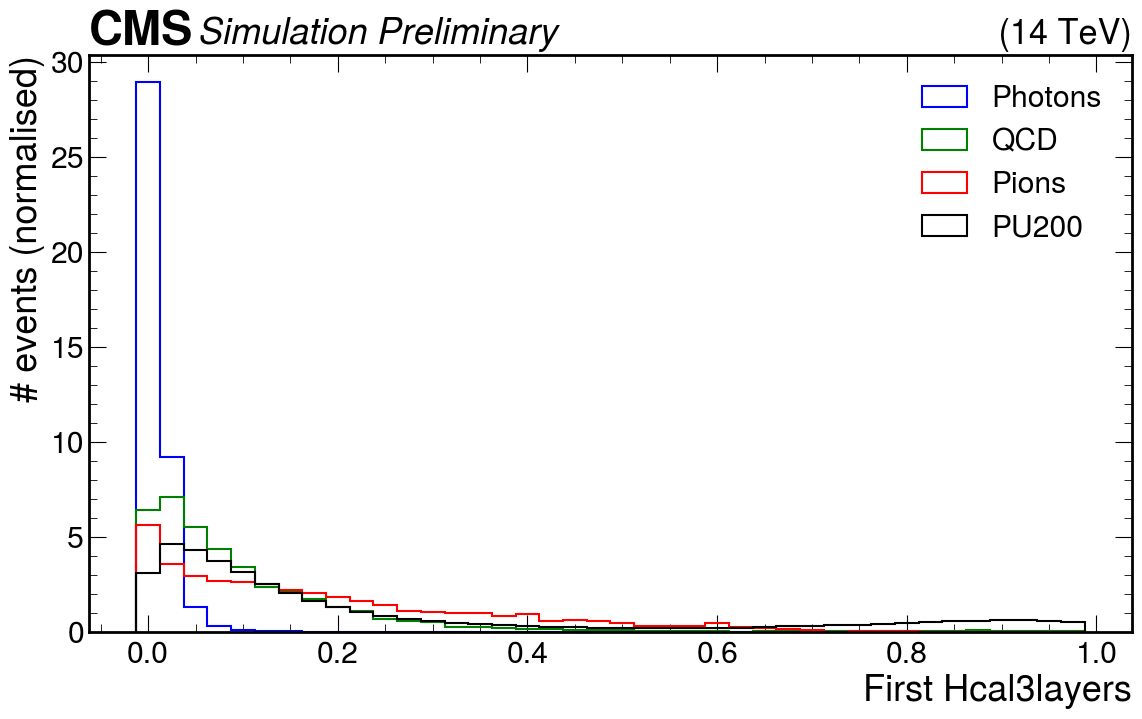

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal5layers_histogram.pdf


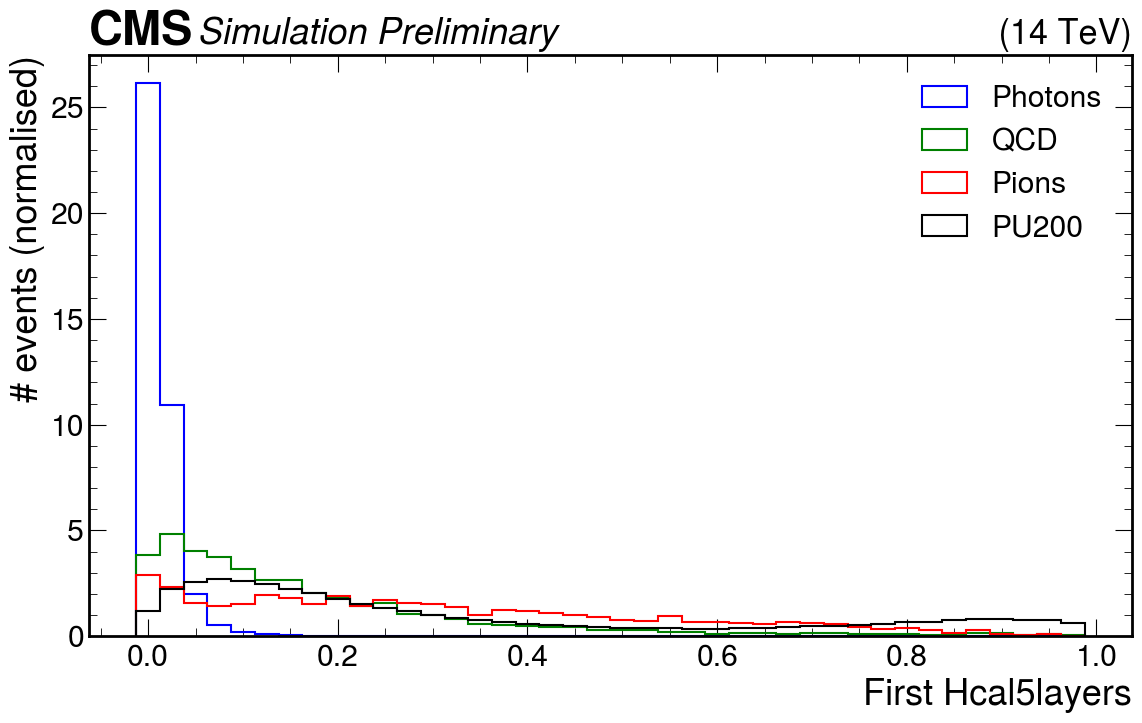

Saved: newsamples_Ref_plots/cl3d_Ref_last1layers_histogram.pdf


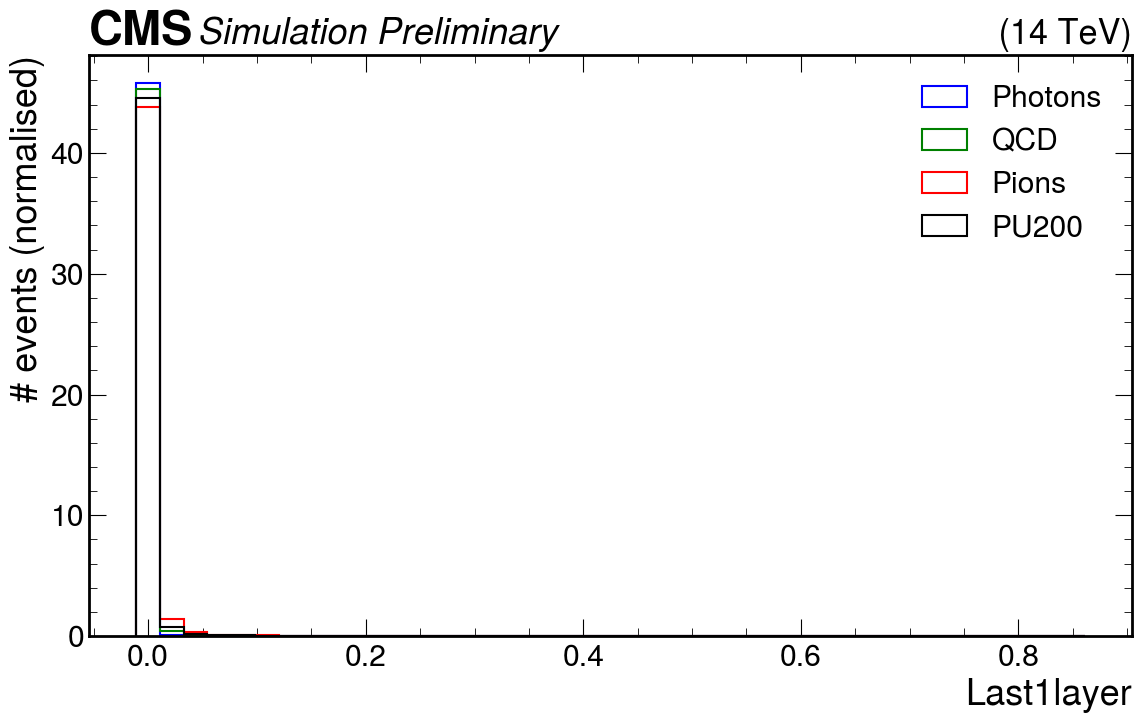

Saved: newsamples_Ref_plots/cl3d_Ref_last3layers_histogram.pdf


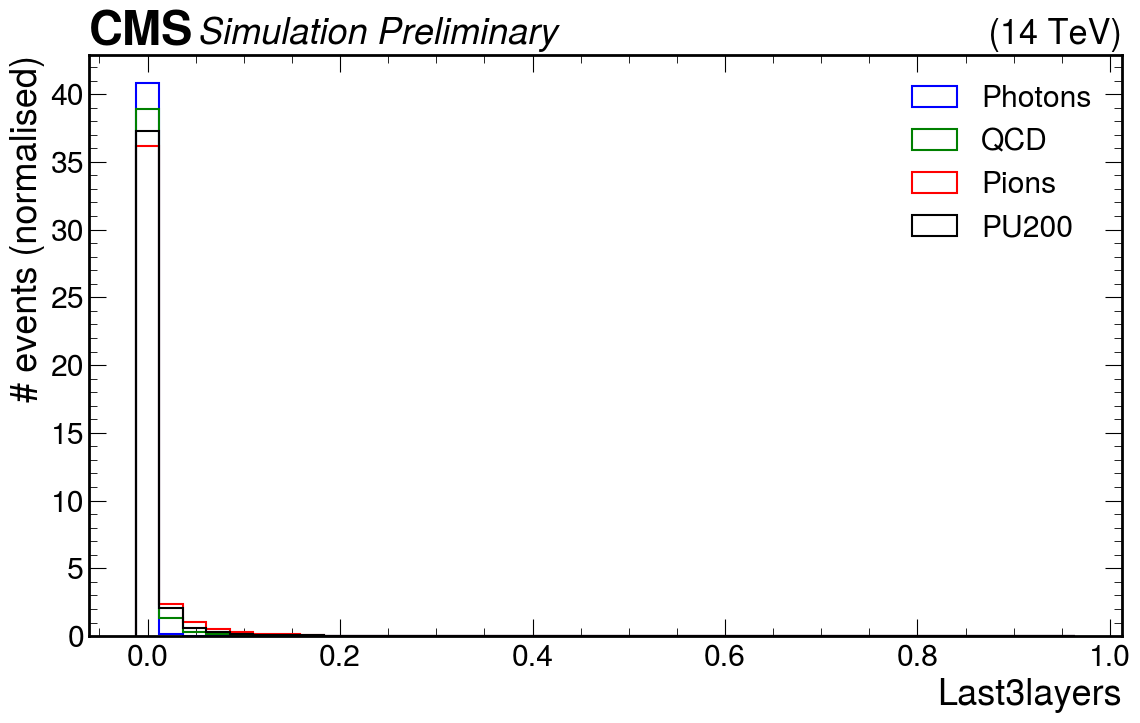

Saved: newsamples_Ref_plots/cl3d_Ref_last5layers_histogram.pdf


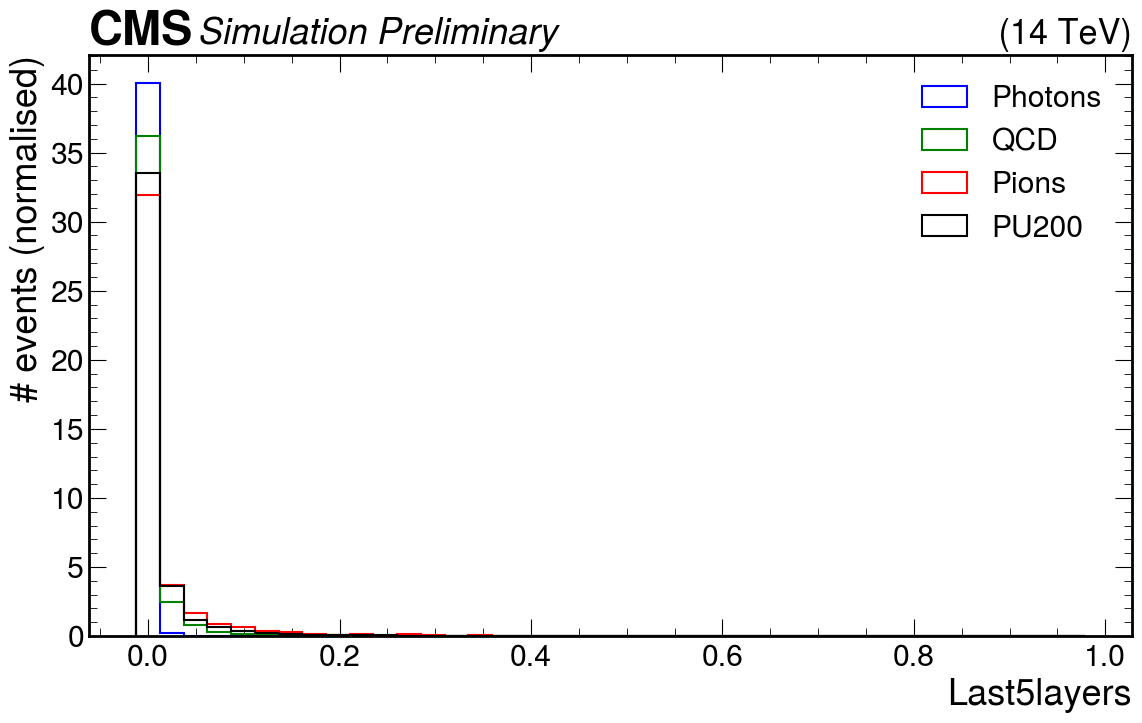

Saved: newsamples_Ref_plots/cl3d_Ref_eot_histogram.pdf


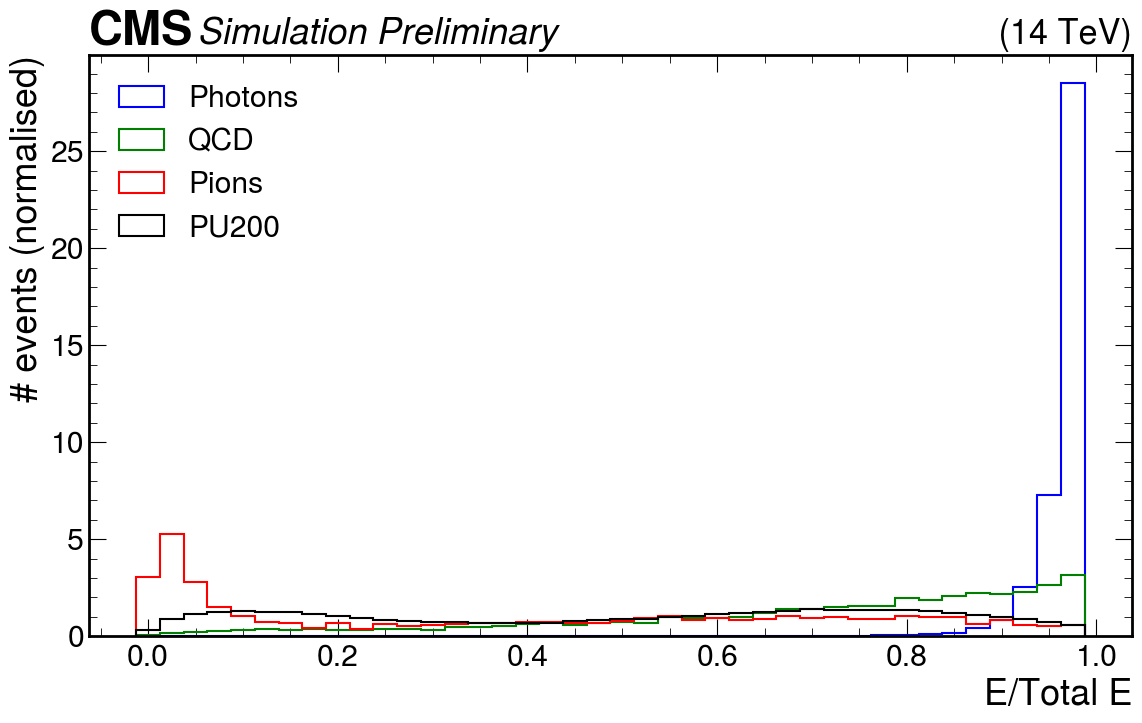

Saved: newsamples_Ref_plots/cl3d_Ref_ebm0_histogram.pdf


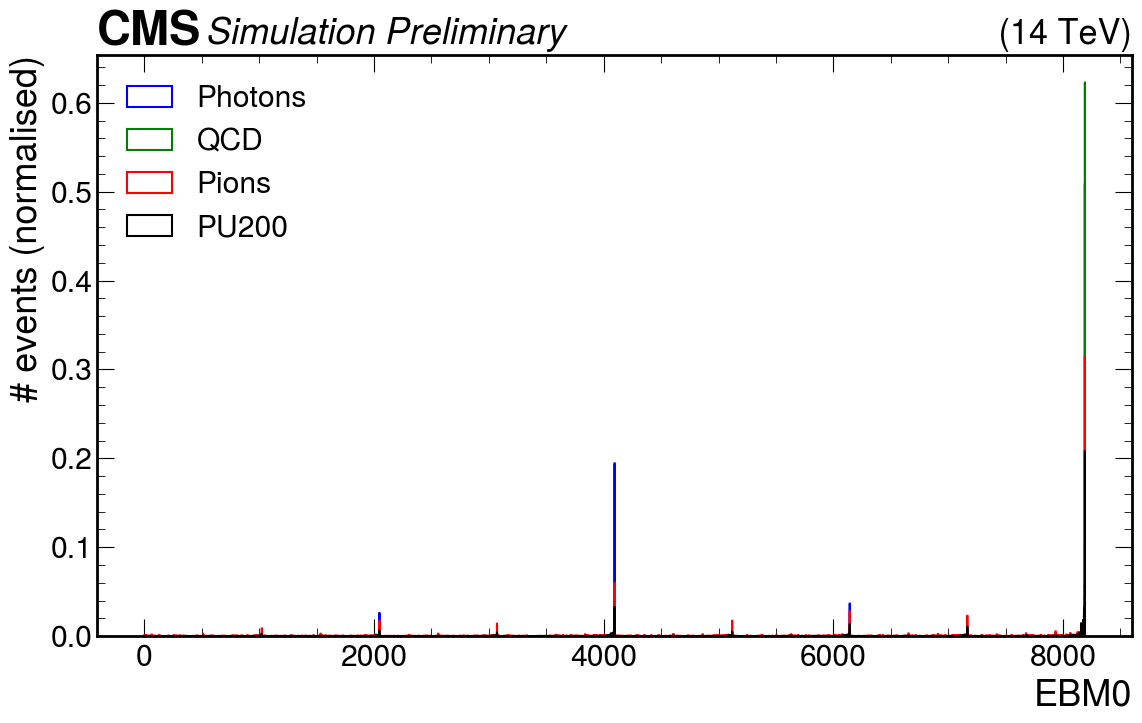

Saved: newsamples_Ref_plots/cl3d_Ref_ebm1_histogram.pdf


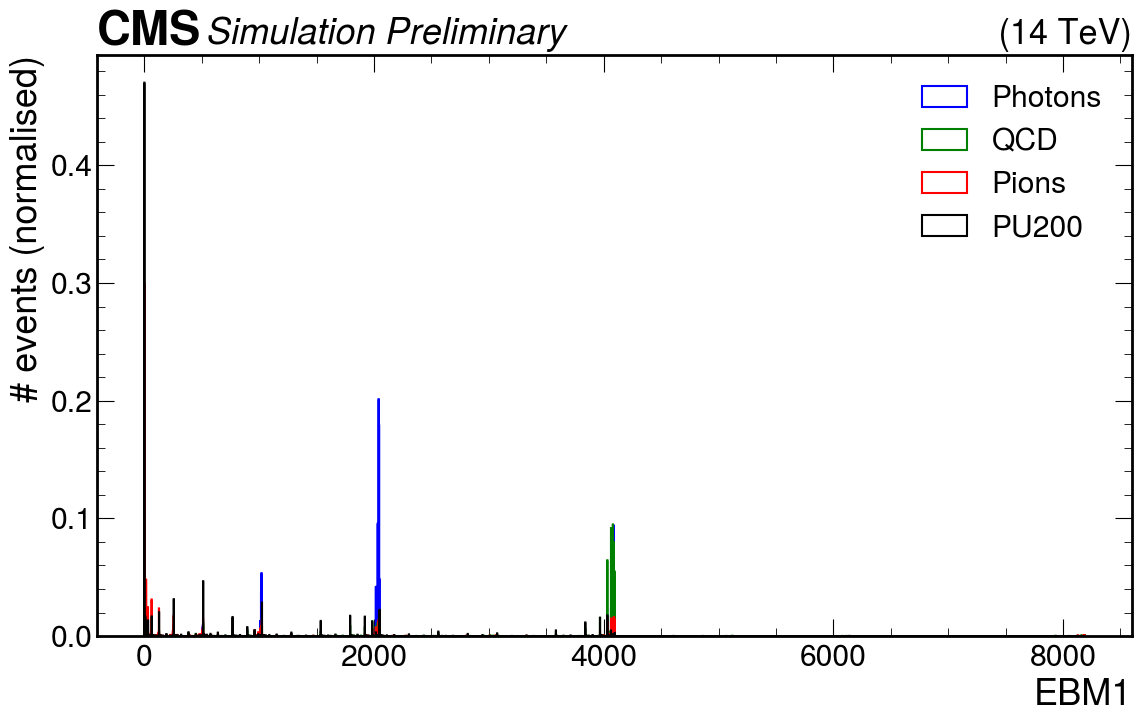

In [75]:
plot_histograms(photon_df_Ref_filtered, qcd_df_Ref_filtered, pion_df_Ref_filtered, PU_df_Ref, ana.variables_to_plot('Ref'), "Photons", 'QCD', 'Pions', 'PU200', 'newsamples_Ref_plots', ana.var_map('Ref'), 'Ref')

In [318]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as mh

mh.style.use("CMS")


def _translate_col(col, src_prefix, dst_prefix):
    return col.replace(f"cl3d_{src_prefix}_", f"cl3d_{dst_prefix}_")


def plot_triangles_row_clean(
    tri_cfg,
    tri_order,
    var_ref,
    var_latex_map_ref,
    outdir,
    src_prefix="Ref",
    cl3d_pt_range=(20, 100),
    num_bins=10,
    figsize=(18, 4.6),
    yscale="log",
    cms_label="Simulation Preliminary",
    rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$",
    annotate_a=True,                 # write "a = 0.0113" etc
):
    os.makedirs(outdir, exist_ok=True)
    prefix_map = {
    "p0113": "p0113Tri",
    "p016":  "p016Tri",
    "p03":   "p03Tri",
    "p045":  "p045Tri",
    "Ref":   "Ref",
}
    samples = [
        ("Prompt photons",   "photon", "b"),
        ("Photons from jets","qcd",    "g"),
        ("Pions",            "pion",   "r"),
        ("PU200",            "pu",     "k"),
    ]

    # --- collect arrays globally for shared bins
    arrays = {}
    all_arrays = []

    for tri in tri_order:
        cfg = tri_cfg[tri]
        pref = prefix_map[tri]
        pt_col = f"cl3d_{pref}_pt"
        var_tri = _translate_col(var_ref, src_prefix, pref)

        for _, sample_key, _ in samples:
            df = cfg[sample_key]
            if pt_col not in df.columns or var_tri not in df.columns:
                continue
            m = (df[pt_col] >= cl3d_pt_range[0]) & (df[pt_col] <= cl3d_pt_range[1])
            a = df.loc[m, var_tri].to_numpy()
            a = a[np.isfinite(a)]
            if len(a) == 0:
                continue
            arrays[(tri, sample_key)] = a
            all_arrays.append(a)

    if not all_arrays:
        print("Nothing to plot for", var_ref)
        return

    concat = np.concatenate(all_arrays)
    vmin, vmax = np.min(concat), np.max(concat)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        print("Bad range for", var_ref)
        return

    is_intlike = np.all(np.isclose(concat, np.round(concat)))
    if is_intlike:
        bin_edges = np.arange(vmin - 0.5, vmax + 1.5, 1)
    else:
        bin_edges = np.linspace(vmin, vmax, num_bins + 1)

    # --- build row of panels
    fig, axes = plt.subplots(1, len(tri_order), figsize=figsize, sharex=True, sharey=True)
    if len(tri_order) == 1:
        axes = [axes]

    for i, tri in enumerate(tri_order):
        ax = axes[i]
        for lab, sample_key, col in samples:
            a = arrays.get((tri, sample_key))
            if a is None:
                continue
            ax.hist(a, bins=bin_edges, histtype="step", density=True,
                    linewidth=1.6, color=col, label=lab)
        if annotate_a:
            # extract number from tri name if possible
            # e.g. "p0113" -> 0.0113
            if tri.startswith("p") and tri[1:].replace(".", "").isdigit():
                aval = float("0." + tri[1:])
                ax.text(0.06, 0.9, rf"$\mathbf{{s}} = {aval}$", transform=ax.transAxes,
                         color="red")

        if yscale == "log":
            ax.set_yscale("log")

        ax.tick_params(direction="in", top=True, right=True, which="both")
        if i != 0:
            ax.tick_params(labelleft=False)

    # shared labels (figure-level)
    fig.text(
    0.03, 0.87,
    "a.u.", rotation =90, 
    ha="left", va="top",
)
    fig.text(
    0.97, 0.03,
    "Core shower length (no. of layers)", 
    ha="right", va="bottom",
)

    # legend INSIDE last axis (so it doesn't crush layout)
    axes[-1].legend(loc="lower right", frameon=False, fontsize=20)

    # leave room at top for CMS label
    fig.subplots_adjust(left=0.07, right=0.985, bottom=0.15, top=0.90, wspace=0.0)

    # CMS label ONCE, figure-level anchored to left/top margin
    # Put it on the first axis but using OUTSIDE coords so it doesn't overlap panels
    mh.cms.label(cms_label, data=False, ax=axes[0], loc=0, rlabel="")
    fig.text(0.985, 0.9, rlabel, ha="right", va="bottom")
    outpath = os.path.join(outdir, f"triRow_{var_ref}.pdf")
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    print("Saved:", outpath)
    plt.show()
    plt.close(fig)


Saved: tri_size_comparison_row/triRow_cl3d_Ref_coreshowerlength.pdf


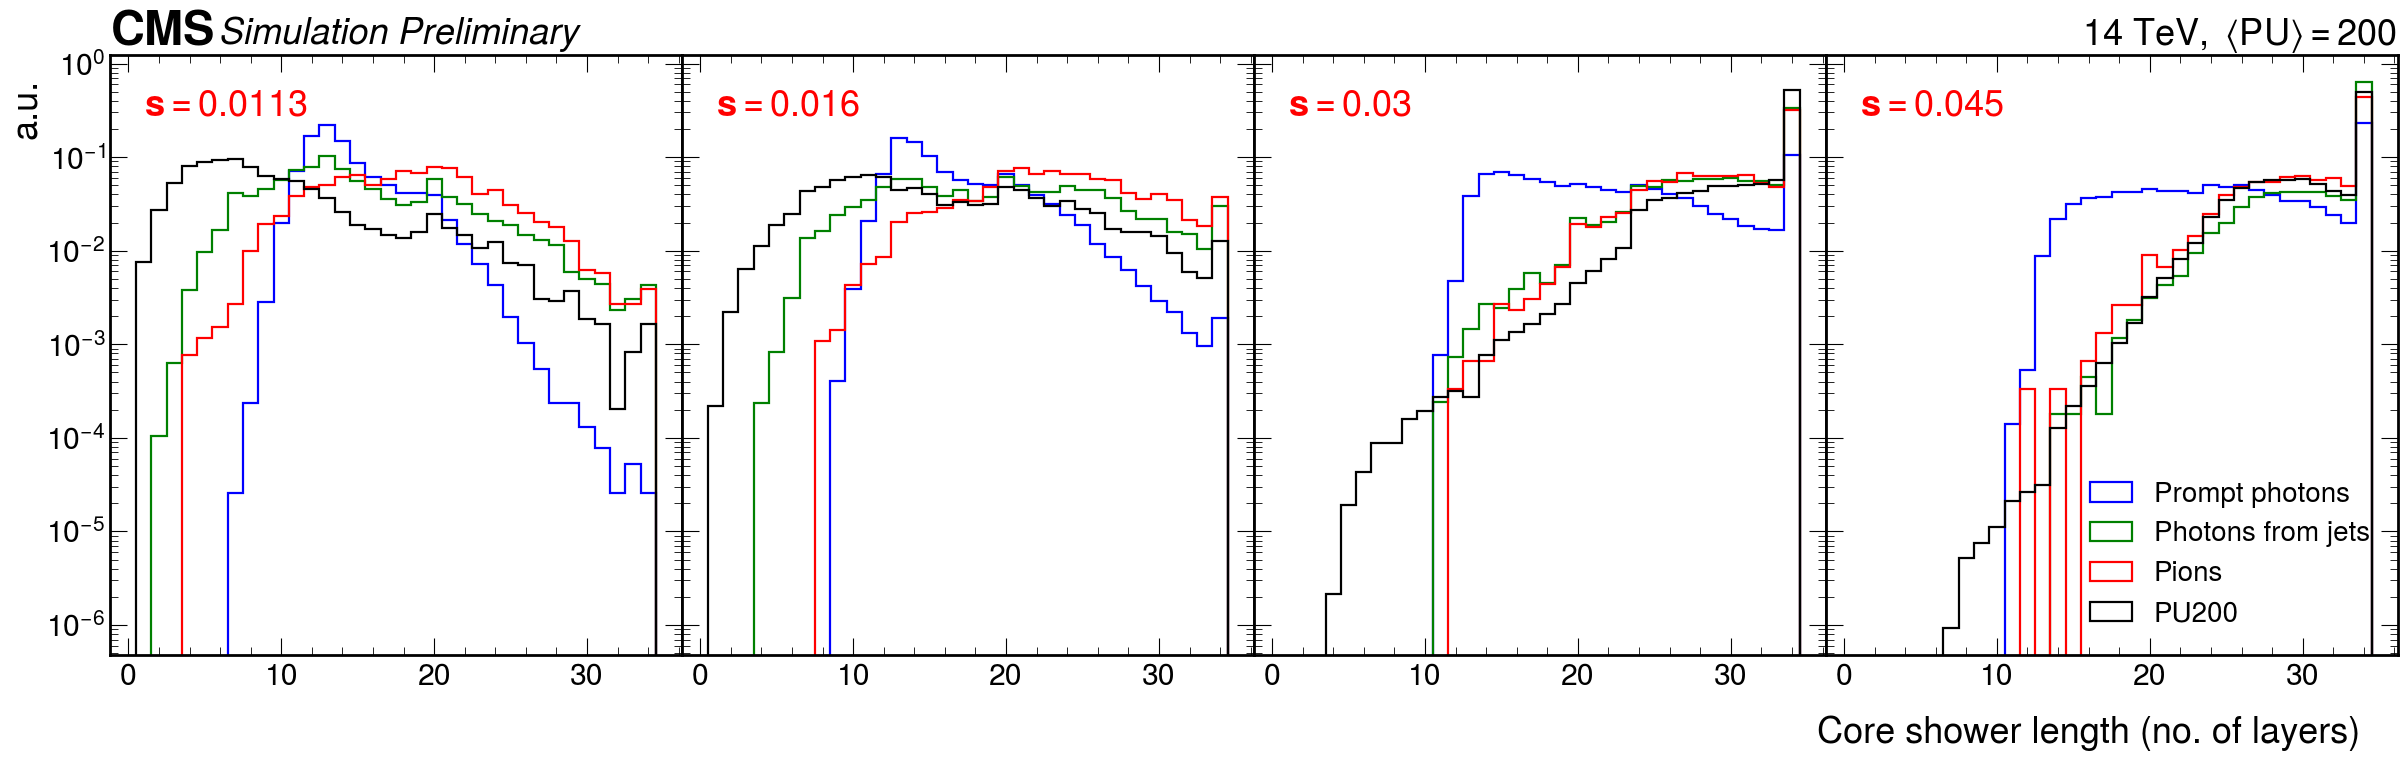

In [319]:

tri_order = ["p0113", "p016", "p03", "p045"]

plot_triangles_row_clean(
    tri_cfg=tri_cfg,
    tri_order=tri_order,
    var_ref="cl3d_Ref_coreshowerlength",
    var_latex_map_ref=ana.var_map("Ref"),
    outdir="tri_size_comparison_row",
    cl3d_pt_range=(20, 100),
    num_bins=40,
    figsize=(25, 8),
    cms_label="Preliminary",
    rlabel=r"$14~\mathrm{TeV},\ \langle PU\rangle=200$"
)


In [119]:
def plot_phi_vs_eta_broken(df, eta_col, phi_col, filename, left_xlim=(-3.0, -1.6), right_xlim=(1.6, 3.0), phi_range=(-np.pi, np.pi), s=6, alpha=0.35, add_cms_header=True
):
    eta = df[eta_col].to_numpy()
    phi = df[phi_col].to_numpy()

    mL = (eta >= left_xlim[0])  & (eta <= left_xlim[1])  & np.isfinite(phi)
    mR = (eta >= right_xlim[0]) & (eta <= right_xlim[1]) & np.isfinite(phi)

    fig, (axL, axR) = plt.subplots(
        1, 2, sharey=True, figsize=(9,5),
        gridspec_kw={"wspace": 0.05}
    )

    # scatter on each panel
    axL.scatter(eta[mL], phi[mL], s=s, alpha=alpha)
    axR.scatter(eta[mR], phi[mR], s=s, alpha=alpha)

    # limits
    axL.set_xlim(left_xlim)
    axR.set_xlim(right_xlim)
    axL.set_ylim(phi_range)

    # labels
    axL.set_ylabel(r"$\phi$ (rad)")
    axL.set_xlabel(r"$\eta$")

    # tidy: hide the inner spines
    axL.spines.right.set_visible(False)
    axR.spines.left.set_visible(False)
    axR.yaxis.tick_right()
    axR.tick_params(labelleft=False)  # y labels only on left

    # diagonal break marks
    d = .015  # size of diagonal lines
    kwargs = dict(transform=axL.transAxes, color='k', clip_on=False, lw=2)
    axL.plot((1-d, 1+d), (-d, +d), **kwargs)    # top-right of left axes
    axL.plot((1-d, 1+d), (1-d, 1+d), **kwargs)  # bottom-right of left axes
    kwargs.update(transform=axR.transAxes)      # switch to the right axes
    axR.plot((-d, +d), (-d, +d), **kwargs)      # top-left of right axes
    axR.plot((-d, +d), (1-d, 1+d), **kwargs)    # bottom-left of right axes

    plt.subplots_adjust(top=0.90)
    
    # CMS header
    if add_cms_header:
        fig.text(0.1, 0.98, r"$\bf{CMS}$  $\it{Simulation}$ $\it{Preliminary}$", ha="left", va="top", fontsize=14)
        fig.text(0.9, 0.98, "(14 TeV)", ha="right", va="top", fontsize=13)
    plt.savefig(filename)
    plt.show()
    plt.close(fig)


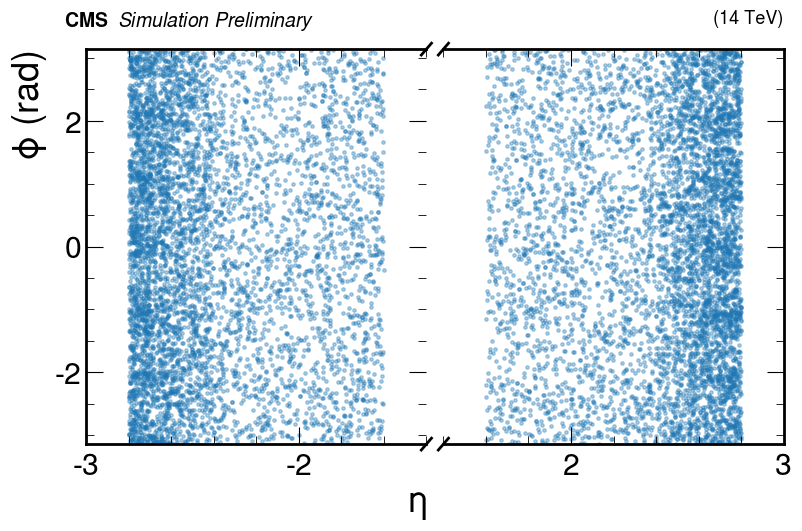

In [76]:
plot_phi_vs_eta_broken(qcd_df_Ref_filtered, "cl3d_Ref_eta", "cl3d_Ref_phi",  "newsamples_Ref_plots/phi_vs_eta_qcd.png", left_xlim=(-3.0,-1.4), right_xlim=(1.4,3.0))

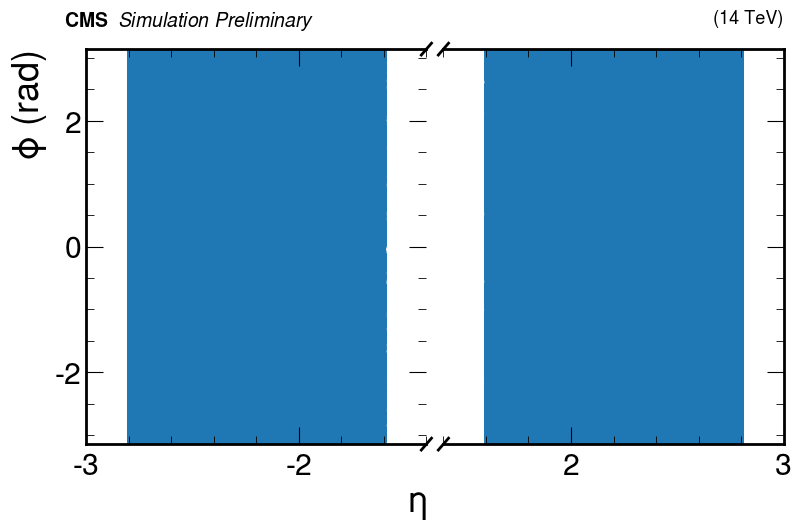

In [77]:
plot_phi_vs_eta_broken(PU_df_Ref, "cl3d_Ref_eta", "cl3d_Ref_phi",  "newsamples_Ref_plots/phi_vs_eta_PU.png", left_xlim=(-3.0,-1.4), right_xlim=(1.4,3.0))

In [59]:
from typing import Sequence, Tuple, Optional

def plot_eta_phi_by_pt_panels(
    df,
    eta_col: str,
    phi_col: str,
    pt_col: str,
    filename: str,
    pt_bins: Sequence[float],                  # e.g. [0, 20, 40, 60, 100, 200]
    phi_range: Tuple[float, float] = (-np.pi, np.pi),
    eta_xlim: Tuple[float, float] = (-3.0, 3.0),   # used when broken_eta=False
    broken_eta: bool = True,                   # True => two mini-axes per panel skipping |η|<1.6
    left_xlim: Tuple[float, float] = (-3.0, -1.6),
    right_xlim: Tuple[float, float] = ( 1.6,  3.0),
    s: float = 6,
    alpha: float = 0.35,
    ncols: Optional[int] = None,               # auto if None
    add_cms_header: bool = True,
):
    """
    Make a grid of η–ϕ scatter plots, one panel per pT bin.
    - If broken_eta=True, each panel contains two side-by-side axes showing η in [left_xlim] U [right_xlim],
      with diagonal 'break' marks to indicate the gap.
    - If broken_eta=False, each panel is a single axis spanning eta_xlim.
    """
    eta = df[eta_col].to_numpy()
    phi = df[phi_col].to_numpy()
    pt  = df[pt_col].to_numpy()

    mfinite = np.isfinite(eta) & np.isfinite(phi) & np.isfinite(pt)
    eta, phi, pt = eta[mfinite], phi[mfinite], pt[mfinite]

    pt_bins = np.asarray(pt_bins, dtype=float)
    if pt_bins.ndim != 1 or len(pt_bins) < 2:
        raise ValueError("pt_bins must be a 1D array of bin edges (len >= 2).")

    bin_lo = pt_bins[:-1]
    bin_hi = pt_bins[1:]
    nbins  = len(bin_lo)

    # grid layout
    if ncols is None:
        ncols = 3 if nbins >= 6 else (2 if nbins >= 3 else 1)
    nrows = int(np.ceil(nbins / ncols))

    # figure size heuristic
    base_w = 3.6 if broken_eta else 3.0
    base_h = 2.8
    fig_w = base_w * ncols + 1.2
    fig_h = base_h * nrows + 1.0
    fig = plt.figure(figsize=(16, 12))

    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.18, hspace=0.30)

    # helper to draw one broken-eta mini-panel (two axes)
    def _broken_panel(fig, grid_cell, xL, xR, y_range, scatter_args):
        sub = gs[grid_cell].subgridspec(1, 2, wspace=0.05)
        axL = fig.add_subplot(sub[0, 0])
        axR = fig.add_subplot(sub[0, 1], sharey=axL)

        # left
        axL.scatter(*scatter_args, s=s, alpha=alpha, color = 'green')
        axL.set_xlim(xL)
        axL.set_ylim(y_range)
        axL.set_ylabel(r"$\phi$ (rad)")

        # right (same data; rely on x-limits to clip)
        axR.scatter(*scatter_args, s=s, alpha=alpha, color = 'green')
        axR.set_xlim(xR)
        axR.set_xlabel(r"$\eta$")

        # tidy: hide touching spines & y tick labels on right
        axL.spines.right.set_visible(False)
        axR.spines.left.set_visible(False)
        axR.yaxis.tick_right()
        axR.tick_params(labelleft=False)

        # diagonal break marks
        d = .015
        kwL = dict(transform=axL.transAxes, color='k', clip_on=False, lw=1.6)
        axL.plot((1-d, 1+d), (-d, +d), **kwL)
        axL.plot((1-d, 1+d), (1-d, 1+d), **kwL)
        kwR = dict(transform=axR.transAxes, color='k', clip_on=False, lw=1.6)
        axR.plot((-d, +d), (-d, +d), **kwR)
        axR.plot((-d, +d), (1-d, 1+d), **kwR)

        return axL, axR

    # loop bins
    for i, (lo, hi) in enumerate(zip(bin_lo, bin_hi)):
        r, c = divmod(i, ncols)
        cell = (r, c)

        sel = (pt >= lo) & (pt < hi)
        x = eta[sel]
        y = phi[sel]

        if broken_eta:
            axL, axR = _broken_panel(fig, cell, left_xlim, right_xlim, phi_range, (x, y))
            # per-panel title centered across both sub-axes
            axR.set_title(f"{lo:g} ≤ pT < {hi:g} GeV", pad=6)
        else:
            ax = fig.add_subplot(gs[cell])
            ax.scatter(x, y, s=s, alpha=alpha, fillcolor = 'red')
            ax.set_xlim(eta_xlim)
            ax.set_ylim(phi_range)
            ax.set_xlabel(r"$\eta$")
            if c == 0:
                ax.set_ylabel(r"$\phi$ (rad)")
            ax.set_title(f"{lo:g} ≤ pT < {hi:g} GeV", pad=6)

    # hide any leftover empty cells (only relevant when nbins doesn't fill the grid)
    for j in range(i + 1, nrows * ncols):
        ax = fig.add_subplot(gs[divmod(j, ncols)])
        ax.axis("off")

    plt.subplots_adjust(top=0.90)
    if add_cms_header:
        fig.text(0.06, 0.985, r"$\bf{CMS}$  $\it{Simulation}$ $\it{Preliminary}$", ha="left", va="top", )
        fig.text(0.985, 0.985, "14 TeV", ha="right", va="top", )

    plt.savefig(filename, bbox_inches="tight")
    plt.show()
    plt.close(fig)

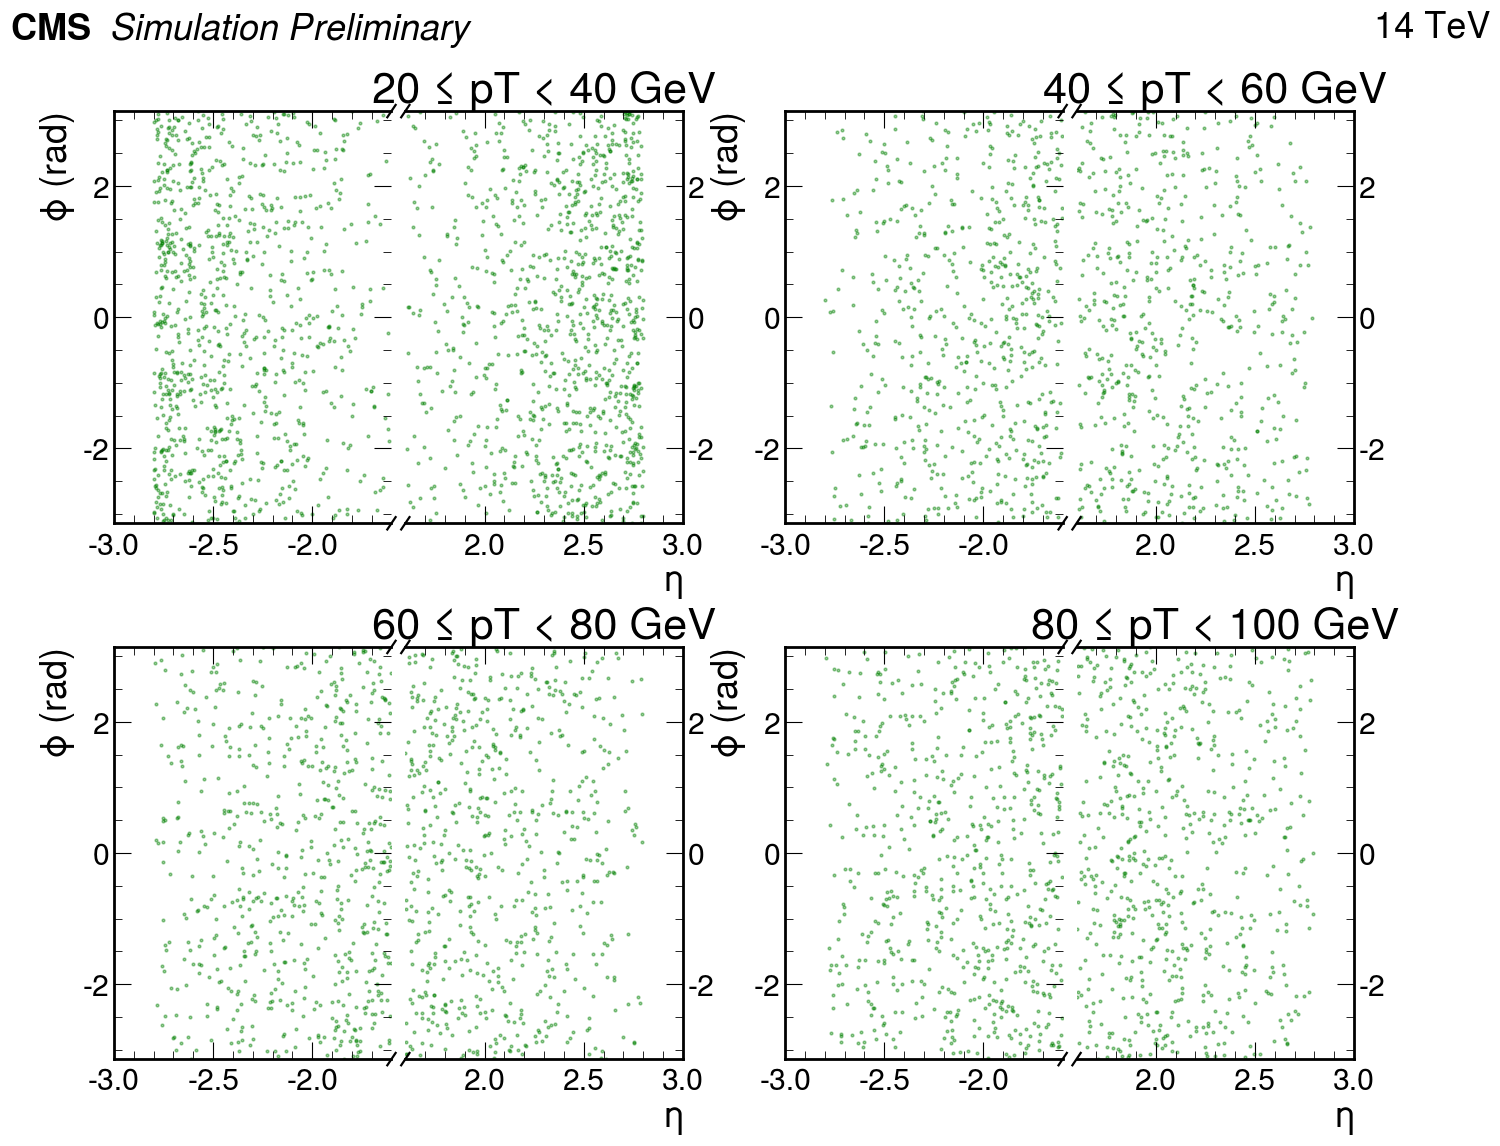

In [78]:
plot_eta_phi_by_pt_panels(
    qcd_df_Ref_filtered,
    eta_col="cl3d_Ref_eta", phi_col="cl3d_Ref_phi", pt_col="cl3d_Ref_pt",
    filename="eta_phi_by_pt_broken_qcd_Ref.png",
    pt_bins=[20, 40, 60, 80, 100],
    broken_eta=True,
    left_xlim=(-3.0, -1.6), right_xlim=(1.6, 3.0),
    s=4, alpha=0.4
)

In [2]:
df = pd.read_csv("/data/data.polcms/cms/debnath/HGCAL/hls/conifer_multiclass_opti_6Integer_ovoPhoton.csv")

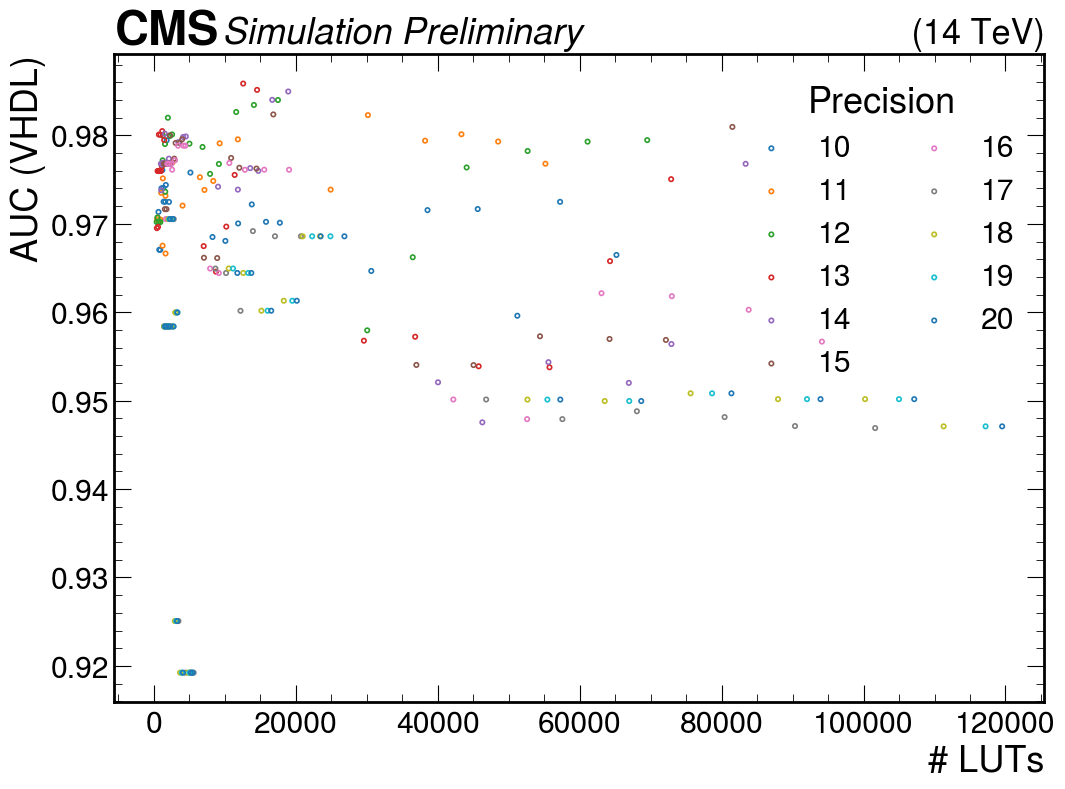

In [63]:
try:
    df["precision"] = df["precision"].astype(int)
except Exception:
    pass

# --- Colors per precision ---
precisions = sorted(df["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 8))

for p in precisions:
    sub = df[df["precision"] == p]
    ax.scatter(
        sub["LUT"],
        sub["auc_hdl"],
        label=f"{p}",
        s=10,
        facecolors="none",          # <-- hollow markers
        edgecolors=prec_to_color[p],
        linewidths=1.2
    )
import matplotlib.ticker as mticker
# show majors at 1, 10, 10^2, 10^3, ...
xmin = 100
xmax = float(df["LUT"].max()) * 1.1
#ax.set_ylim(0.9, 0.97)

ax.set_xlabel("# LUTs")
ax.set_ylabel("AUC (VHDL)")
ax.legend(title="Precision", ncol=2)
ax.tick_params(direction='in')
plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/luts_vs_auc_per_precision_6Integer.png")
plt.show()

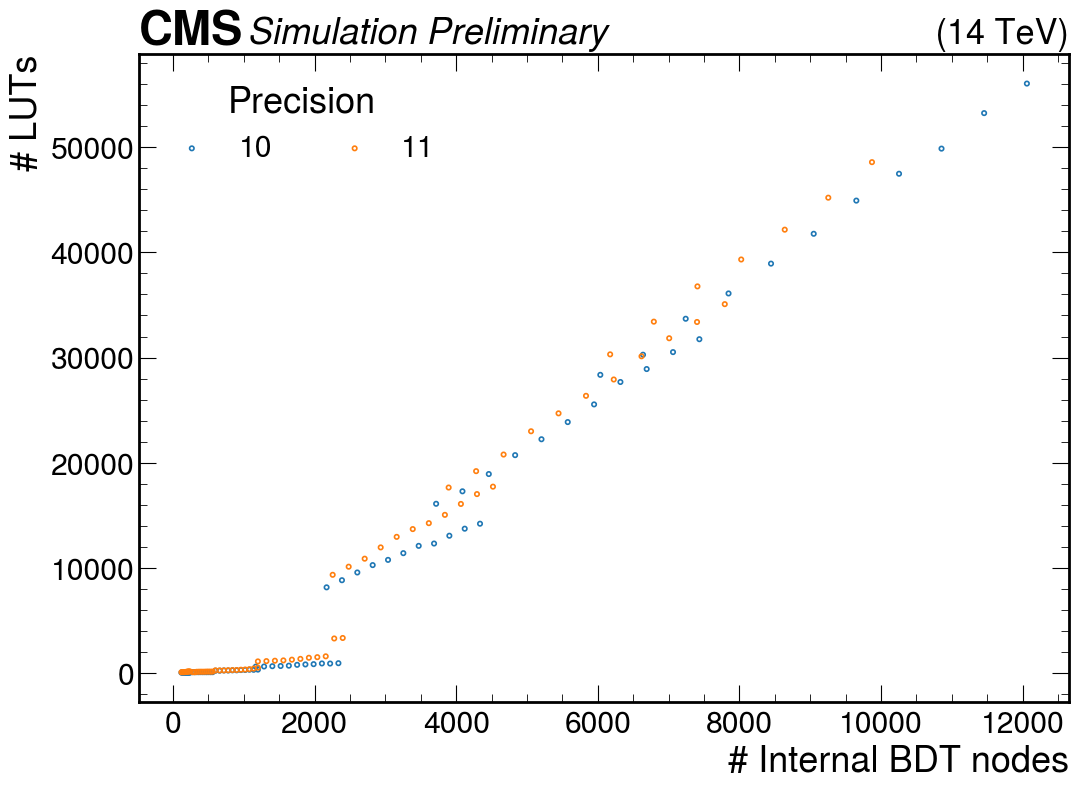

: 

In [ ]:
#dff = dff[dff['depth']==6]

try:
    df["precision"] = df["precision"].astype(int)
except Exception:
    pass

# --- Colors per precision ---
precision = sorted(df["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
precision_to_color = {p: next(color_cycle) for p in precision}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 8))

for p in precision:
    sub = df[df["precision"] == p]
    ax.scatter(
        sub["splits"],
        sub["LUT"],
        label=f"{p}",
        s=10,
        facecolors="none",          # <-- hollow markers
        edgecolors=precision_to_color[p],
        linewidths=1.2
    )

ax.set_ylabel("# LUTs")
ax.set_xlabel("# Internal BDT nodes")
#ax.set_yscale("log")
#ax.set_xscale("log")

ax.legend(title="Precision", ncol=2)#, frameon=False)
ax.tick_params(direction='in')
plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/luts_vs_split_per_precision_6Integer.png")
plt.show()

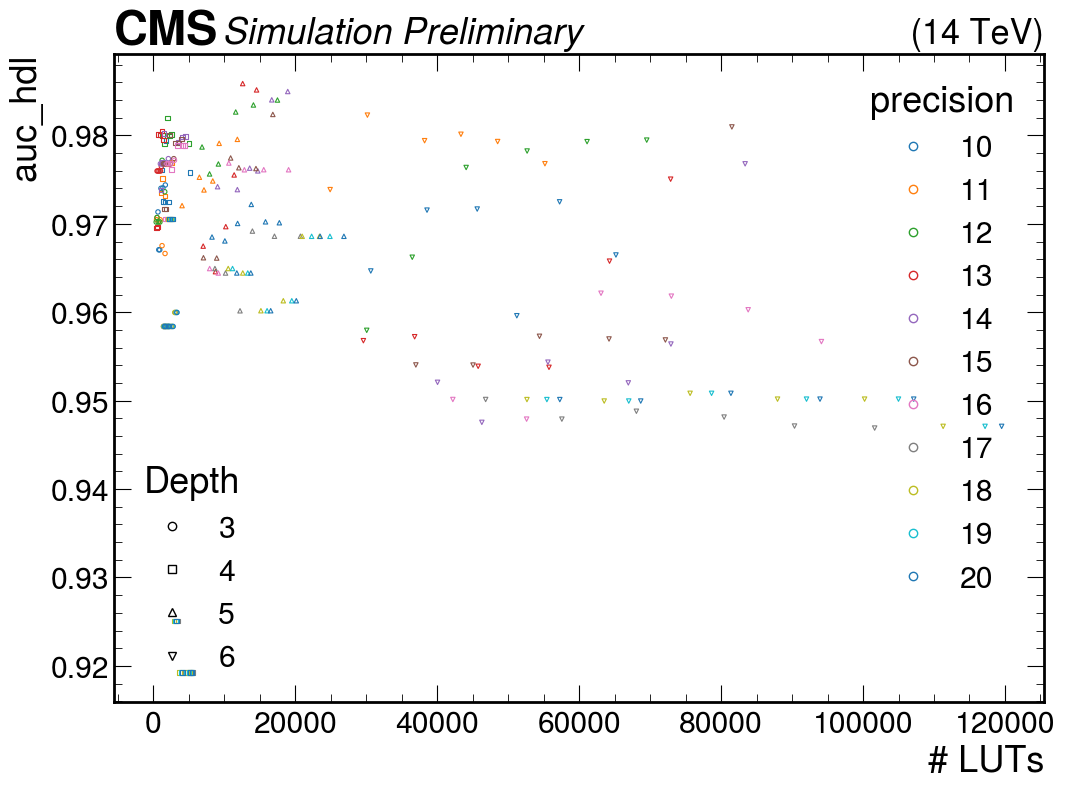

In [64]:
for col in ["precision", "depth"]:
    try:
        df[col] = df[col].astype(int)
    except Exception:
        pass

# --- Colors per precision ---
precision = sorted(df["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
precision_to_color = {p: next(color_cycle) for p in precision}

# --- Markers per depth (all hollow-friendly) ---
depths = sorted(df["depth"].unique())
marker_cycle = cycle(['o', 's', '^', 'v', '>', '<', 'P', 'X', 'h'])
depth_to_marker = {d: next(marker_cycle) for d in depths}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot grouped by (precision, depth)
for (p, d), sub in df.groupby(["precision", "depth"]):
    ax.scatter(
        sub["LUT"],
        sub["auc_hdl"],
        s=10,
        facecolors="none",                         # hollow markers
        edgecolors=precision_to_color[p],              # color encodes precision
        marker=depth_to_marker[d],                # shape encodes depth
        linewidths=0.8,
        label=None
    )

ax.set_ylabel(" auc_hdl")
ax.set_xlabel("# LUTs")
#ax.set_xscale("log")
#ax.set_ylim(0.9,0.98)
ax.tick_params(direction='in')

# --- Dual legends: rounds (colors) + Depth (markers) ---
precision_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor=precision_to_color[r], label=f"{r}")
    for r in precision
]
depth_handles = [
    Line2D([0], [0], marker=depth_to_marker[d], linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor='black', label=f"{d}")
    for d in depths
]

leg1 = ax.legend(handles=precision_handles, title="precision", loc="upper right", frameon=False)
ax.add_artist(leg1)
ax.legend(handles=depth_handles, title="Depth", loc="lower left", frameon=False)

plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/luts_vs_auc_per_precision_per_depth_8Integer.pdf")
plt.show()

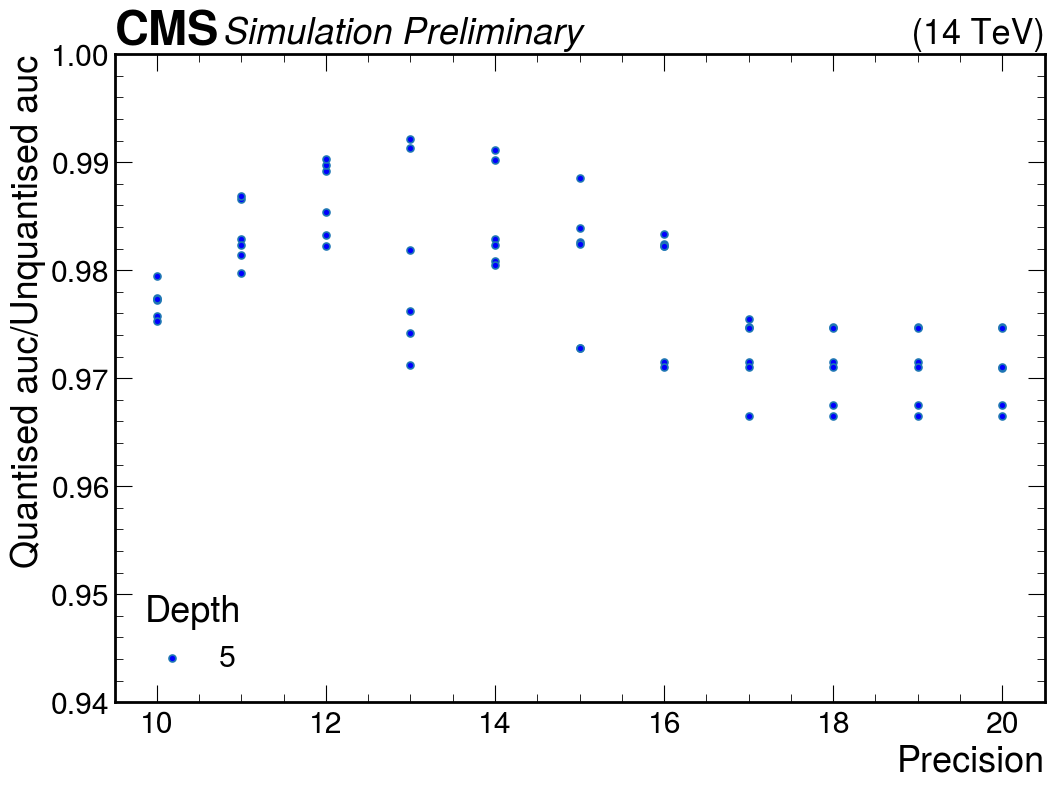

In [25]:
df = df[(df["depth"] <6) & (df["depth"] >4)]
try:
    df["precision"] = df["precision"].astype(int)
except Exception:
    pass
df["e/o"] = df["auc_hdl"]/df["auc_sw"]
# --- Colors per precision ---
depth = sorted(df["depth"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
depth_to_color = {d: next(color_cycle) for d in depth}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,8))

for d in depth:
    sub = df[df["depth"] == d]
    ax.scatter(
        sub["precision"],
        sub["e/o"],
        label=f"{5}",
        s=25,
        facecolors="blue",          # <-- hollow markers
        edgecolors=depth_to_color[d],
        linewidths=1.2
    )

ax.set_ylabel("Quantised auc/Unquantised auc")
ax.set_xlabel("Precision")
#ax.set_xscale("log")
ax.set_ylim(0.94,1.0)
#ax.set_xlim(9.5,16.5)
#ax.set_yscale("log")
ax.legend(title="Depth", loc='lower left')#, ncol=3, )#frameon=False)
ax.tick_params(direction='in')
plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
plt.savefig("expected_vs_observed_auc_perprecision_6Integerat4depth.png")
plt.show()

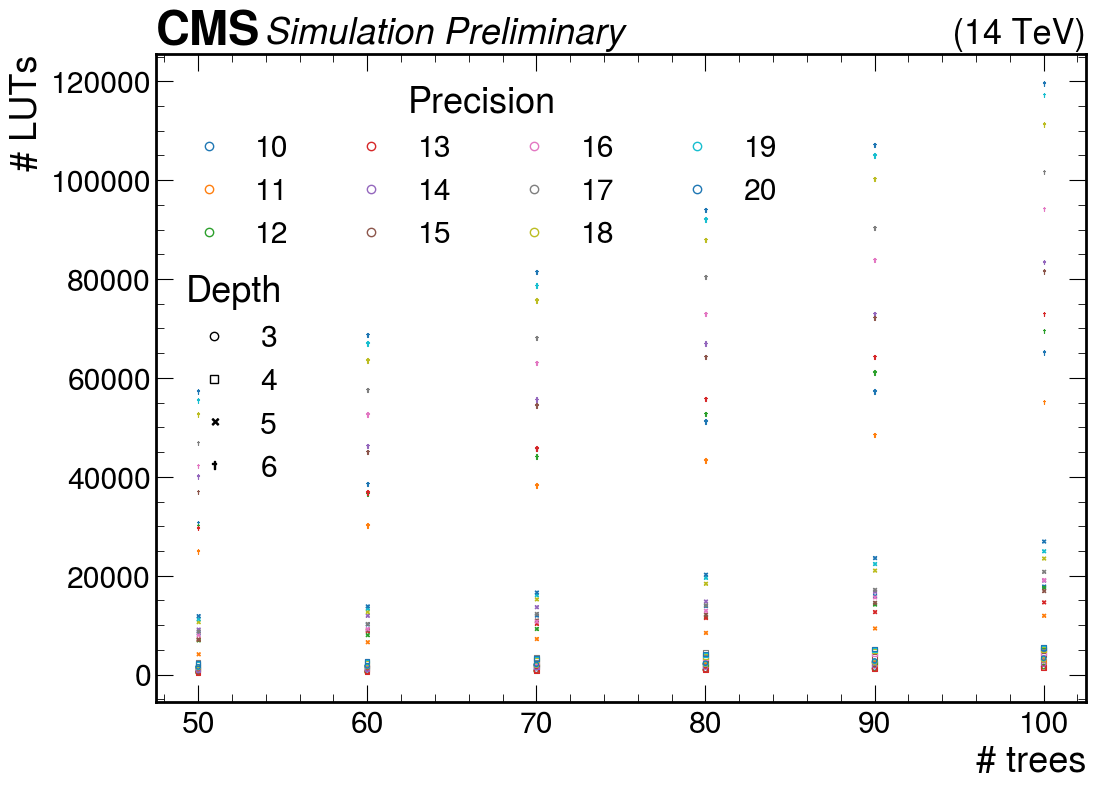

In [65]:

for col in ["precision", "depth"]:
    try:
        df[col] = df[col].astype(int)
    except Exception:
        pass

# --- Colors per precision ---
precisions = sorted(df["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Markers per depth (all hollow-friendly) ---
depths = sorted(df["depth"].unique())
marker_cycle = cycle(['o', 's', r'$\times$', r'$\dagger$', '^', 'v', '>', '<', 'P'])
depth_to_marker = {d: next(marker_cycle) for d in depths}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,8))

# Plot grouped by (precision, depth)
for (p, d), sub in df.groupby(["precision", "depth"]):
    ax.scatter(
        sub["rounds"],
        sub["LUT"],
        s=10,
        facecolors="none",                         # hollow markers
        edgecolors=prec_to_color[p],              # color encodes precision
        marker=depth_to_marker[d],                # shape encodes depth
        linewidths=0.8,
        label=None
    )

ax.set_xlabel("# trees")
ax.set_ylabel("# LUTs")
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.tick_params(direction='in')

# --- Dual legends: Precision (colors) + Depth (markers) ---
prec_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor=prec_to_color[p], label=f"{p}")
    for p in precisions
]
depth_handles = [
    Line2D([0], [0], marker=depth_to_marker[d], linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor='black', label=f"{d}")
    for d in depths
]

leg1 = ax.legend(handles=prec_handles, title="Precision", loc="upper left", ncol=4, frameon=False)
ax.add_artist(leg1)
ax.legend(handles=depth_handles, title="Depth", loc="center left", frameon=False)#ax.legend(title="Precision", , )#frameon=False)
plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/luts_vs_trees_per_precision_per_depth_8Integer.pdf")
plt.show()

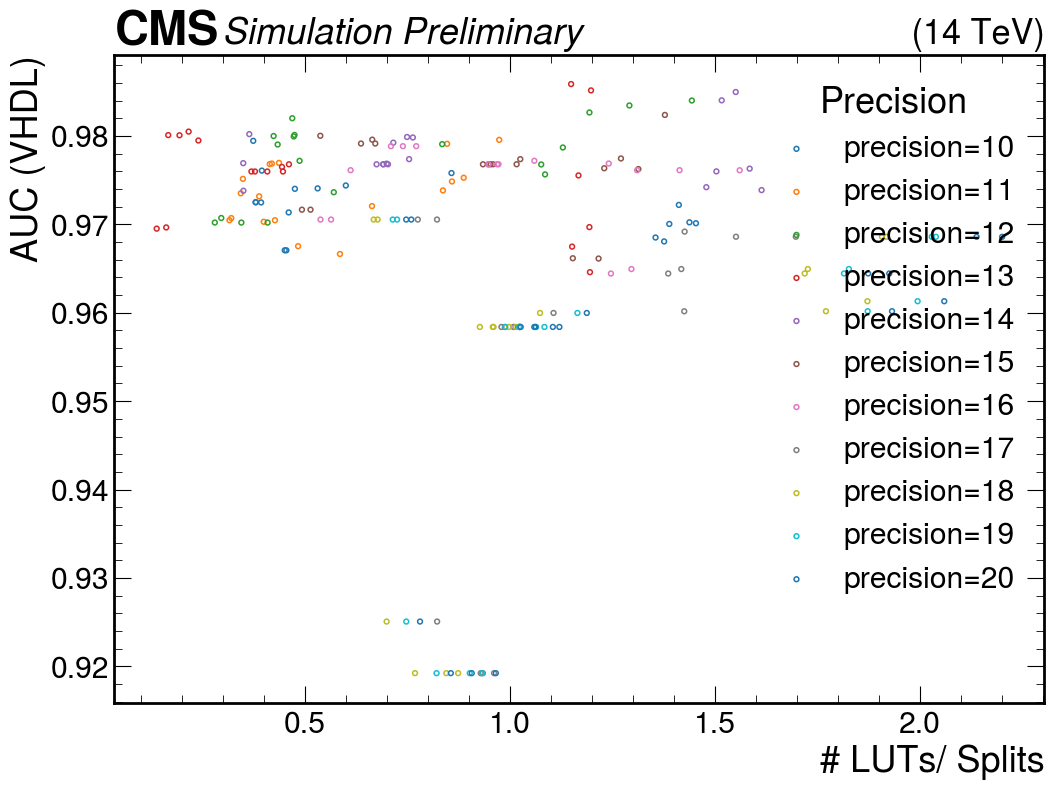

: 

In [ ]:
dff = df[df["splits"] > 0]                 # guard against div-by-zero
dff["precision"] = dff["precision"].astype(int)
dff["LUT_per_split"] = (dff["LUT"])/dff["splits"]

# --- Colors per precision ---
precisions = sorted(dff["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,8))

for p in precisions:
    sub = dff[dff["precision"] == p]
    ax.scatter(
        sub["LUT_per_split"],
        sub["auc_hdl"],
        label=f"precision={p}",
        s=12,
        facecolors="none",                 # hollow markers
        edgecolors=prec_to_color[p],
        linewidths=1.1
    )

ax.set_xlabel("# LUTs/ Splits")
ax.set_ylabel("AUC (VHDL)")
#ax.set_ylim(0.84,0.94)
ax.legend(title="Precision")
ax.tick_params(direction='in')
#ax.set_ylim(0.899,0.97)

plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/luts_by_split_per_precision_8Integer.pdf")

plt.show()

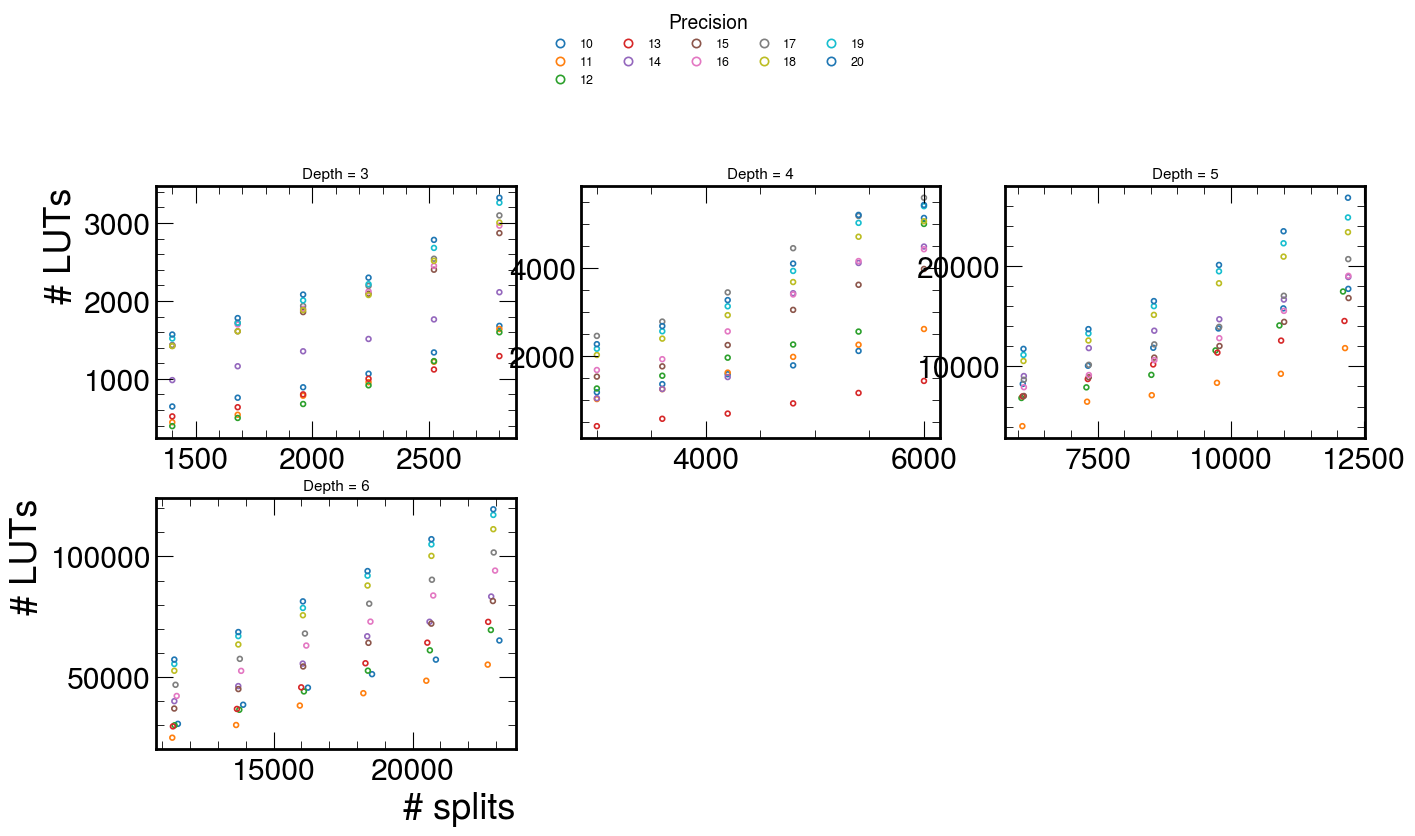

In [66]:
ddf = df.dropna(subset=['LUT', 'splits', 'depth', 'precision', 'auc_hdl', 'rounds']).copy()
try:
    ddf["precision"] = ddf["precision"].astype(int)
except Exception:
    pass

# Unique lists
depths     = sorted(ddf["depth"].dropna().unique().tolist())
precisions = sorted(ddf["precision"].dropna().unique().tolist())

# Consistent colors per precision across all panels
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
precision_to_color = {p: next(color_cycle) for p in precisions}

# --- Panel layout ---
n = len(depths)
ncols = min(3, n)            # up to 3 columns; tweak if you prefer
nrows = ceil(n / ncols)

fig_w = 5.2 * ncols          # size scales with panel count
fig_h = 4.2 * nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharex=False, sharey=False)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
axes = axes.flatten()

# --- Plot each depth in its own panel ---
for i, d in enumerate(depths):
    ax = axes[i]
    sub_d = ddf[ddf["depth"] == d]

    for p in precisions:
        sub = sub_d[sub_d["precision"] == p]
        if sub.empty:
            continue
        ax.scatter(
            sub["splits"], sub["LUT"] ,
            s=12,
            facecolors="none",
            edgecolors=precision_to_color[p],
            linewidths=1.2,
            label=f"{p}"
        )

    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.tick_params(direction='in')
    ax.set_title(f"Depth = {d}", fontsize=11, pad=6)

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Shared labels (only leftmost and bottom panels get axis labels)
for r in range(nrows):
    for c in range(ncols):
        idx = r*ncols + c
        if idx >= n:
            break
        ax = axes[idx]
        if r == nrows - 1:
            ax.set_xlabel("# splits")
        if c == 0:
            ax.set_ylabel("# LUTs")

# --- One consolidated legend ---
# Build handles from the first visible axes that has data
handles, labels = [], []
for p in precisions:
    handles.append(plt.Line2D([], [], linestyle='none', marker='o',
                              markersize=6, markerfacecolor='none',
                              markeredgewidth=1.2, markeredgecolor=precision_to_color[p]))
    labels.append(str(p))

leg = fig.legend(handles, labels, title="Precision",
                 loc="upper center", ncol=min(5, len(precisions)),
                 frameon=False, borderaxespad=0.6, fontsize=9, title_fontsize=14)

plt.subplots_adjust(top=0.78, wspace=0.18, hspace=0.24)

mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/luts_vs_splits_by_depth_panels_8Integer.png")
plt.show()

In [330]:
total_LUTs = 1728000
df["LUT_percent"] = df["LUT"]/total_LUTs * 100

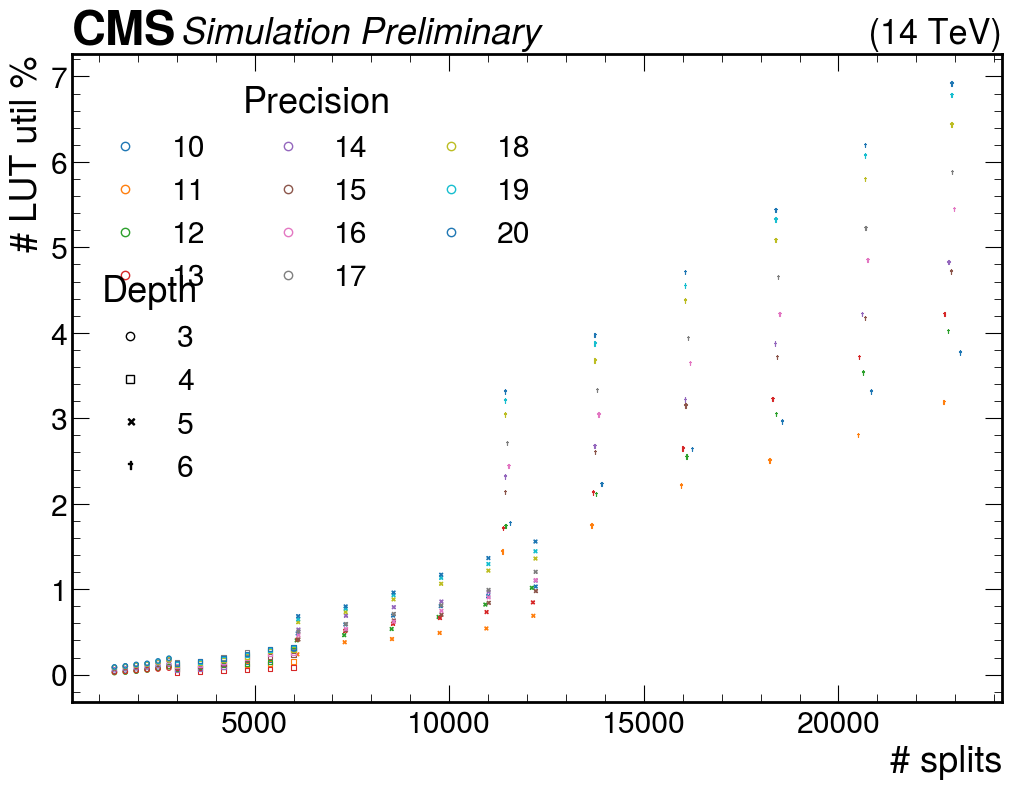

In [331]:
for col in ["precision", "depth"]:
    try:
        df[col] = df[col].astype(int)
    except Exception:
        pass

# --- Colors per precision ---
precisions = sorted(df["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
prec_to_color = {p: next(color_cycle) for p in precisions}

# --- Markers per depth (all hollow-friendly) ---
depths = sorted(df["depth"].unique())
marker_cycle = cycle(['o', 's', r'$\times$', r'$\dagger$', '^', 'v', '>', '<', 'P'])
depth_to_marker = {d: next(marker_cycle) for d in depths}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,8))

# Plot grouped by (precision, depth) 
for (p, d), sub in df.groupby(["precision", "depth"]):
    ax.scatter(
        sub["splits"],
        sub["LUT_percent"],
        s=10,
        facecolors="none",                         # hollow markers
        edgecolors=prec_to_color[p],              # color encodes precision
        marker=depth_to_marker[d],                # shape encodes depth
        linewidths=0.8,
        label=None
    )

ax.set_xlabel("# splits")
ax.set_ylabel("# LUT util %")
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.tick_params(direction='in')

# --- Dual legends: Precision (colors) + Depth (markers) ---
prec_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor=prec_to_color[p], label=f"{p}")
    for p in precisions
]
depth_handles = [
    Line2D([0], [0], marker=depth_to_marker[d], linestyle='None',
           markersize=6, markerfacecolor='none',
           markeredgecolor='black', label=f"{d}")
    for d in depths
]

leg1 = ax.legend(handles=prec_handles, title="Precision", loc="upper left", ncol=3, frameon=False)
ax.add_artist(leg1)
ax.legend(handles=depth_handles, title="Depth", loc="center left", frameon=False)#ax.legend(title="Precision", , )#frameon=False)

plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, com=14) 
#plt.savefig("newsamples_p016_plots/lutspercent_vs_splits_per_precision_per_depth_6Integer.pdf")
plt.show()

In [332]:
df["latency"] = 2 + df["depth"] + np.log(df["rounds"])

In [333]:
df["latency"]

0       8.912023
1       9.094345
2       9.248495
3       9.382027
4       9.499810
         ...    
259    12.094345
260    12.248495
261    12.382027
262    12.499810
263    12.605170
Name: latency, Length: 264, dtype: float64

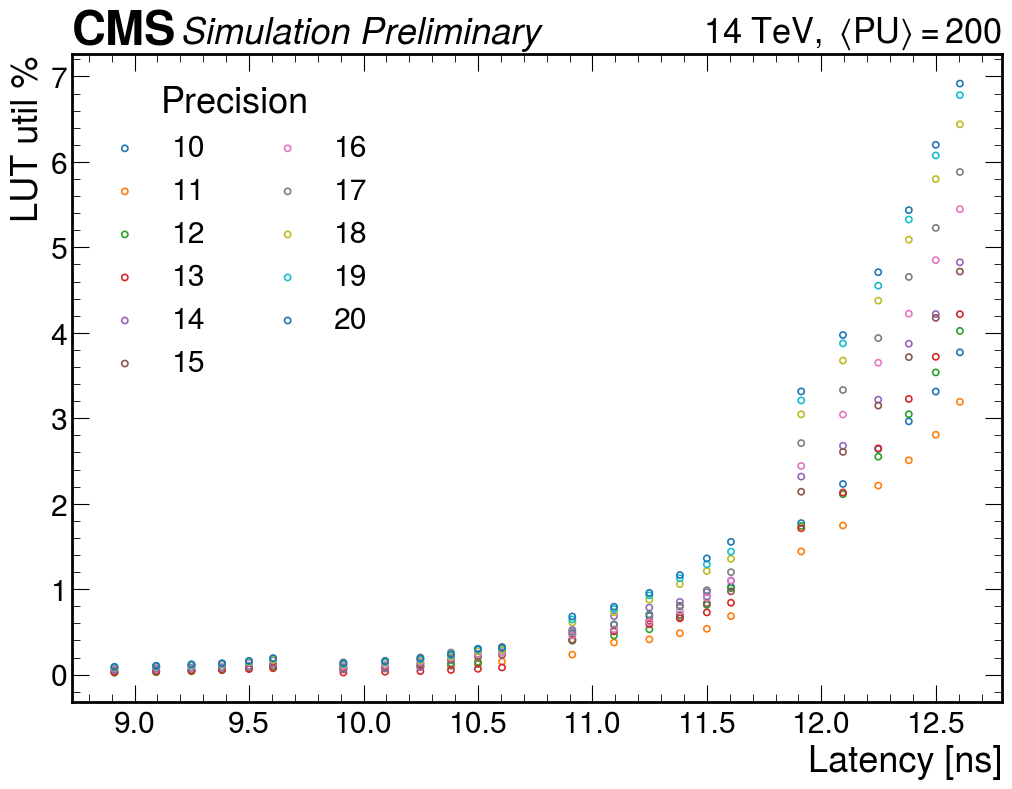

In [336]:
#dff = dff[dff['depth']==6]

try:
    df["precision"] = df["precision"].astype(int)
except Exception:
    pass

# --- Colors per precision ---
precision = sorted(df["precision"].unique())
color_cycle = cycle(mpl.rcParams["axes.prop_cycle"].by_key()["color"])
precision_to_color = {p: next(color_cycle) for p in precision}

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,8))

for p in precision:
    sub = df[df["precision"] == p]
    ax.scatter(
        sub["latency"],
        sub["LUT_percent"],
        label=f"{p}",
        s=20,
        facecolors="none",          # <-- hollow markers
        edgecolors=precision_to_color[p],
        linewidths=1.2
    )

ax.set_ylabel(" LUT util %")
ax.set_xlabel("Latency [ns]")
#ax.set_yscale("log")
#ax.set_xscale("log")

ax.legend(title="Precision", ncol=2)#, frameon=False)
ax.tick_params(direction='in')
plt.subplots_adjust(top=0.92)
mh.cms.label("Preliminary", data=False, rlabel= r"$14~\mathrm{TeV},\ \langle PU\rangle=200$") 
plt.savefig("luts_vs_latency_per_precision_6Integer.pdf")
plt.show()

In [ ]:
def plot_lut_vs_trees(df):
    # Aggregate stats per (depth, n_trees)
    stats = (
        df.groupby(['depth', 'rounds'])['LUT']
          .agg(['mean', 'min', 'max'])
          .reset_index()
    )

    depths = sorted(stats['depth'].unique())
    cmap = plt.get_cmap('Reds')  # light→dark

    fig, ax = plt.subplots(figsize=(4.5, 4.5))

    for i, d in enumerate(depths):
        sub = stats[stats['depth'] == d].sort_values('rounds')
        x = sub['rounds'].to_numpy()
        y = sub['mean'].to_numpy()
        y_min = sub['min'].to_numpy()
        y_max = sub['max'].to_numpy()

        # pick a color going from light to dark with depth index
        c = cmap(0.2 + 0.6 * i / max(len(depths) - 1, 1))

        ax.plot(x, y, color=c, lw=2, label=str(d))
        ax.fill_between(x, y_min, y_max, color=c, alpha=0.25, linewidth=0)

    ax.set_xlabel("n_trees")
    ax.set_ylabel("lut")
    leg = ax.legend(title="max_depth", frameon=False)
    fig.tight_layout()
    return fig, ax

In [ ]:
df['LUT'] = df['LUT_logic'] + df['LUT_memory']
plot_lut_vs_trees(df)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# nice sequential palette for n_trees
n_tree_vals = sorted(df['rounds'].unique())
palette = sns.color_palette("magma", n_colors=len(n_tree_vals))

for color, nt in zip(palette, n_tree_vals):
    sub = df[df['rounds'] == nt].copy()
    sub = sub.sort_values('depth')
    # 2) thick mean line per n_trees
    mean_lut = (
        sub.groupby('depth')['LUT']
           .mean()
           .reset_index()
           .sort_values('depth')
    )
    ax.plot(
        mean_lut['depth'],
        np.log2(mean_lut['LUT']),
        linewidth=2.0,
        alpha=0.9,
        color=color,
        label=f"{nt}"
    )

ax.set_xlabel("max_depth")           # change if your x variable is different
ax.set_ylabel("log2(lut)")
ax.legend(title="n_trees", frameon=False)

fig.tight_layout()
plt.show()

In [ ]:
def plot_lut_vs_nodes_by_precision(df,
                                   lut_col='LUT_logic',
                                   prec_col='precision'):
    df = df.copy()
    if 'n_nodes' not in df.columns:
        df['n_nodes'] = df['splits']/4
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    for prec in sorted(df[prec_col].unique()):
        sub = df[df[prec_col] == prec].sort_values('n_nodes')
        ax.plot(
            sub['n_nodes'],
            sub[lut_col]/4,
            marker='.',
            linestyle='-',
            alpha=0.9,
            label=str(prec)
        )

    ax.set_xlabel('n_nodes')
    ax.set_ylabel('lut')
    ax.legend(title='precision', frameon=False)
    fig.tight_layout()
    return fig, ax
df = df[df['precision']==18]
df = df[df['depth']==4]
plot_lut_vs_nodes_by_precision(df)
plt.show()

In [ ]:
nbits_dict = { #if using manual declaration
    'cl3d_Ref_showerlength': 6,
    'cl3d_Ref_coreshowerlength': 4,
    'cl3d_Ref_firstlayer': 6,
    'cl3d_Ref_eot': 4,
    'cl3d_Ref_hoe': 8,
    'cl3d_Ref_firstHcal5layers': 8,
    'cl3d_Ref_varrr': 7,
    'cl3d_Ref_varzz': 7,
    'cl3d_Ref_varee': 5,
    'cl3d_Ref_varpp': 7,
    'cl3d_Ref_meanz': 12,
    'cl3d_Ref_first1layers': 7,
    'cl3d_Ref_first5layers': 7,
    'cl3d_Ref_last5layers': 6,
    'cl3d_Ref_emax5layers': 8,
    'cl3d_Ref_ebm0': 10,
    'cl3d_Ref_ebm1': 12,
    'cl3d_Ref_hbm': 10,
}
fmin_dict, fmax_dict = df_combined[ana.columns_for_training("Ref")].min(), df_combined[ana.columns_for_training("Ref")].max()

In [ ]:
quantized_data = df_combined.copy()

# Apply quantization to each feature
for col in ana.columns_for_training("Ref"):
    nbits = nbits_dict[col]
    fmin = df_combined[col].min()
    fmax = df_combined[col].max()
    
    # Apply the quantization method (e.g., uniform binning)
    quantized_data[col] = ana.quantize(df_combined[col], nbits, method='uniform', fmin=fmin, fmax=fmax)

In [ ]:
quantized_data

In [ ]:
quantised_photon = photon_df_Ref_filtered.copy()
quantised_pion = pion_df_Ref_filtered.copy()
quantised_qcd = qcd_df_Ref_filtered.copy()
quantised_PU = PU_df_Ref.copy()
for col in ana.columns_for_training("Ref"):
    nbits = nbits_dict[col]
    fmin = df_combined[col].min()
    fmax = df_combined[col].max()
    # Apply the quantization method (e.g., uniform binning)
    quantised_photon[col] = ana.quantize(photon_df_Ref_filtered[col], nbits, method='uniform', fmin=fmin, fmax=fmax)    
    quantised_pion[col] = ana.quantize(pion_df_Ref_filtered[col], nbits, method='uniform', fmin=fmin, fmax=fmax)
    quantised_qcd[col] = ana.quantize(qcd_df_Ref_filtered[col], nbits, method='uniform', fmin=fmin, fmax=fmax)
    quantised_PU[col] = ana.quantize(PU_df_Ref[col], nbits, method='uniform', fmin=fmin, fmax=fmax)

In [ ]:
quantised_photon

In [ ]:
plot_histograms(quantised_photon, quantised_qcd, quantised_pion, quantised_PU, ana.variables_to_plot('Ref'), r'$\gamma$', 'QCD', 'Pions', 'PU200', 'quantized_plots', ana.var_map('Ref'), 'Ref')